# AC FEUP 21/22

## Main dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipympl
#%matplotlib widget - For interactive plots
%matplotlib inline
import seaborn as sb
import numpy as np
import sklearn

# use to not cut columns
pd.set_option('max_columns', None)

# njobs to use in sklearn models
configNJobs = -1

## Import data

### Training data

In [3]:
# import data
def read_csv(file, dtype={}, na_values=None):
    return pd.read_csv("data/" + file, sep=";", dtype=dtype, na_values=na_values)

account_df = read_csv("account.csv")
card_df = read_csv("card_train.csv")
client_df = read_csv("client.csv")
disp_df = read_csv("disp.csv")
district_df = read_csv("district.csv", na_values="?")
loan_df = read_csv("loan_train.csv")
trans_df = read_csv("trans_train.csv", dtype={'bank': 'str'})

trans_df.head()

trans_id  account_id    date    type                     operation  \
0   1548749        5270  930113  credit                credit in cash   
1   1548750        5270  930114  credit  collection from another bank   
2   3393738       11265  930114  credit                credit in cash   
3   3122924       10364  930117  credit                credit in cash   
4   1121963        3834  930119  credit                credit in cash   

    amount  balance k_symbol bank     account  
0    800.0    800.0      NaN  NaN         NaN  
1  44749.0  45549.0      NaN   IJ  80269753.0  
2   1000.0   1000.0      NaN  NaN         NaN  
3   1100.0   1100.0      NaN  NaN         NaN  
4    700.0    700.0      NaN  NaN         NaN

In [4]:
# clean column names (some columns come with an extra whitespace)
district_df.rename(columns=lambda x: x.strip(), inplace=True)

# rename some columns for easier interaction
district_df.rename(columns={"no. of inhabitants": "people_count",
                            "no. of municipalities with inhabitants < 499": "muni_499_count",
                            "no. of municipalities with inhabitants 500-1999": "muni_500-1999_count",
                            "no. of municipalities with inhabitants 2000-9999": "muni_2000-9999_count",
                            "no. of municipalities with inhabitants >10000": "muni_10000_count",
                            "no. of cities": "cities_count",
                            "ratio of urban inhabitants": "ratio_urban_people",
                            "average salary": "avg_salary",
                            "unemploymant rate '95": "unemp_rate_95",
                            "unemploymant rate '96": "unemp_rate_96",
                            "no. of enterpreneurs per 1000 inhabitants": "enterp_per1000",
                            "no. of commited crimes '95": "crime_count_95",
                            "no. of commited crimes '96": "crime_count_96"},
                   inplace=True)
district_df.head()

code         name           region  people_count  muni_499_count  \
0     1  Hl.m. Praha           Prague       1204953               0   
1     2      Benesov  central Bohemia         88884              80   
2     3       Beroun  central Bohemia         75232              55   
3     4       Kladno  central Bohemia        149893              63   
4     5        Kolin  central Bohemia         95616              65   

   muni_500-1999_count  muni_2000-9999_count  muni_10000_count  cities_count  \
0                    0                     0                 1             1   
1                   26                     6                 2             5   
2                   26                     4                 1             5   
3                   29                     6                 2             6   
4                   30                     4                 1             6   

   ratio_urban_people  avg_salary  unemp_rate_95  unemp_rate_96  \
0               100.0       12541           0.29           0.43   
1                46.7        8507           1.67           1.85   
2                41.7        8980           1.95           2.21   
3                67.4        9753           4.64           5.05   
4                51.4        9307           3.85           4.43   

   enterp_per1000  crime_count_95  crime_count_96  
0             167         85677.0           99107  
1             132          2159.0            2674  
2             111          2824.0            2813  
3             109          5244.0            5892  
4             118          2616.0            3040

### Test data

In [5]:
card_test_df = read_csv("card_test.csv")
loan_test_df = read_csv("loan_test.csv")
trans_test_df = read_csv("trans_test.csv", dtype={'bank': 'str'})

## Domain analysis

In [6]:
len(loan_df[loan_df["status"] == 1]) / len(loan_df)

0.8597560975609756

Almost **90%** of the loans in the dataset have been granted (positive result). This means that accuracy isn't a good metric to optimize for.

In [7]:
print("Client count: ", len(client_df))
print("Card count: ", len(card_df))

Client count:  5369
Card count:  177


Since the dataset is somewhat old (1990), most clients don't have a credit card.

Skew: -2.0816213381952395
Adjusted skewness: -2.081621338195239
Kurtosis: 2.3474239284321956


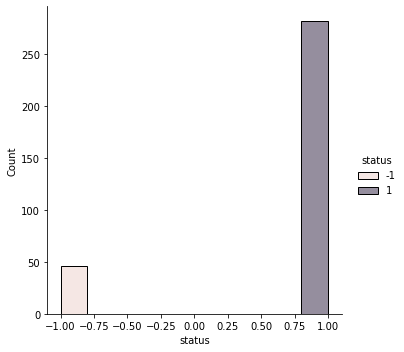

In [8]:
from scipy.stats import skew

sb.displot(x="status", data=loan_df, hue="status")
print("Skew:", loan_df["status"].skew())
print("Adjusted skewness:", skew(loan_df["status"], bias=False))
print("Kurtosis:", loan_df["status"].kurt())

The status deviates from the normal distribution, has negative skewness, and positive kurtosis.

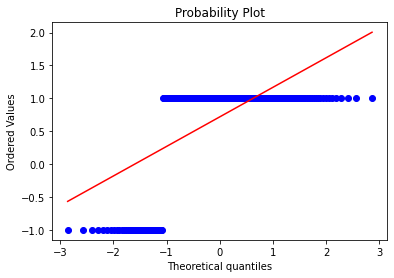

In [9]:
from scipy.stats import probplot

fig = plt.figure()
_ = probplot(loan_df["status"], plot=plt)

<AxesSubplot:xlabel='status', ylabel='amount'>

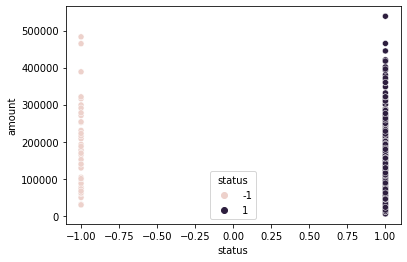

In [10]:
sb.scatterplot(x="status", y="amount", data=loan_df, hue="status")

There appears to be less rejected loans at higher amounts. We aren't sure is the currencies in the dataset are in **_constant prices_**. They should be, so we can disregard the effects of inflation.

<AxesSubplot:xlabel='date', ylabel='amount'>

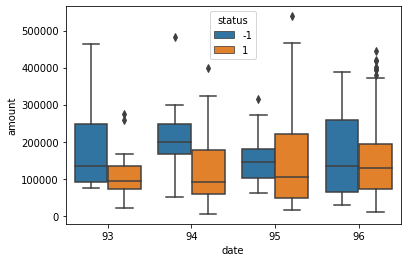

In [11]:
sb.boxplot(x=loan_df["date"]//10000, y="amount", data=loan_df, hue="status")

Although it isn't exactly clear, more loans appear to be accepted over the years.

## Dealing with missing values

### Account data

In [12]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No NULL data to deal with on this dataframe.

### Card data

In [13]:
card_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

No NULL data to deal with on this dataframe.

In [14]:
card_test_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

### Client data

In [15]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

There are no NULL values on this dataset to deal with.

### Disposition data

In [16]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

No NULL data to deal with on this dataframe.

### District data

In [17]:
district_df.isnull().sum()

code                    0
name                    0
region                  0
people_count            0
muni_499_count          0
muni_500-1999_count     0
muni_2000-9999_count    0
muni_10000_count        0
cities_count            0
ratio_urban_people      0
avg_salary              0
unemp_rate_95           1
unemp_rate_96           0
enterp_per1000          0
crime_count_95          1
crime_count_96          0
dtype: int64

There is 1 NULL value in _unemp\_rate\_95_ and _crime\_count\_95_.

In [18]:
district_df[district_df["unemp_rate_95"].isnull()]

code     name         region  people_count  muni_499_count  \
68    69  Jesenik  north Moravia         42821               4   

    muni_500-1999_count  muni_2000-9999_count  muni_10000_count  cities_count  \
68                   13                     5                 1             3   

    ratio_urban_people  avg_salary  unemp_rate_95  unemp_rate_96  \
68                48.4        8173            NaN           7.01   

    enterp_per1000  crime_count_95  crime_count_96  
68             124             NaN            1358

Both of these missing values refer the district of _Jesenik_. We can find the mean growth/shrinkage of the unemploymant and number of crimes commit from 1995 to 1996, and use that to fill the missing values of 1995 for this district.

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

input_df = district_df.drop(["name", "region"], axis=1)

inputer = IterativeImputer(random_state=0)
inputed = inputer.fit_transform(input_df)
inputed_df = pd.DataFrame(inputed, columns=input_df.columns)
district_df["unemp_rate_95"] = inputed_df["unemp_rate_95"]
district_df["crime_count_95"] = inputed_df["crime_count_95"]
district_df[district_df["code"] == 69]

code     name         region  people_count  muni_499_count  \
68    69  Jesenik  north Moravia         42821               4   

    muni_500-1999_count  muni_2000-9999_count  muni_10000_count  cities_count  \
68                   13                     5                 1             3   

    ratio_urban_people  avg_salary  unemp_rate_95  unemp_rate_96  \
68                48.4        8173       5.850917           7.01   

    enterp_per1000  crime_count_95  crime_count_96  
68             124     1015.688842            1358

The Imputation by Multivariate Imputation by Chained Equation (MICE) is used to fill in the two missing values. The _name_ and _region_ aren't fed to the inputer as they are categorical values, which aren't supported. The KNNInputer wasn't used, because the data isn't scaled.

#### Data quality dimension 6 - timeliness

There are points in time missing from the dataset. This means that the data doesn't achieve timeliness.

### Loan data

In [20]:
loan_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

There are no NULL values to fill on this dataframe.

In [21]:
loan_test_df.isnull().sum()

loan_id         0
account_id      0
date            0
amount          0
duration        0
payments        0
status        354
dtype: int64

These missing values (_status_) don't matter as they are the targets of our prediction model.

### Transaction data

In [22]:
trans_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

In [23]:
trans_test_df.isnull().sum()

trans_id          0
account_id        0
date              0
type              0
operation      5130
amount            0
balance           0
k_symbol      17419
bank          24377
account       21061
dtype: int64

There are 4 attributes with a large quantity of null values on this dataframe that have to dealt with: _operation_, _k\_symbol_, _bank_, and _account_.

In [24]:
trans_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [25]:
len(trans_df[trans_df['operation'].isnull()]) / len(trans_df['operation']) * 100.0

17.838083113805663

The _operation_ attribute is categorical and doesn't reveal an inherited order. It can be enconded with 3 attributes using binary encoding.

This attribute is problematic because it contains a significant number of NULL values ($17.8\%$).

It was decided that these rows will be filled with _unknown_.

In [26]:
trans_df['operation'].fillna('unknown', inplace=True)

trans_test_df['operation'].fillna('unknown', inplace=True)

In [27]:
trans_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There is a category that is an empty string. It is likely that the missing values were intended to be part of this category as well. It is assumed that these rows with the _empty_ category refer to common transactions that aren't related to pensions, insurance, etc... The missing values and the empty rows of this attribute will be renamed to _no_symbol_.

In [28]:
def treat_null_k_symbol(row):
    k_symb = row['k_symbol']
    if isinstance(k_symb, float):
        return 'no_symbol'
    elif k_symb == " ":
        return 'no_symbol'
    else:
        return k_symb
    

trans_df['k_symbol'] = trans_df.apply(treat_null_k_symbol, axis=1)
trans_test_df['k_symbol'] = trans_test_df.apply(treat_null_k_symbol, axis=1)

trans_df['k_symbol'].value_counts()

no_symbol                                204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

There many rows where we don't know which is the bank of the partner.

In [29]:
trans_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

In [30]:
trans_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

The unknown information about the partner's bank translates to unkown information about the partner. This is sometimes represented by a **0** on the _account_ attribute.

In [31]:
print("Number of unknown banks:", len(trans_df[trans_df['bank'].isnull()]))
print("Number of unknown partners:", len(trans_df[trans_df['account'].isnull()]) + len(trans_df[trans_df['account'] == 0]))

Number of unknown banks: 299443
Number of unknown partners: 299443


The number of unknown banks is the same as the number of unkown partners => these 2 features are highly correlated. Even though these 2 attributes aren't likelly to contribute anything to our dataset, we can create an **'unknown' bank** and set all unknown _account_ attributes to 0.

In [32]:
trans_df['account'].fillna(0, inplace=True)
trans_df['bank'].fillna("unknown", inplace=True)

trans_test_df['account'].fillna(0, inplace=True)
trans_test_df['bank'].fillna("unknown", inplace=True)

trans_df.head()

trans_id  account_id    date    type                     operation  \
0   1548749        5270  930113  credit                credit in cash   
1   1548750        5270  930114  credit  collection from another bank   
2   3393738       11265  930114  credit                credit in cash   
3   3122924       10364  930117  credit                credit in cash   
4   1121963        3834  930119  credit                credit in cash   

    amount  balance   k_symbol     bank     account  
0    800.0    800.0  no_symbol  unknown         0.0  
1  44749.0  45549.0  no_symbol       IJ  80269753.0  
2   1000.0   1000.0  no_symbol  unknown         0.0  
3   1100.0   1100.0  no_symbol  unknown         0.0  
4    700.0    700.0  no_symbol  unknown         0.0

### Data quality dimension 1 - completeness

Since some non-optional data was missing, the data cannot be considered complete.

## Join data

It is needed to join all datasets into a **single one**.

In [33]:
def join(df1, df2, key1, key2, suff, t="inner"):
    return df1.merge(df2, left_on=key1, right_on=key2, how=t, suffixes=suff)

### Join account with disposition

All _Accounts_ have at least one _Disposition_. There are more _Dispositions_ than _Accounts_, because some clients are **owners** of an account while others are **disponent owners**.

In [34]:
disp_df["type"].value_counts()

OWNER        4500
DISPONENT     869
Name: type, dtype: int64

In order to join all data later, we will create an attribute on the _Account_ table that reflects whether the account is co-owned. Note that the _DISPONENTs_ will be dropped from the joined table. The type attribute can be dropped as well all dispositions are _OWNER_.

In [35]:
def join_acc_disp():
    acc_disp = join(account_df, disp_df, "account_id", "account_id", ['', '_disp'])
    acc_disp.rename(columns={"type": "account_type",
                             "date": "account_creation",
                             "frequency": "issuance_freq"}, inplace=True)
    # count groups
    owner_count = acc_disp["account_id"].value_counts()
    acc_disp["is_coowned"] = acc_disp.apply(lambda row: True if owner_count[row["account_id"]] > 1 else False, axis=1)
    acc_disp["is_coowned"] = acc_disp["is_coowned"].astype(int)
    # cleanup
    acc_disp.drop(acc_disp[acc_disp["account_type"] == "DISPONENT"].index, inplace=True)
    acc_disp.drop(["account_type"], axis=1, inplace=True)
    #
    return acc_disp

df = join_acc_disp()
df

account_id  district_id     issuance_freq  account_creation  disp_id  \
0            576           55  monthly issuance            930101      692   
2           3818           74  monthly issuance            930101     4601   
4            704           55  monthly issuance            930101      844   
6           2378           16  monthly issuance            930101     2873   
7           2632           24  monthly issuance            930102     3177   
...          ...          ...               ...               ...      ...   
5362         124           55  monthly issuance            971228      149   
5363        3958           59  monthly issuance            971228     4774   
5365         777           30  monthly issuance            971228      929   
5366        1573           63  monthly issuance            971229     1906   
5367        3276            1  monthly issuance            971229     3965   

      client_id  is_coowned  
0           692           1  
2          4601           1  
4           844           1  
6          2873           0  
7          3177           0  
...         ...         ...  
5362        149           0  
5363       4774           1  
5365        929           0  
5366       1906           0  
5367       3965           1  

[4500 rows x 7 columns]

### Join clients

Nothing special needs to be done to join the _Client_ table. We can drop the some attributes (foreign keys).

In [36]:
df = join(df, client_df, 'client_id', 'client_id', ['', '_client'], t="left")
df.rename(columns={"age": "client_age"}, inplace=True)
df.drop(['client_id'], axis=1, inplace=True)
df

account_id  district_id     issuance_freq  account_creation  disp_id  \
0            576           55  monthly issuance            930101      692   
1           3818           74  monthly issuance            930101     4601   
2            704           55  monthly issuance            930101      844   
3           2378           16  monthly issuance            930101     2873   
4           2632           24  monthly issuance            930102     3177   
...          ...          ...               ...               ...      ...   
4495         124           55  monthly issuance            971228      149   
4496        3958           59  monthly issuance            971228     4774   
4497         777           30  monthly issuance            971228      929   
4498        1573           63  monthly issuance            971229     1906   
4499        3276            1  monthly issuance            971229     3965   

      is_coowned  birth_number  district_id_client  
0              1        365111                  74  
1              1        350402                   1  
2              1        450114                  22  
3              0        755324                  16  
4              0        380812                  24  
...          ...           ...                 ...  
4495           0        480627                  55  
4496           1        510814                  59  
4497           0        350423                  30  
4498           0        220707                  63  
4499           1        630516                   1  

[4500 rows x 8 columns]

### Join district

Both the _Account_ and the _Client_ table have a foreign key to the _District_ table.

**Note:** Only the _Client_ key will be joined with the _District_ table, because we only care about the account owner's residence and now the place where the account was registered.

In [37]:
df = join(df, district_df, 'district_id_client', 'code', ['', '_district'])
df.rename(columns={"code": "district_code", "name": "district_name"}, inplace=True)
df.drop(['district_id', 'district_id_client'], axis=1, inplace=True)
df

account_id     issuance_freq  account_creation  disp_id  is_coowned  \
0            576  monthly issuance            930101      692           1   
1           2484  monthly issuance            930103     2999           0   
2           1338  monthly issuance            930111     1619           1   
3           1179  monthly issuance            930123     1419           1   
4           1649  monthly issuance            930126     1999           0   
...          ...               ...               ...      ...         ...   
4495        1976  monthly issuance            970325     2401           0   
4496        3176  monthly issuance            970326     3841           0   
4497         768  monthly issuance            970703      918           0   
4498         307  monthly issuance            970807      374           0   
4499        1608  monthly issuance            971008     1950           0   

      birth_number  district_code    district_name         region  \
0           365111             74  Ostrava - mesto  north Moravia   
1           795324             74  Ostrava - mesto  north Moravia   
2           425127             74  Ostrava - mesto  north Moravia   
3           185125             74  Ostrava - mesto  north Moravia   
4           825210             74  Ostrava - mesto  north Moravia   
...            ...            ...              ...            ...   
4495        485126             26    Plzen - mesto   west Bohemia   
4496        190708             26    Plzen - mesto   west Bohemia   
4497        641223             26    Plzen - mesto   west Bohemia   
4498        670614             26    Plzen - mesto   west Bohemia   
4499        290706             26    Plzen - mesto   west Bohemia   

      people_count  muni_499_count  muni_500-1999_count  muni_2000-9999_count  \
0           323870               0                    0                     0   
1           323870               0                    0                     0   
2           323870               0                    0                     0   
3           323870               0                    0                     0   
4           323870               0                    0                     0   
...            ...             ...                  ...                   ...   
4495        170449               0                    0                     0   
4496        170449               0                    0                     0   
4497        170449               0                    0                     0   
4498        170449               0                    0                     0   
4499        170449               0                    0                     0   

      muni_10000_count  cities_count  ratio_urban_people  avg_salary  \
0                    1             1               100.0       10673   
1                    1             1               100.0       10673   
2                    1             1               100.0       10673   
3                    1             1               100.0       10673   
4                    1             1               100.0       10673   
...                ...           ...                 ...         ...   
4495                 1             1               100.0       10787   
4496                 1             1               100.0       10787   
4497                 1             1               100.0       10787   
4498                 1             1               100.0       10787   
4499                 1             1               100.0       10787   

      unemp_rate_95  unemp_rate_96  enterp_per1000  crime_count_95  \
0              4.75           5.44             100         18782.0   
1              4.75           5.44             100         18782.0   
2              4.75           5.44             100         18782.0   
3              4.75           5.44             100         18782.0   
4              4.75           5.44             100         18782

### Create test DataFrame

The next 3 tables have train and test versions (train/test split). As such, we'll work with 2 DataFrames from now on: _df_ and _df\_test_.

In [38]:
df_test = df.copy()

### Join loan

In [39]:
def join_loan(df, loan_df):
    ret = join(df, loan_df, 'account_id', 'account_id', ['', '_loan'], t="right")
    ret.drop(['loan_id'], axis=1, inplace=True)
    ret.rename(columns={"date": "loan_date"}, inplace=True)
    return ret

df = join_loan(df, loan_df)
df_test = join_loan(df_test, loan_test_df)
df

account_id     issuance_freq  account_creation  disp_id  is_coowned  \
0          1787   weekly issuance            930322     2166           0   
1          1801  monthly issuance            930213     2181           0   
2          9188  monthly issuance            930208    11006           0   
3          1843  monthly issuance            930130     2235           0   
4         11013   weekly issuance            930214    13231           0   
..          ...               ...               ...      ...         ...   
323        9030  monthly issuance            950121    10813           1   
324        3189  monthly issuance            951129     3855           0   
325        8972  monthly issuance            960521    10742           0   
326       10963  monthly issuance            950520    13172           0   
327       11362  monthly issuance            951014    13663           0   

     birth_number  district_code      district_name         region  \
0          475722             30            Sokolov   west Bohemia   
1          680722             46             Nachod   east Bohemia   
2          360602             45              Jicin   east Bohemia   
3          405420             14   Ceske Budejovice  south Bohemia   
4          780907             63             Vyskov  south Moravia   
..            ...            ...                ...            ...   
323        715410             72            Olomouc  north Moravia   
324        390320             29           Rokycany   west Bohemia   
325        575504             70            Karvina  north Moravia   
326        530601             16  Jindrichuv Hradec  south Bohemia   
327        626019             67            Bruntal  north Moravia   

     people_count  muni_499_count  muni_500-1999_count  muni_2000-9999_count  \
0           94812              15                   13                     8   
1          112709              48                   20                     7   
2           77917              85                   19                     6   
3          177686              69                   27                    10   
4           86513              38                   36                     5   
..            ...             ...                  ...                   ...   
323        226122              32                   50                     7   
324         45714              52                   10                     5   
325        285387               0                    2                     8   
326         93931              74                   21                    10   
327        106054              38                   25                     6   

     muni_10000_count  cities_count  ratio_urban_people  avg_salary  \
0                   2            10                81.8        9650   
1                   3            10                73.5        8369   
2                   1             5                53.5        8390   
3                   1             9                74.8       10045   
4                   1             5                50.5        8288   
..                ...           ...                 ...         ...   
323                 4             4                62.6        8994   
324                 1             6                55.6        8843   
325                 5             7                89.9       10177   
326                 1             8                56.9        8427   
327                 2             6                63.1        8110   

     unemp_rate_95  unemp_rate_96  enterp_per1000  crime_count_95  \
0             3.38           3.67             100          2985.0   
1             1.79           2.31             117          2854.0   
2             2.28           2.89             132          2080.0   
3             1.42           1.71             135          6604.0   
4             3.79           4.52             110          1562.0   
..             ...     

#### Data quality dimension 5 - integrity

Most accounts have no loan requests associated with them: there are orphaned records. This mean that the data lacks integrity.

### Join card

Almost no client in the dataset has a card. This proves to be problematic when joining the data as it creates many missing values or makes us lose information.

The _Card_ table contains only 2 useful informations: the type of the card (which can be ordered from 'worst' to 'best'), and the date of issuance. The type of the card helps us rank clients: a client with a gold card is better than a client with a junior card. The issuance date allows us to consider only cards that have been issued before the loan (only information before the issuance of a loan matters for its decision).

This **type** is categorical data. _junior_ accounts are for underage people (lowest tier) and usually it isn't possible to withdrawal money from them, and _gold_ account are the highest tier. There is an implicit order here: _junior_ < _classic_ < _gold_.

In [40]:
card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
cardtypes_df = card_disp.groupby([card_disp.account_id, card_disp.type_card]).size().unstack(fill_value=0)
cardtypes_df

type_card   classic  gold  junior
account_id                       
33                0     1       0
43                0     0       1
66                1     0       0
71                0     0       1
73                1     0       0
...             ...   ...     ...
10227             1     0       0
10411             0     1       0
10520             0     1       0
11042             1     0       0
11359             1     0       0

[177 rows x 3 columns]

In [41]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    # unneed now
    ret.drop(["disp_id"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

account_id     issuance_freq  account_creation  is_coowned  birth_number  \
0          1787   weekly issuance            930322           0        475722   
1          1801  monthly issuance            930213           0        680722   
2          9188  monthly issuance            930208           0        360602   
3          1843  monthly issuance            930130           0        405420   
4         11013   weekly issuance            930214           0        780907   
..          ...               ...               ...         ...           ...   
323        9030  monthly issuance            950121           1        715410   
324        3189  monthly issuance            951129           0        390320   
325        8972  monthly issuance            960521           0        575504   
326       10963  monthly issuance            950520           0        530601   
327       11362  monthly issuance            951014           0        626019   

     district_code      district_name         region  people_count  \
0               30            Sokolov   west Bohemia         94812   
1               46             Nachod   east Bohemia        112709   
2               45              Jicin   east Bohemia         77917   
3               14   Ceske Budejovice  south Bohemia        177686   
4               63             Vyskov  south Moravia         86513   
..             ...                ...            ...           ...   
323             72            Olomouc  north Moravia        226122   
324             29           Rokycany   west Bohemia         45714   
325             70            Karvina  north Moravia        285387   
326             16  Jindrichuv Hradec  south Bohemia         93931   
327             67            Bruntal  north Moravia        106054   

     muni_499_count  muni_500-1999_count  muni_2000-9999_count  \
0                15                   13                     8   
1                48                   20                     7   
2                85                   19                     6   
3                69                   27                    10   
4                38                   36                     5   
..              ...                  ...                   ...   
323              32                   50                     7   
324              52                   10                     5   
325               0                    2                     8   
326              74                   21                    10   
327              38                   25                     6   

     muni_10000_count  cities_count  ratio_urban_people  avg_salary  \
0                   2            10                81.8        9650   
1                   3            10                73.5        8369   
2                   1             5                53.5        8390   
3                   1             9                74.8       10045   
4                   1             5                50.5        8288   
..                ...           ...                 ...         ...   
323                 4             4                62.6        8994   
324                 1             6                55.6        8843   
325                 5             7                89.9       10177   
326                 1             8                56.9        8427   
327                 2             6                63.1        8110   

     unemp_rate_95  unemp_rate_96  enterp_per1000  crime_count_95  \
0             3.38           3.67             100          2985.0   
1             1.79           2.31             117          2854.0   
2             2.28           2.89             132          2080.0   
3             1.42           1.71             135          6604.0   
4             3.79           4.52             110          1562.0   
..             ...            ...             ...             ...   
323           3.80           4.79             110          967

In [42]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

account_id     issuance_freq  account_creation  is_coowned  birth_number  \
0          1787   weekly issuance            930322           0        475722   
1          1801  monthly issuance            930213           0        680722   
2          9188  monthly issuance            930208           0        360602   
3          1843  monthly issuance            930130           0        405420   
4         11013   weekly issuance            930214           0        780907   
..          ...               ...               ...         ...           ...   
323        9030  monthly issuance            950121           1        715410   
324        3189  monthly issuance            951129           0        390320   
325        8972  monthly issuance            960521           0        575504   
326       10963  monthly issuance            950520           0        530601   
327       11362  monthly issuance            951014           0        626019   

     district_code      district_name         region  people_count  \
0               30            Sokolov   west Bohemia         94812   
1               46             Nachod   east Bohemia        112709   
2               45              Jicin   east Bohemia         77917   
3               14   Ceske Budejovice  south Bohemia        177686   
4               63             Vyskov  south Moravia         86513   
..             ...                ...            ...           ...   
323             72            Olomouc  north Moravia        226122   
324             29           Rokycany   west Bohemia         45714   
325             70            Karvina  north Moravia        285387   
326             16  Jindrichuv Hradec  south Bohemia         93931   
327             67            Bruntal  north Moravia        106054   

     muni_499_count  muni_500-1999_count  muni_2000-9999_count  \
0                15                   13                     8   
1                48                   20                     7   
2                85                   19                     6   
3                69                   27                    10   
4                38                   36                     5   
..              ...                  ...                   ...   
323              32                   50                     7   
324              52                   10                     5   
325               0                    2                     8   
326              74                   21                    10   
327              38                   25                     6   

     muni_10000_count  cities_count  ratio_urban_people  avg_salary  \
0                   2            10                81.8        9650   
1                   3            10                73.5        8369   
2                   1             5                53.5        8390   
3                   1             9                74.8       10045   
4                   1             5                50.5        8288   
..                ...           ...                 ...         ...   
323                 4             4                62.6        8994   
324                 1             6                55.6        8843   
325                 5             7                89.9       10177   
326                 1             8                56.9        8427   
327                 2             6                63.1        8110   

     unemp_rate_95  unemp_rate_96  enterp_per1000  crime_count_95  \
0             3.38           3.67             100          2985.0   
1             1.79           2.31             117          2854.0   
2             2.28           2.89             132          2080.0   
3             1.42           1.71             135          6604.0   
4             3.79           4.52             110          1562.0   
..             ...            ...             ...             ...   
323           3.80           4.79             110          967

In [43]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

account_id     issuance_freq  account_creation  is_coowned  birth_number  \
0          1787   weekly issuance            930322           0        475722   
1          1801  monthly issuance            930213           0        680722   
2          9188  monthly issuance            930208           0        360602   
3          1843  monthly issuance            930130           0        405420   
4         11013   weekly issuance            930214           0        780907   
..          ...               ...               ...         ...           ...   
323        9030  monthly issuance            950121           1        715410   
324        3189  monthly issuance            951129           0        390320   
325        8972  monthly issuance            960521           0        575504   
326       10963  monthly issuance            950520           0        530601   
327       11362  monthly issuance            951014           0        626019   

     district_code      district_name         region  people_count  \
0               30            Sokolov   west Bohemia         94812   
1               46             Nachod   east Bohemia        112709   
2               45              Jicin   east Bohemia         77917   
3               14   Ceske Budejovice  south Bohemia        177686   
4               63             Vyskov  south Moravia         86513   
..             ...                ...            ...           ...   
323             72            Olomouc  north Moravia        226122   
324             29           Rokycany   west Bohemia         45714   
325             70            Karvina  north Moravia        285387   
326             16  Jindrichuv Hradec  south Bohemia         93931   
327             67            Bruntal  north Moravia        106054   

     muni_499_count  muni_500-1999_count  muni_2000-9999_count  \
0                15                   13                     8   
1                48                   20                     7   
2                85                   19                     6   
3                69                   27                    10   
4                38                   36                     5   
..              ...                  ...                   ...   
323              32                   50                     7   
324              52                   10                     5   
325               0                    2                     8   
326              74                   21                    10   
327              38                   25                     6   

     muni_10000_count  cities_count  ratio_urban_people  avg_salary  \
0                   2            10                81.8        9650   
1                   3            10                73.5        8369   
2                   1             5                53.5        8390   
3                   1             9                74.8       10045   
4                   1             5                50.5        8288   
..                ...           ...                 ...         ...   
323                 4             4                62.6        8994   
324                 1             6                55.6        8843   
325                 5             7                89.9       10177   
326                 1             8                56.9        8427   
327                 2             6                63.1        8110   

     unemp_rate_95  unemp_rate_96  enterp_per1000  crime_count_95  \
0             3.38           3.67             100          2985.0   
1             1.79           2.31             117          2854.0   
2             2.28           2.89             132          2080.0   
3             1.42           1.71             135          6604.0   
4             3.79           4.52             110          1562.0   
..             ...            ...             ...             ...   
323           3.80           4.79             110          967

In [44]:
df["cards"].value_counts()

0    317
2      8
3      2
1      1
Name: cards, dtype: int64

There are very few clients with cards. Every client with a card has been granted a loan.

In [45]:
df[df["cards"] > 0]["status"].value_counts()

1    11
Name: status, dtype: int64

### Join transactions

The _Transaction_ table poses a problem: there are many transactions for each account. If we just join this table, we'll get multiple rows for each loan which is undesirable.

We have to find a way to extract the useful information from this table to merge it into the dataset.

In [46]:
def filter_acc_ids(df, trans_df):
    tdf = trans_df.copy()
    
    loan_accs = set(df["account_id"])
    tr_to_drop = []
    for id, row in tdf.iterrows():
        if row["account_id"] not in loan_accs:
            tr_to_drop.append(id)

    tdf.drop(tr_to_drop, inplace=True)
    return tdf

tdf = filter_acc_ids(df, trans_df)
tdf_test = filter_acc_ids(df_test, trans_test_df)
tdf.shape

(24494, 10)

**Filter by date**: only consider transactions that happened before the loan decision.

In [47]:
def filter_by_date(df, tdf):
    tr_to_drop = []
    for id, row in tdf.iterrows():
        tr_date = row["date"]
        acc_id = row["account_id"]
        for _, loan_row in df[df["account_id"] == acc_id].iterrows():
            loan_date = loan_row["loan_date"]
            if loan_date < tr_date:
                tr_to_drop.append(id)

    tdf.drop(tr_to_drop, inplace=True)
    return tdf

tdf = filter_by_date(df, tdf)
tdf_test = filter_by_date(df_test, tdf_test)
tdf.shape

(24494, 10)

All transactions happened before the loan decision, so none were dropped.

**Apply transaction types to the transaction amount**: withdrawls imply a negative balance change on the account's funds.

In [48]:
def convert_amount(tdf):
    def convert_amount_inner(row):
        ammount = abs(row['amount'])
        # else are withdrawls
        return ammount if row['type'] == "credit" else -ammount

    # convert ammount to negative according to transaction type
    tdf['amount'] = tdf.apply(convert_amount_inner, axis=1)
    return tdf

tdf = convert_amount(tdf)
tdf_test = convert_amount(tdf_test)
tdf

trans_id  account_id    date        type                     operation  \
0       1548749        5270  930113      credit                credit in cash   
1       1548750        5270  930114      credit  collection from another bank   
2       3393738       11265  930114      credit                credit in cash   
3       3122924       10364  930117      credit                credit in cash   
4       1121963        3834  930119      credit                credit in cash   
...         ...         ...     ...         ...                           ...   
24489    934562        3189  961210  withdrawal            withdrawal in cash   
24490   2729876        9030  961211  withdrawal            withdrawal in cash   
24491   2712272        8972  961213  withdrawal    remittance to another bank   
24492   2712433        8972  961217  withdrawal            withdrawal in cash   
24493   3299514       10963  961218  withdrawal            withdrawal in cash   

        amount  balance   k_symbol     bank     account  
0        800.0    800.0  no_symbol  unknown         0.0  
1      44749.0  45549.0  no_symbol       IJ  80269753.0  
2       1000.0   1000.0  no_symbol  unknown         0.0  
3       1100.0   1100.0  no_symbol  unknown         0.0  
4        700.0    700.0  no_symbol  unknown         0.0  
...        ...      ...        ...      ...         ...  
24489  -6900.0  59578.8  no_symbol  unknown         0.0  
24490 -14600.0  60694.1  no_symbol  unknown         0.0  
24491  -4719.0  56184.3  household       EF  61556398.0  
24492 -17800.0  38384.3  no_symbol  unknown         0.0  
24493  -3100.0  41878.1  no_symbol  unknown         0.0  

[24494 rows x 10 columns]

**Target bank and account**: as was mentioned in the _Dealing with missing values_ section, most transactions are sent to an unknown bank/account (83%). It was decided that no useful information could be extracted from these 2 columns to create an attribute for the joined dataset.

In [49]:
tdf[tdf["bank"] == "unknown"]["bank"].count() / tdf["bank"].count()

0.8296725728749897

In [50]:
tdf.drop(["bank", "account"], axis=1, inplace=True)
tdf_test.drop(["bank", "account"], axis=1, inplace=True)
tdf

trans_id  account_id    date        type                     operation  \
0       1548749        5270  930113      credit                credit in cash   
1       1548750        5270  930114      credit  collection from another bank   
2       3393738       11265  930114      credit                credit in cash   
3       3122924       10364  930117      credit                credit in cash   
4       1121963        3834  930119      credit                credit in cash   
...         ...         ...     ...         ...                           ...   
24489    934562        3189  961210  withdrawal            withdrawal in cash   
24490   2729876        9030  961211  withdrawal            withdrawal in cash   
24491   2712272        8972  961213  withdrawal    remittance to another bank   
24492   2712433        8972  961217  withdrawal            withdrawal in cash   
24493   3299514       10963  961218  withdrawal            withdrawal in cash   

        amount  balance   k_symbol  
0        800.0    800.0  no_symbol  
1      44749.0  45549.0  no_symbol  
2       1000.0   1000.0  no_symbol  
3       1100.0   1100.0  no_symbol  
4        700.0    700.0  no_symbol  
...        ...      ...        ...  
24489  -6900.0  59578.8  no_symbol  
24490 -14600.0  60694.1  no_symbol  
24491  -4719.0  56184.3  household  
24492 -17800.0  38384.3  no_symbol  
24493  -3100.0  41878.1  no_symbol  

[24494 rows x 8 columns]

**Number of times the user was sanctioned for negative balance**: knowing which users had to pay sanctions for reaching negative balances might prove useful to know which loans to reject.

In [51]:
def sanction_count(df, tdf):
    grouped = tdf.groupby("account_id")

    sanction_df = pd.DataFrame(columns=["account_id", "sanctions"])
    for acc_id, group in grouped:
        sanc_cnt = group[group["k_symbol"] == "sanction interest if negative balance"]["k_symbol"].count()
        sanction_df = sanction_df.append({"account_id": acc_id, "sanctions": sanc_cnt}, ignore_index=True)

    df["sanctions"] = sanction_df["sanctions"]
    df["sanctions"].fillna(0.0, inplace=True)
    return df

df = sanction_count(df, tdf)
df_test = sanction_count(df_test, tdf_test)
df["sanctions"].value_counts()

0    314
1      5
2      3
6      2
3      2
4      1
5      1
Name: sanctions, dtype: int64

#### Data quality dimension 2 - consistency

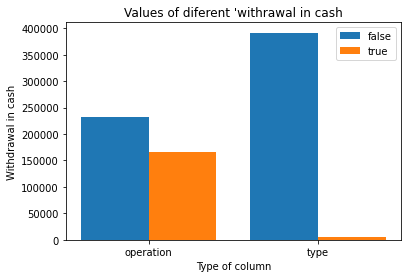

In [52]:
plot_df = pd.DataFrame()
plot_df['operation'] = trans_df.apply(lambda row: True if row.operation == "withdrawal in cash" else False, axis=1)
plot_df['type'] = trans_df.apply(lambda row: True if row.type == "withdrawal in cash" else False, axis=1)
operations = plot_df['operation'].value_counts()
types = plot_df['type'].value_counts()
(types, operations)

def plot_operations_types(operation, types):
    X_axis = np.arange(2)
    falses = (operation[0], types[0])
    trues = (operation[1], types[1])
    plt.bar(X_axis - 0.2, falses, 0.4, label = 'false')
    plt.bar(X_axis + 0.2, trues, 0.4, label = 'true')

    plt.xlabel("Type of column")
    plt.ylabel("Withdrawal in cash")
    plt.title("Values of diferent 'withrawal in cash")
    plt.xticks(X_axis,['operation', 'type'])
    plt.legend()
    plt.show()
    
plot_operations_types(operations, types)

The overlapping information in the _type_ and _operation_ attributes has some mutual contradictions. This means that the data is not consistent.

**Mean household payments**: knowing how much a client pays for its household might prove useful to know how tight for money they are.

In [53]:
def household_mean(df, tdf):
    grouped = tdf.groupby("account_id")

    household_df = pd.DataFrame(columns=["account_id", "household_mean"])
    for acc_id, group in grouped:
        household_mean = abs(group[group["k_symbol"] == "household"]["amount"].mean())
        household_df = household_df.append({"account_id": acc_id, "household_mean": household_mean}, ignore_index=True)

    df["household_mean"] = household_df["household_mean"]
    df["household_mean"].fillna(0.0, inplace=True)
    return df

df = household_mean(df, tdf)
df_test = household_mean(df_test, tdf_test)
df["household_mean"].head()

0     7266.0
1    15925.0
2     6393.0
3        0.0
4     6256.0
Name: household_mean, dtype: float64

**Mean interest payments**: knowing how much a client earns in account interest might be useful.

In [54]:
def interest_mean(df, tdf):
    grouped = tdf.groupby("account_id")

    interest_df = pd.DataFrame(columns=["account_id", "interest_mean"])
    for acc_id, group in grouped:
        interest_mean = abs(group[group["k_symbol"] == "interest credited"]["amount"].mean())
        interest_df = interest_df.append({"account_id": acc_id, "interest_mean": interest_mean}, ignore_index=True)

    df["interest_mean"] = interest_df["interest_mean"]
    df["interest_mean"].fillna(0.0, inplace=True)
    return df

df = interest_mean(df, tdf)
df_test = interest_mean(df_test, tdf_test)
df["interest_mean"].head()

0    128.930000
1    118.091667
2    193.711111
3    252.633333
4    122.200000
Name: interest_mean, dtype: float64

**mean balances in timeframes:** the mean balance in the account 1 month, 1 sementer, and 1 year before the loan request.

In [55]:
def balance_before_timeframe(df, tdf):
    def to_datetime(df, col_name="date"):
        df[col_name + "_dt"] = pd.to_datetime(df[col_name], format="%y%m%d")
    
    to_datetime(df, "loan_date")
    to_datetime(tdf)
    # join loans with transactions so that we can group by account_id
    temp_df = join(df, tdf, "account_id", "account_id",
                   suff=["", "_trans"])[["account_id", "trans_id", "date_dt", "balance", "loan_date_dt"]]
    # calculate month difference between each transaction and loan date
    temp_df['month_diff'] = (temp_df['loan_date_dt'] - temp_df['date_dt']) / np.timedelta64(1, 'M')
    def avg_balance(df, balance_name):
        return df.groupby('account_id').mean()['balance'].reset_index().rename(columns={"balance": balance_name})
    
    # create 3 new tables each with columns (account_id, balance)
    last_1y = avg_balance(temp_df.loc[temp_df['month_diff'] <= 12], "balance_lastyear")
    last_6m = avg_balance(temp_df.loc[temp_df['month_diff'] <= 6], "balance_lastsemester")
    last_1m = avg_balance(temp_df.loc[temp_df['month_diff'] <= 1], "balance_lastmonth")
    res = df.merge(last_1y, on="account_id", how="inner")
    res = res.merge(last_6m, on="account_id", how="inner")
    res = res.merge(last_1m, on="account_id", how="inner")
    
    res.drop(["loan_date_dt"], axis=1, inplace=True)
    tdf.drop(["date_dt"], axis=1, inplace=True)
    return res

df = balance_before_timeframe(df, tdf)
df_test = balance_before_timeframe(df_test, tdf_test)

**Min, max, mean balances**: some statistics about the balance of the client along the time. It is also included the number of times the balance was bellow 500 and 5000, because the average salary in the [Czech Republic in 1990 was about 3200CZK](https://www.czso.cz/csu/czso/2-eng_mzdy_1985_).

In [56]:
def balance_stats(df, tdf):
    grouped = tdf.groupby("account_id")

    balance_df = pd.DataFrame(columns=["account_id",
                                       "balance_min",
                                       "balance_max",
                                       "balance_mean",
                                       "balance_bellow_500",
                                       "balance_bellow_5k"])
    for acc_id, group in grouped:
        #acc_id = group["account_id"].iloc[0]
        #loan_date = df[df["account_id"] == acc_id].iloc[0]["loan_date"]
        
        balance = group["balance"]
        balance_df = balance_df.append({
            "account_id": acc_id,
            "balance_min": balance.min(),
            "balance_max": balance.max(),
            "balance_mean": balance.mean(),
            "balance_bellow_500": group[balance < 500]["balance"].count(),
            "balance_bellow_5k": group[balance < 5000]["balance"].count()
            }, ignore_index=True)

    balance_df.fillna(0.0, inplace=True)
    df = join(df, balance_df, "account_id", "account_id", ['', ''])
    return df

df = balance_stats(df, tdf)
df_test = balance_stats(df_test, tdf_test)
df.head()

account_id     issuance_freq  account_creation  is_coowned  birth_number  \
0        1787   weekly issuance            930322           0        475722   
1        1801  monthly issuance            930213           0        680722   
2        9188  monthly issuance            930208           0        360602   
3        1843  monthly issuance            930130           0        405420   
4       11013   weekly issuance            930214           0        780907   

   district_code     district_name         region  people_count  \
0             30           Sokolov   west Bohemia         94812   
1             46            Nachod   east Bohemia        112709   
2             45             Jicin   east Bohemia         77917   
3             14  Ceske Budejovice  south Bohemia        177686   
4             63            Vyskov  south Moravia         86513   

   muni_499_count  muni_500-1999_count  muni_2000-9999_count  \
0              15                   13                     8   
1              48                   20                     7   
2              85                   19                     6   
3              69                   27                    10   
4              38                   36                     5   

   muni_10000_count  cities_count  ratio_urban_people  avg_salary  \
0                 2            10                81.8        9650   
1                 3            10                73.5        8369   
2                 1             5                53.5        8390   
3                 1             9                74.8       10045   
4                 1             5                50.5        8288   

   unemp_rate_95  unemp_rate_96  enterp_per1000  crime_count_95  \
0           3.38           3.67             100          2985.0   
1           1.79           2.31             117          2854.0   
2           2.28           2.89             132          2080.0   
3           1.42           1.71             135          6604.0   
4           3.79           4.52             110          1562.0   

   crime_count_96  loan_date  amount  duration  payments  status  cards  \
0            2804     930705   96396        12      8033      -1      0   
1            2618     930711  165960        36      4610       1      0   
2            2122     930728  127080        60      2118       1      0   
3            6295     930803  105804        36      2939       1      0   
4            1460     930906  274740        60      4579       1      0   

   sanctions  household_mean  interest_mean  balance_lastyear  \
0          0          7266.0     128.930000      12250.000000   
1          0         15925.0     118.091667      52083.859459   
2          0          6393.0     193.711111      30060.954167   
3          0             0.0     252.633333      41297.480000   
4          0          6256.0     122.200000      57188.211111   

   balance_lastsemester  balance_lastmonth  balance_min  balance_max  \
0          12250.000000       20100.000000       1100.0      20100.0   
1          52083.859459       33113.788889        700.0     120512.8   
2          30060.954167       36233.066667        800.0      49590.4   
3          42976.541667       42535.133333       1000.0      65898.5   
4          59364.680769       49872.757143        600.0     122893.1   

   balance_mean  balance_bellow_500  balance_bellow_5k  
0  12250.000000                 0.0                1.0  
1  52083.859459                 0.0                2.0  
2  30060.954167                 0.0                1.0  
3  41297.480000                 0.0                1.0  
4  57188.211111                 0.0                1.0

Now that the most important information on the _Transaction_ table has been extracted and joined, we can drop the account_id.

In [57]:
df.drop(["account_id"], axis=1, inplace=True)
df_test.drop(["account_id"], axis=1, inplace=True)

### Look for duplicated rows

In [58]:
df.drop(df.drop_duplicates().index)

Empty DataFrame
Columns: [issuance_freq, account_creation, is_coowned, birth_number, district_code, district_name, region, people_count, muni_499_count, muni_500-1999_count, muni_2000-9999_count, muni_10000_count, cities_count, ratio_urban_people, avg_salary, unemp_rate_95, unemp_rate_96, enterp_per1000, crime_count_95, crime_count_96, loan_date, amount, duration, payments, status, cards, sanctions, household_mean, interest_mean, balance_lastyear, balance_lastsemester, balance_lastmonth, balance_min, balance_max, balance_mean, balance_bellow_500, balance_bellow_5k]
Index: []

There are no duplicates.

### Save joined data

In [59]:
from pathlib import Path

filepath = Path("cool_data")
filepath.mkdir(parents=True, exist_ok=True)
    
df.to_csv('cool_data/train-data-join.csv', index=False)
df_test.to_csv('cool_data/test-data-join.csv', index=False)

## Feature engineering

### Read joined data

In [60]:
df = pd.read_csv('cool_data/train-data-join.csv')
df_test = pd.read_csv('cool_data/test-data-join.csv')

### Graph utility function

In [61]:
def plot_categorical_by_status(df, col_name, axis):
    df.groupby([col_name, "status"]).size().unstack(level=1).plot(kind='barh', stacked=True, ax=axis)

### Correlation matrix

The **spearman** method is used (instead of the default **pearson** method), because the data isn't normally distributed.

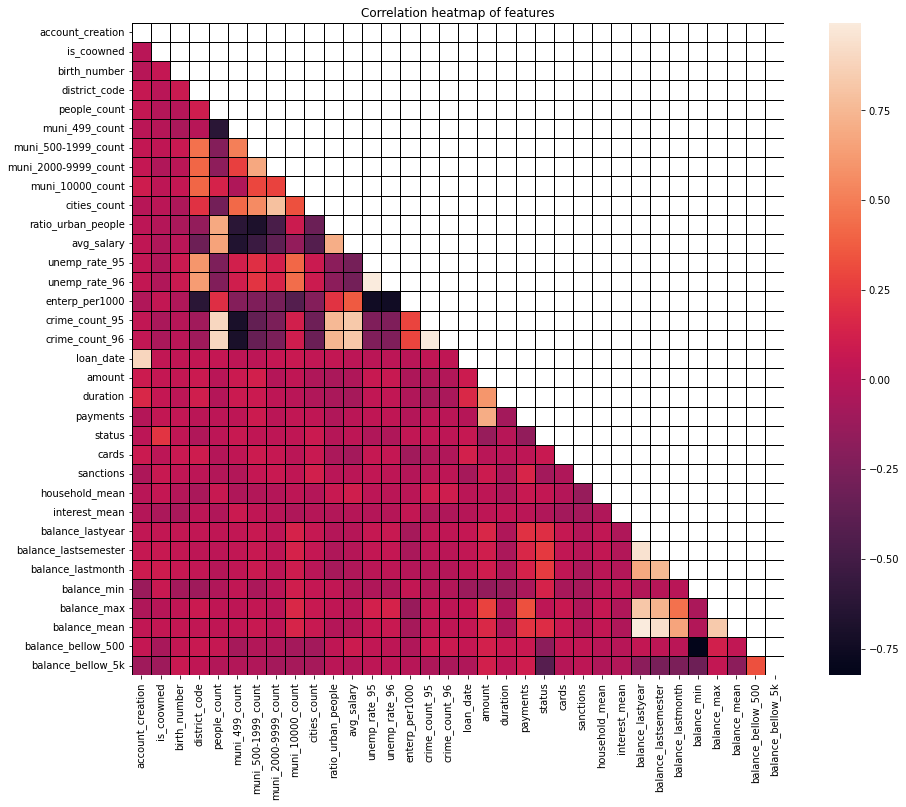

In [62]:
def do_corr(features, annot=True, figsize=(16.0, 12.0)):
    # create correlation matrix
    corr_matrix = df[features].corr(method="spearman");
    
    # mask upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # create correlation heatmap
    plt.figure(figsize=(16.0, 12.0))
    plt.title("Correlation heatmap of features")
    _ = sb.heatmap(corr_matrix, mask=mask, annot=annot, fmt=".2",
                   linecolor='black', linewidths=.5, square=True);
    plt.show();

do_corr(df.columns, annot=False)

There are clusters where the features have a higher correlation. The most interesting appear to be:

- balance\_bellow\_500 and status - Which means this is probably one of the best features for out model.
- balance\_bellow\_500 and balance\_min - Seems counter-intuitive.
- the correlations of the attributes that refer to mean balances, with special attention to balance\_mean and balance\_lastyear.
- the payments and amount are correlated. This was expected has the loan amount is calculated using the payments attribute.
- loan_date and account_creation.
- the crime_counts are very correlated with the population size. This is expected since, generaly speaking, the higher the population, the more crimes are commited.

### ANOVA test

We will use this ANOVA test to test how good the attributes are.

ANOVA is used instead os Chi-Square, because the dataset contains some continuous values.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def do_anova(cols, k="all"):
    # apply selectKBest to select top features
    best_features = SelectKBest(score_func=f_classif, k=k)
    df_cut = df[cols]
    fit = best_features.fit(df_cut, df["status"])
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_cut.columns)

    # concat 2 dataFrame for better visualization
    feature_score = pd.concat([dfcolumns, dfscores], axis=1)
    feature_score.columns = ["Features", "Score"]
    ret = feature_score.sort_values(by="Score", ascending=False)
    return ret.head(k) if k != "all" else ret

### Pairplots

In [64]:
def do_pairplot(attr):
    attr.append("status")
    sb.pairplot(df[list(set(attr))], hue="status", palette=sb.color_palette("tab10")[:2])

### Client

#### Data quality dimension 3 - conformity

Dates follow the format yymmdd, except in the case of the client's birth date. The genre information is included in this attribute by adding 50 to the month (mm) parcel of the number. This means that the data lacks conformity.

#### Work with client's birth_number

In [65]:
def parseYear(x):
    return x // 10000

def parseMonth(x):
    return x // 100 % 100

def parseDay(x):
    return x % 100

From this attribute we can extract the client's date of birth and gender.

<AxesSubplot:xlabel='is_male', ylabel='count'>

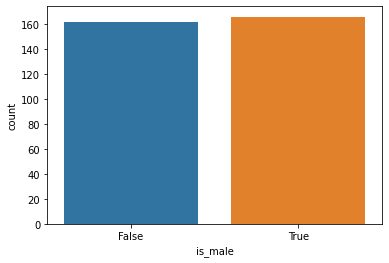

In [66]:
def identify_gender(row):
    birth = row['birth_number']
    month = (birth // 100) % 100
    return False if month > 12 else True

df_test['is_male'] = df_test.apply(identify_gender, axis=1)

# create a new gender column
df['is_male'] = df.apply(identify_gender, axis=1)
df_test['is_male'] = df_test.apply(identify_gender, axis=1)

sb.countplot(x="is_male", data=df)

The genre distribution of clients who asked for loans is almost 50/50.

From the date of birth, we can derive the client's age when the loan was requested.

In [67]:
def identify_year(df):
    # create a new age column with client's age in year
    # when the loan was requested
    df['client_age'] = (df["loan_date"] // 10000) - df['birth_number'].apply(lambda x: x // 10000)
    return df

df = identify_year(df)
df_test = identify_year(df_test)

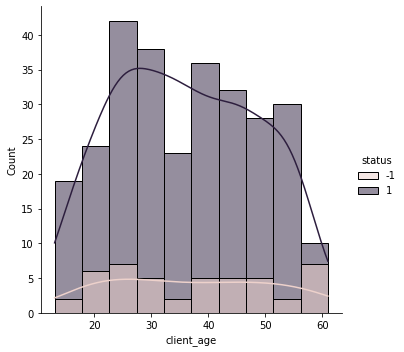

In [68]:
sb.displot(x="client_age", data=df, kde=True, hue="status")

<AxesSubplot:xlabel='client_age', ylabel='balance_mean'>

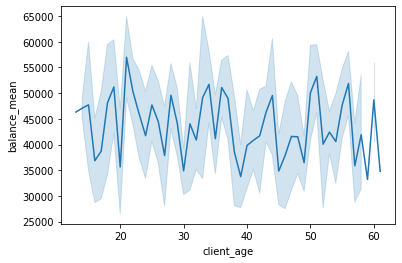

In [69]:
sb.lineplot(x="client_age", y="balance_mean", data=df)

There doesn't seem to be much balance differences between ages.

#### Discretize client ages

By observing the graphs above, we can detect age groups where the number of reject loans is higher.

In [70]:
# discretize ages
age_bins=[0, 20, 35, 56, 61, 150]
#age_bins_labels=['0-19', '20-34', '35-55', '56-60', 'retired']
age_bins_labels=['0-19', '20-34', '35-55', '56-60', 'retired']
def discretize_ages(df):
    df['client_age_disc'] = pd.cut(x=df['client_age'], bins=age_bins, labels=age_bins_labels)

discretize_ages(df)
discretize_ages(df_test)
df['client_age_disc']

0      35-55
1      20-34
2      56-60
3      35-55
4       0-19
       ...  
323    20-34
324    56-60
325    35-55
326    35-55
327    20-34
Name: client_age_disc, Length: 328, dtype: category
Categories (5, object): ['0-19' < '20-34' < '35-55' < '56-60' < 'retired']

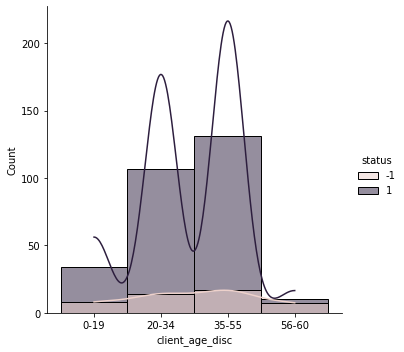

In [71]:
sb.displot(x="client_age_disc", data=df, kde=True, hue="status")

#### Deal with categorical client age discritization.

_client_age_ is a categorical value. Each category represents a range. This ranges can be divided into 2 attributes: the start and the end of the range.

In [72]:
def uncat_age_bins(df):
    def uncat_age_bins_inner(row, is_begin=True):
        age = row['client_age_disc']
        if age == 'retired':
            return 61 if is_begin else 150
        return age.split('-')[0 if is_begin else 1]
    
    df['age_start'] = df.apply(uncat_age_bins_inner, axis=1).astype(int)
    df['age_end'] = df.apply(lambda x: uncat_age_bins_inner(x, False), axis=1).astype(int)
    
uncat_age_bins(df)
uncat_age_bins(df_test)
df[["age_start", "age_end"]].head()

age_start  age_end
0         35       55
1         20       34
2         56       60
3         35       55
4          0       19

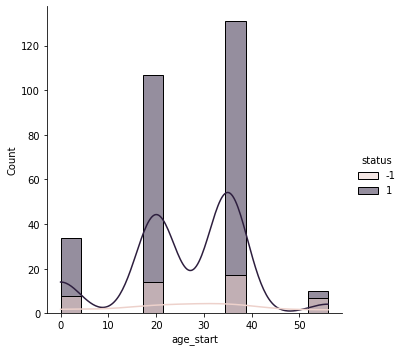

In [73]:
sb.displot(x="age_start", data=df, kde=True, hue="status")

Since there is a clear progression in ages, we can also encode this using label encoding.

In [74]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(age_bins_labels)

df["client_age_label"] = le.transform(df['client_age_disc'])
df_test["client_age_label"] = le.transform(df_test['client_age_disc'])
df["client_age_label"].head()

0    2
1    1
2    3
3    2
4    0
Name: client_age_label, dtype: int64

#### Attributes analysis

In [75]:
client_cols = ["birth_number", "is_male", "client_age", "age_start",
               "age_end", "client_age_label"]

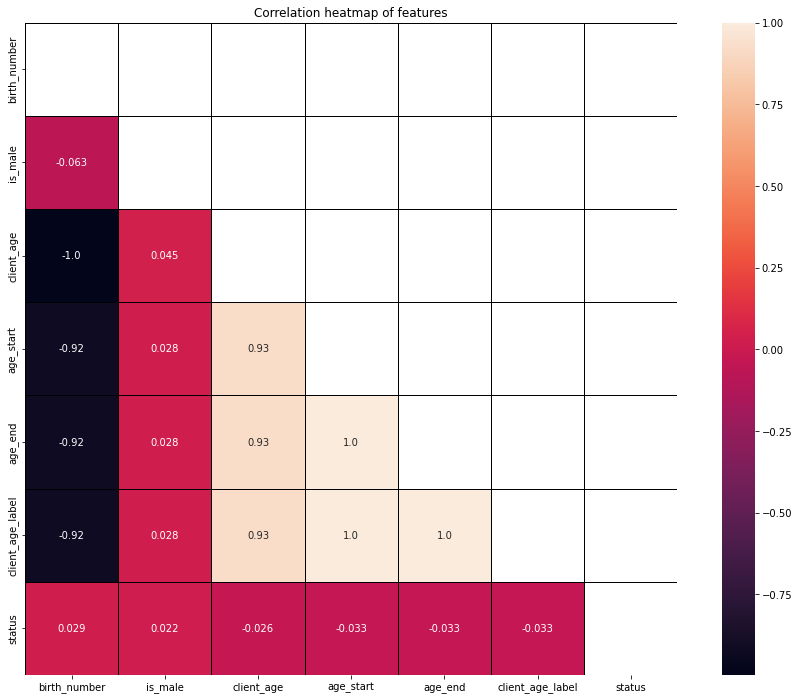

In [76]:
do_corr(client_cols + ["status"], annot=True)

In [77]:
do_anova(client_cols)

Features     Score
3         age_start  0.629296
5  client_age_label  0.471740
0      birth_number  0.354014
2        client_age  0.326128
1           is_male  0.164932
4           age_end  0.012323

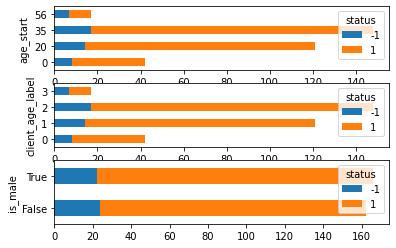

In [78]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_categorical_by_status(df, "age_start", axes[0])
plot_categorical_by_status(df, "client_age_label", axes[1])
plot_categorical_by_status(df, "is_male", axes[2])
plt.show()

None of the attributes refering to the client's information appear to be very correlated with the status. This means that they probably aren't very good attribute for our final model.  
The way we discretize the client's age appears to have improved the information, but not by much. The label encoded age doesn't show any improvements/worsing.

The _birth\_number_ will be dropped, because its information has already been processed.

In [79]:
df.drop(['birth_number', 'client_age', 'client_age_disc', 'client_age_label'], axis=1, inplace=True)
df_test.drop(['birth_number', 'client_age', 'client_age_disc', 'client_age_label'], axis=1, inplace=True)

The age attributes are highly correlated.

<AxesSubplot:xlabel='age_start', ylabel='age_end'>

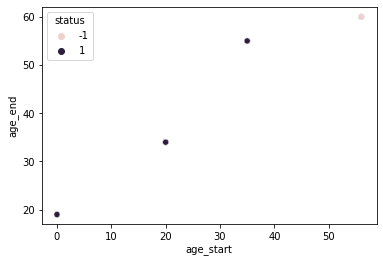

In [80]:
sb.scatterplot(x="age_start", y="age_end", data=df, hue="status")

These 2 attributes are indeed directly correlated. We can just keep the _age\_start_, since it scores higher on the ANOVA test.

In [81]:
df.drop(['age_end'], axis=1, inplace=True)
df_test.drop(['age_end'], axis=1, inplace=True)

### District

In [82]:
district_cols = ["district_code", "district_name", "region", "people_count",
               "muni_499_count", "muni_500-1999_count", "muni_2000-9999_count",
               "muni_10000_count", "cities_count", "ratio_urban_people",
               "avg_salary", "unemp_rate_95", "unemp_rate_96", "enterp_per1000",
               "crime_count_95", "crime_count_96"]

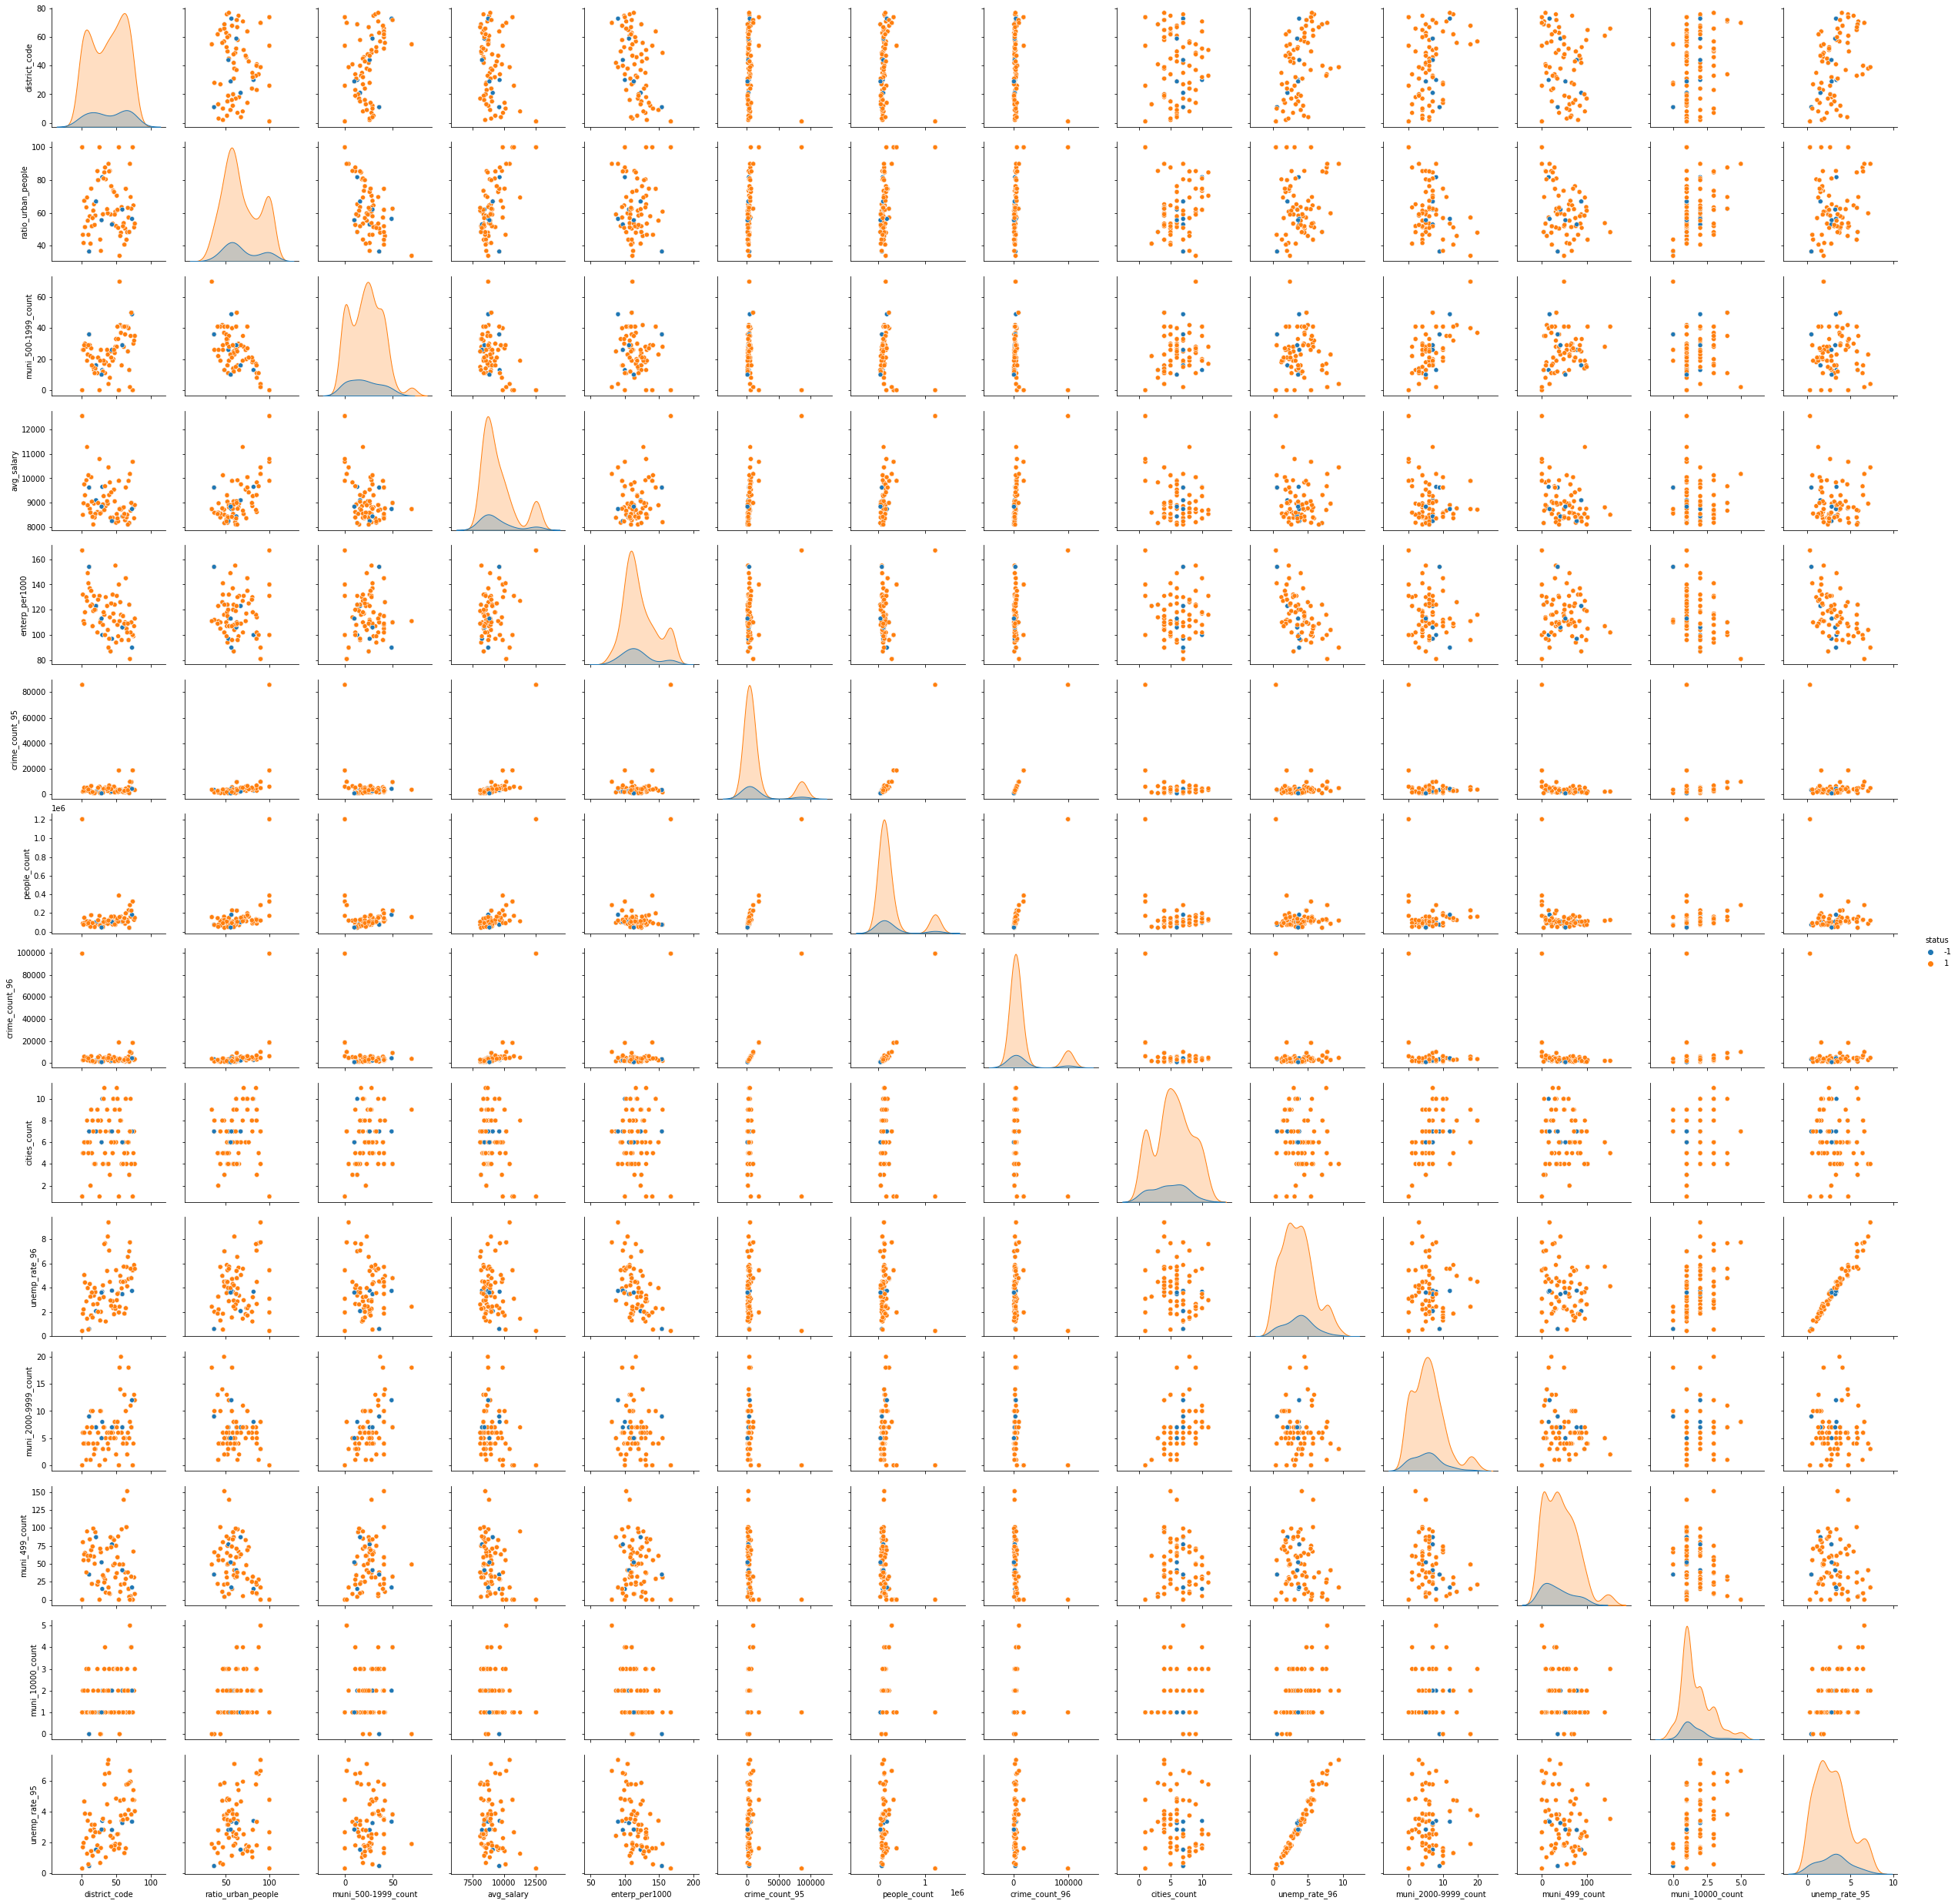

In [83]:
do_pairplot(district_cols)

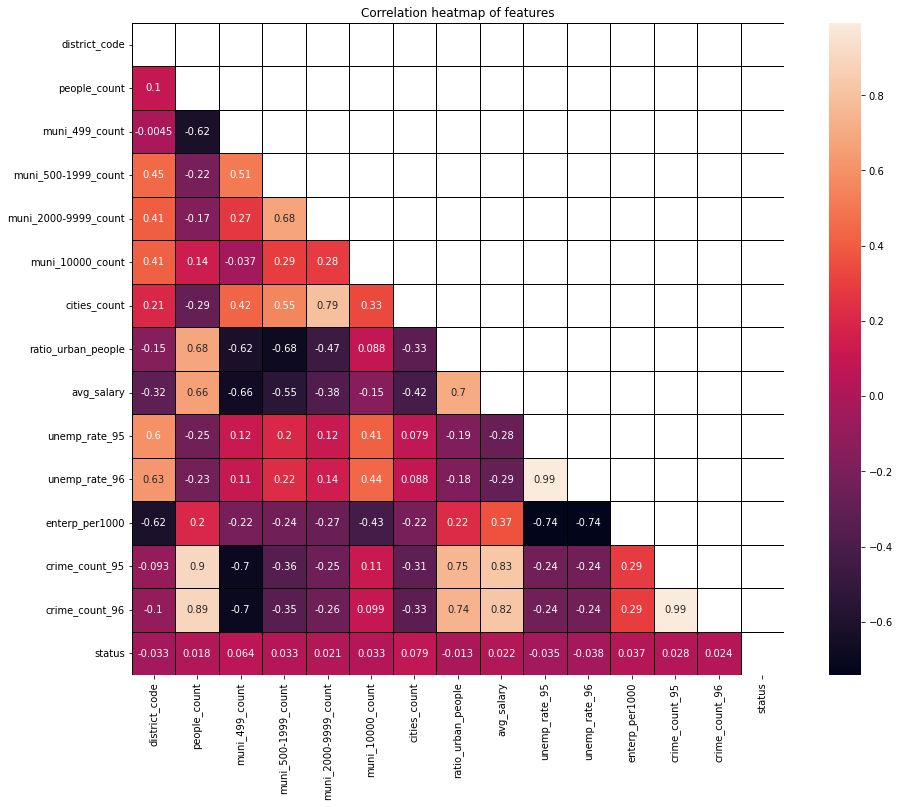

In [84]:
do_corr(district_cols, annot=True)

- The relation between the crime counts and the population counts needs to be analysed.
- The ratio of urban people appears to be correlated to the average salary. This can be, because salaries tend to be higher in cities.
- Since cities tend to have larger population counts, the relation between the salary and population size appears to make sense.
- The average salary is related to the number of crimes commited. Since can be, because more crimes are commited in cities.

#### Unemployment rate

<AxesSubplot:xlabel='unemp_rate_95', ylabel='unemp_rate_96'>

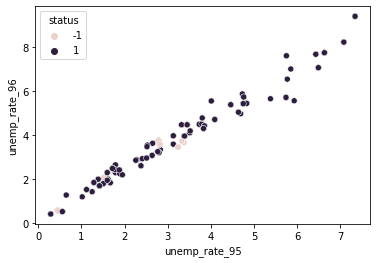

In [85]:
sb.scatterplot(x="unemp_rate_95", y="unemp_rate_96", data=df, hue="status")

The relation between the unemployment rated in 1995 and 1996 in nearlly linear (with few outliers from the trend).

From these two, we could drop the most recent (1996), as it is less likely to affect the loan decisions. This is because the decisions on loans were taken considering only data relative to before the loan was conceded.

We decided that this 2 attributes could be joined into a single one, _unem_growth_, representing the growth of the unemployment rate.

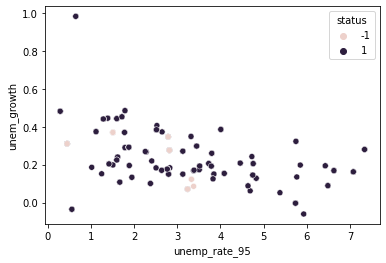

In [86]:
def unemp_rate(df, draw=True):
    df["unem_growth"] = (df["unemp_rate_96"]/df["unemp_rate_95"]) - 1.0
    if draw:
        sb.scatterplot(x="unemp_rate_95", y="unem_growth", data=df, hue="status")
    
unemp_rate(df)
unemp_rate(df_test, False)


        Features     Score
0  unemp_rate_95  0.270691
1  unemp_rate_96  0.238824
2    unem_growth  0.141490


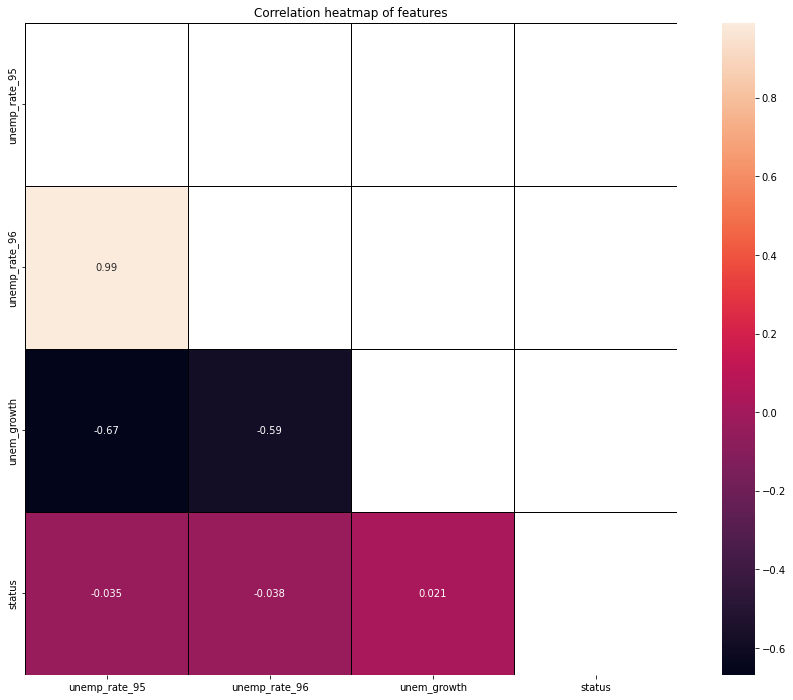

In [87]:
print(do_anova(["unemp_rate_95", "unemp_rate_96", "unem_growth"]))
do_corr(["unemp_rate_95", "unemp_rate_96", "unem_growth", "status"], annot=True)

None of these attributes seem to be very good. Still, we're going to keep the unemployment growth attribute.

In [88]:
df.drop(["unemp_rate_95", "unemp_rate_96"], axis=1, inplace=True)
df_test.drop(["unemp_rate_95", "unemp_rate_96"], axis=1, inplace=True)

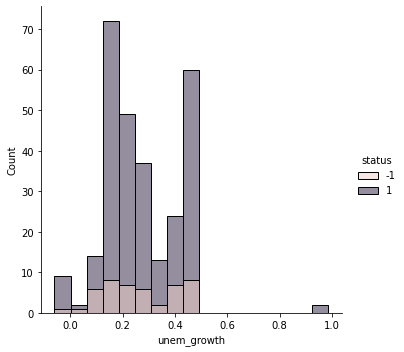

In [89]:
sb.displot(x="unem_growth", data=df, hue="status")

#### Crime count

Entries with more than 80000 crimes commited: 80


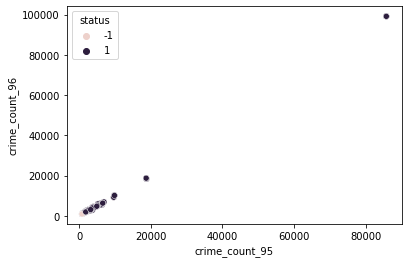

In [90]:
sb.scatterplot(x="crime_count_95", y="crime_count_96", data=df, hue="status")

print("Entries with more than 80000 crimes commited:",
      len(df[df["crime_count_95"] > 8000]))

Although there is a big gap increase on the total number of crimes commited after 20000 crimes, from the plot, it can be concluded that there is a approximatelly linear correlation between the number of crimes commited in 1995 and 1996.

There are 3 regions with a much higher number of commited crimes: Prague, south Moravia, north Moravia. Even in the case of these regions, the relation is almost linear.

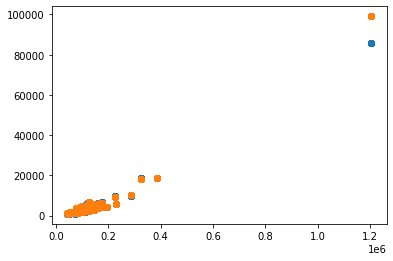

In [91]:
plt.scatter(df["people_count"], df["crime_count_95"])
plt.scatter(df["people_count"], df["crime_count_96"])

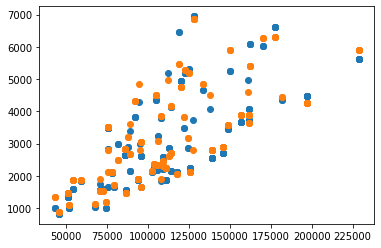

In [92]:
tmp = df[df["crime_count_95"] < 8000]
plt.scatter(tmp["people_count"], tmp["crime_count_95"])

tmp2 = df[df["crime_count_96"] < 8000]
plt.scatter(tmp2["people_count"], tmp2["crime_count_96"])

As expected, the higher the population, the more crimes are commited and this remains true for both years.

This means that it isn't a very useful information in this form. We can convert both crime counts to crime commited per 1000 habitants and use that to calculate the _crime growth_.

<AxesSubplot:xlabel='people_count', ylabel='crime_growth'>

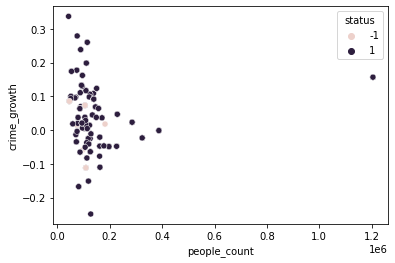

In [93]:
def crime_per1000(df):
    crime_per1000_95 = df["crime_count_95"] / (df["people_count"] / 1000)
    crime_per1000_96 = df["crime_count_96"] / (df["people_count"] / 1000)

    df["crime_growth"] = (crime_per1000_96/crime_per1000_95) - 1.0

crime_per1000(df)
crime_per1000(df_test)
sb.scatterplot(x="people_count", y="crime_growth", data=df, hue="status")

This new attribute, _crime\_growth_, isn't directly related to the population size.

         Features     Score
2    crime_growth  1.357676
0  crime_count_95  0.031563
1  crime_count_96  0.030833


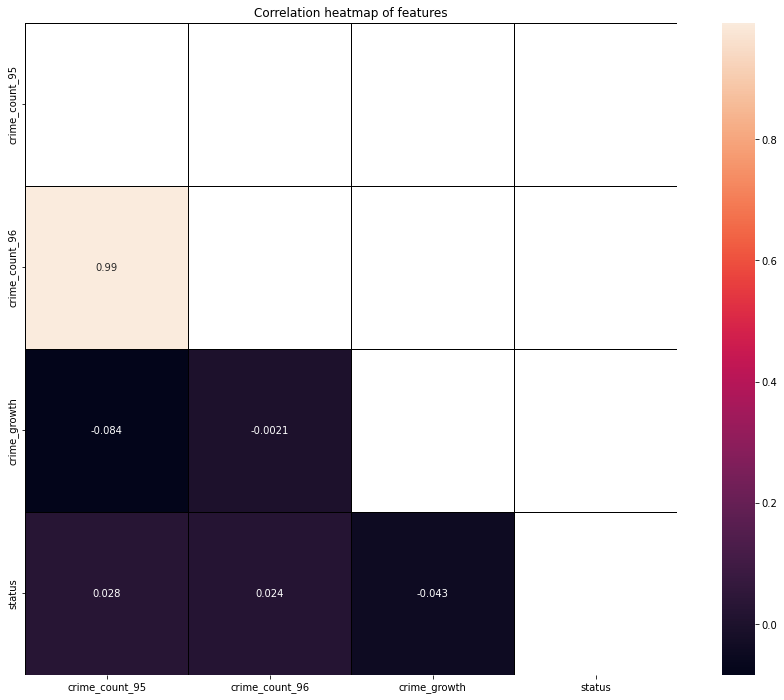

In [94]:
print(do_anova(["crime_count_95", "crime_count_96", "crime_growth"]))
do_corr(["crime_count_95", "crime_count_96", "crime_growth", "status"])

The crime growth attribute is a lot better than its counterparts (crime counts). We're going to drop the crime counts.

In [95]:
df.drop(["crime_count_95", "crime_count_96"], axis=1, inplace=True)
df_test.drop(["crime_count_95", "crime_count_96"], axis=1, inplace=True)

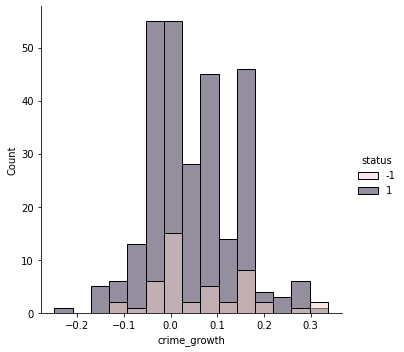

In [96]:
sb.displot(x="crime_growth", data=df, hue="status")

#### Skewness

Some attributes are heavily _skewed_. To take care of this, we apply `np.log` to the attribute.

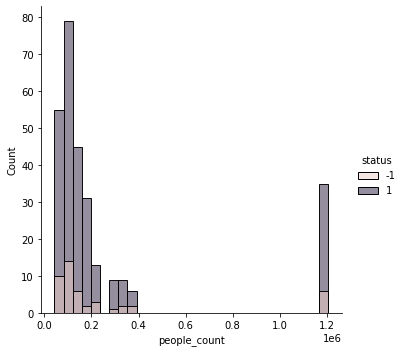

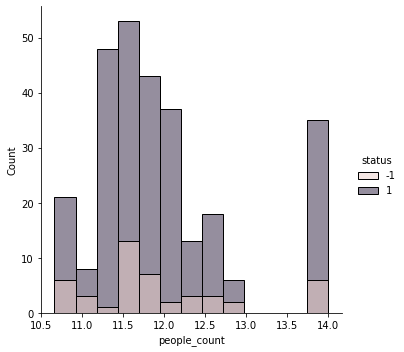

In [97]:
sb.displot(x="people_count", data=df, hue="status")

df["people_count"] = np.log(df["people_count"])
df_test["people_count"] = np.log(df_test["people_count"])
sb.displot(x="people_count", data=df, hue="status")

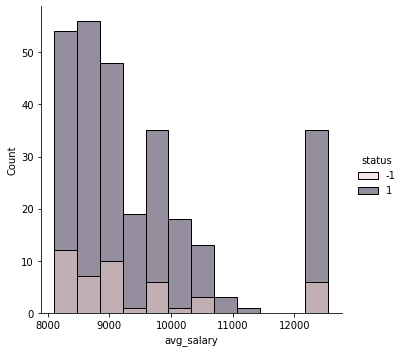

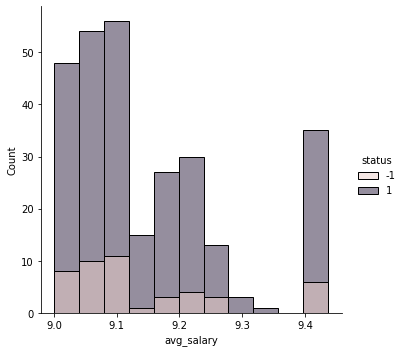

In [98]:
sb.displot(x="avg_salary", data=df, hue="status")

df["avg_salary"] = np.log(df["avg_salary"])
df_test["avg_salary"] = np.log(df_test["avg_salary"])
sb.displot(x="avg_salary", data=df, hue="status")

#### District categorical data

In [99]:
print("Number of different 'code' values:", len(df['district_code'].value_counts()))
print("Number of different 'name' values:", len(df['district_name'].value_counts()))

Number of different 'code' values: 73
Number of different 'name' values: 73


We can see that there is a direct association between the **code** and **name** attributes. This means they are redundant and we don't have to deal with the **name** attribute.

There is a problem with this. The **code** attributes are integers which indirectly imply an order, even though the names of the regions are nominal features. Using one-hot or binary enconding for this would generate too many attribute, so it was decided that target encoding would be used.

In [100]:
from category_encoders.cat_boost import CatBoostEncoder

st = df["status"]
st_test = df_test["status"]

enc = CatBoostEncoder(cols=['district_name'])
df = enc.fit_transform(df.drop('status', axis=1), df["status"])
df["status"] = st
df_test = enc.transform(df_test.drop('status', axis=1))
df_test["status"] = st_test

In [101]:
df.drop(['district_code'], axis=1, inplace=True)
df.rename(columns={'district_name': 'district'}, inplace=True)
df_test.drop(['district_code'], axis=1, inplace=True)
df_test.rename(columns={'district_name': 'district'}, inplace=True)

The **region** feature is categorial and there is no order associated. This means this attribute should be encoded in order to remove it's categorical nature and still remain unordered. One-Hot encoding could be used for simplicity, but other encondings are better.

In [102]:
df['region'].value_counts()

south Moravia      68
north Moravia      51
Prague             41
east Bohemia       40
central Bohemia    37
south Bohemia      31
west Bohemia       30
north Bohemia      30
Name: region, dtype: int64

In [103]:
from category_encoders.cat_boost import CatBoostEncoder

st = df["status"]
st_test = df_test["status"]

enc = CatBoostEncoder(cols=['region'])
df = enc.fit_transform(df.drop('status', axis=1), df["status"])
df["status"] = st
df_test = enc.transform(df_test.drop('status', axis=1))
df_test["status"] = st_test

df["region"]

0      0.719512
1      0.719512
2      0.859756
3      0.719512
4      0.719512
         ...   
323    0.504480
324    0.657317
325    0.514390
326    0.603855
327    0.523912
Name: region, Length: 328, dtype: float64

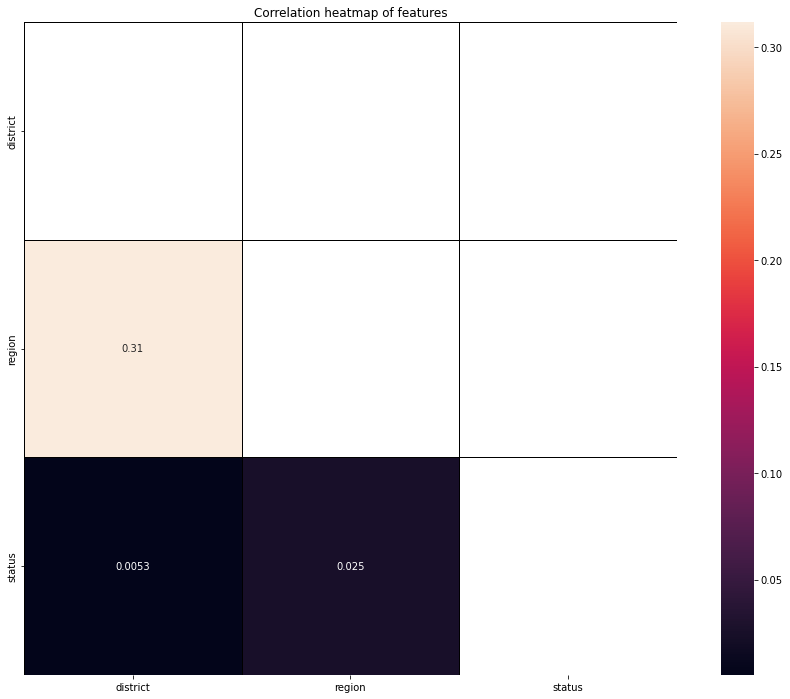

In [104]:
do_corr(["district", "region", "status"])

In [105]:
do_anova(["district", "region"])

Features     Score
1    region  0.557291
0  district  0.544936

These features do not appear to be very meaningful.

#### Feature analysis

In [106]:
district_cols = ["district", "region", "people_count",
                 "muni_499_count", "muni_500-1999_count",
                 "muni_2000-9999_count", "muni_10000_count",
                 "cities_count", "ratio_urban_people", "avg_salary",
                 "enterp_per1000", "unem_growth", "crime_growth"]

                Features     Score
7           cities_count  2.233981
3         muni_499_count  1.809475
12          crime_growth  1.357676
1                 region  0.557291
0               district  0.544936
6       muni_10000_count  0.527834
10        enterp_per1000  0.432246
4    muni_500-1999_count  0.408795
5   muni_2000-9999_count  0.293143
11           unem_growth  0.141490
9             avg_salary  0.080323
8     ratio_urban_people  0.046789
2           people_count  0.013515


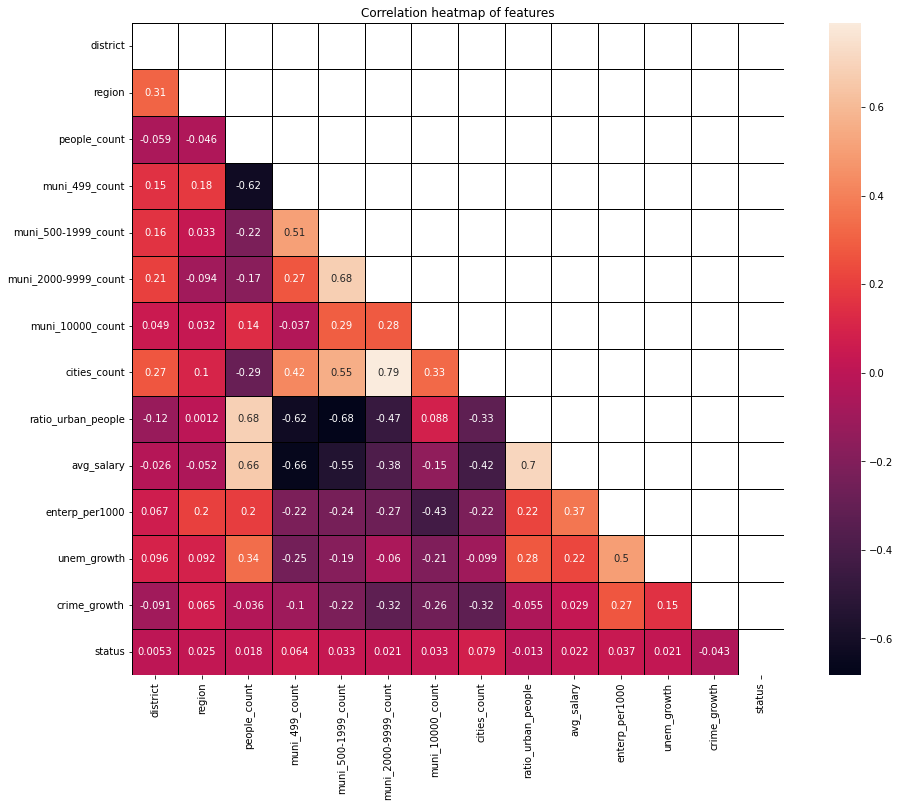

In [107]:
print(do_anova(district_cols))
do_corr(district_cols + ["status"])

- Although the _district_ and _region_ attributes aren't very correlated with the status, they have one of the highest scores on the ANOVA test from the listed attributes.
- Weirdly, the _muni\_499\_count_ attribute scores very highly on the ANOVA test.
- The _cities\_count_ and _crime\_growth_ attributes appear to be good predictors for the _status_.

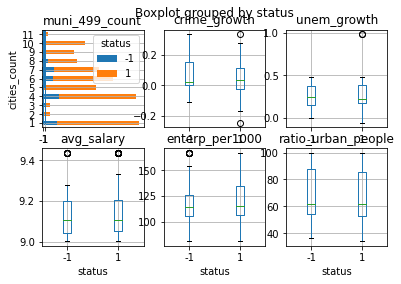

In [108]:
nr, nc = 2, 3
fig, axes = plt.subplots(nrows=nr, ncols=nc)
fig.tight_layout(pad=0.4)
plot_categorical_by_status(df, "cities_count", axes[0, 0])
box_plots = ["muni_499_count", "crime_growth", "unem_growth", "avg_salary", "enterp_per1000", "ratio_urban_people"]
i = 0
for attr in box_plots:
    df.boxplot(by="status", column=attr, ax=axes[i // nc, i % nc])
    i += 1
plt.show()

+ The *muni_499_count* attribute shows us that for some values (5 and 9), there is a high probability of the loan being accepted
+ Even thoguh *avg_salary* and *enterp_per1000* don't score high in the anove test, they may be influenced by outliers TODO
+ The *unem_growth*, *crime_grwoth* and *ratio_urban_people* don't seem to offer statiscal evidence that can help us distinguish the status

         Features     Score
0  muni_499_count  0.682761


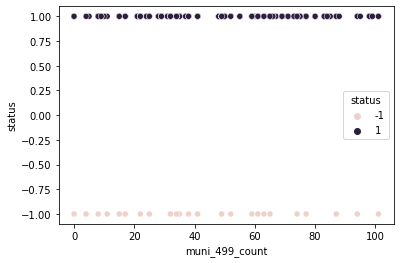

In [109]:
test_df = df.drop(df[df["muni_499_count"] > 120].index)
old_df = df
df = test_df
print(do_anova(["muni_499_count"]))
sb.scatterplot(x="muni_499_count", y="status", data=df, hue="status")
df = old_df

<AxesSubplot:xlabel='muni_499_count', ylabel='status'>

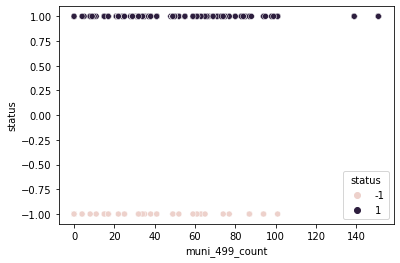

In [110]:
sb.scatterplot(x="muni_499_count", y="status", data=df, hue="status")

There are two **outliers** in the data above. Two abnormally high counts of municipalities with less than 500 population have been granted loans. This will probably mislead the model into thinking that these attributes and fenonemon has importante, and, as such, will be dropped.

In [111]:
df.drop(["muni_499_count"], axis=1, inplace=True)
df_test.drop(["muni_499_count"], axis=1, inplace=True)

Regions with lower city counts have higher peaks of loan requests. We can also see that the more loans there are, the more rejected loans appear aswell, and this percentage remains constant. There aren't many loan requests on regions with city counts between 2 and 4.  
Although this attribute scores well on the ANOVA test, it doesn't appear to have much statistical significance.

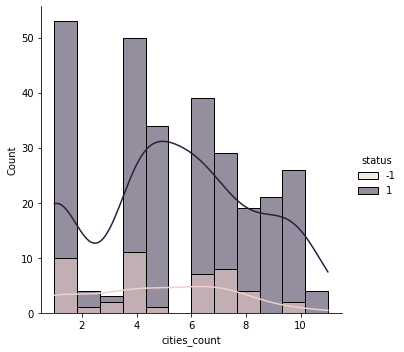

In [112]:
sb.displot(x="cities_count", data=df, hue="status", kde=True);

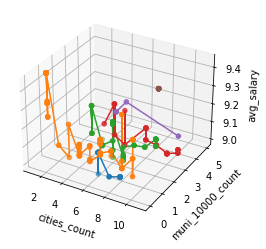

In [113]:
y = "muni_10000_count"
x = "cities_count"
z = "avg_salary"

figg = plt.figure()
ax = figg.add_subplot(111, projection='3d')
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
grouped = df.groupby(y)
for i, g in grouped:
    g = g.sort_values(by=x)
    ax.plot(g[x], g[y], g[z])
    ax.scatter(g[x], g[y], g[z])
plt.show();

### Transaction

In [114]:
trans_columns = ["sanctions", "household_mean", "interest_mean",
          "balance_min", "balance_max", "balance_mean",
          "balance_bellow_500", "balance_bellow_5k",
          "balance_lastmonth", "balance_lastsemester",
          "balance_lastyear"]

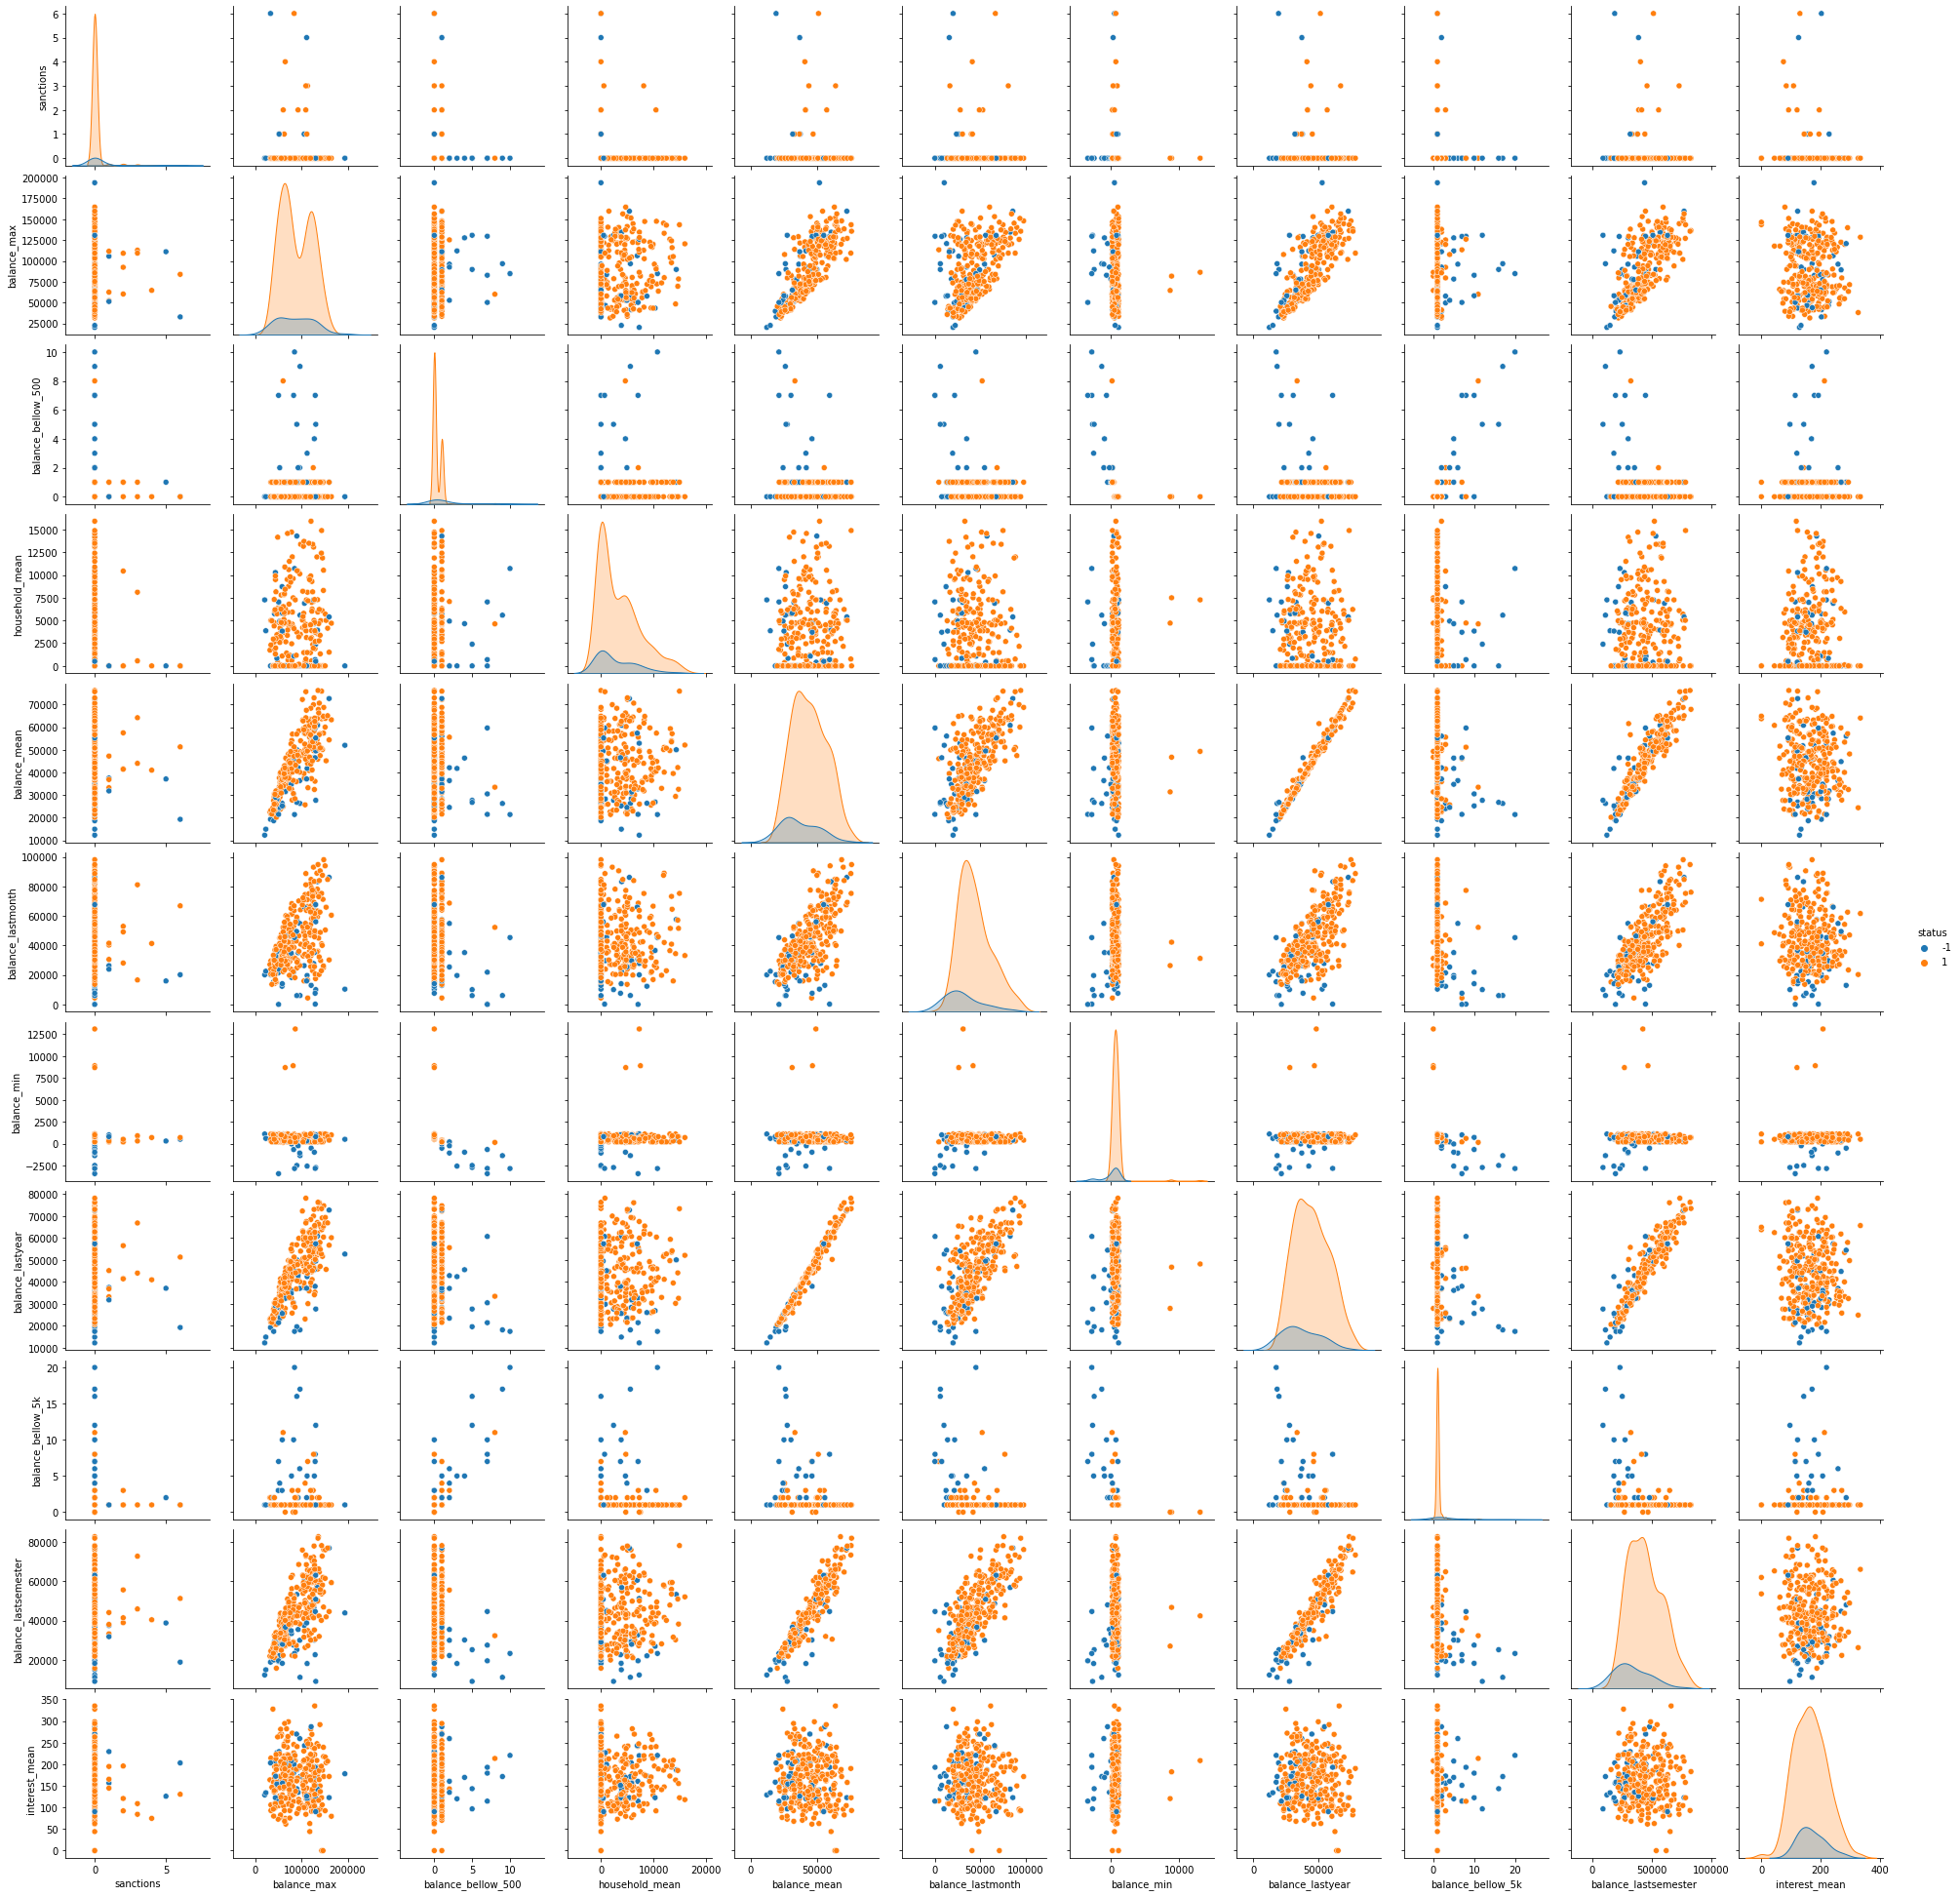

In [115]:
do_pairplot(trans_columns + ["status"])

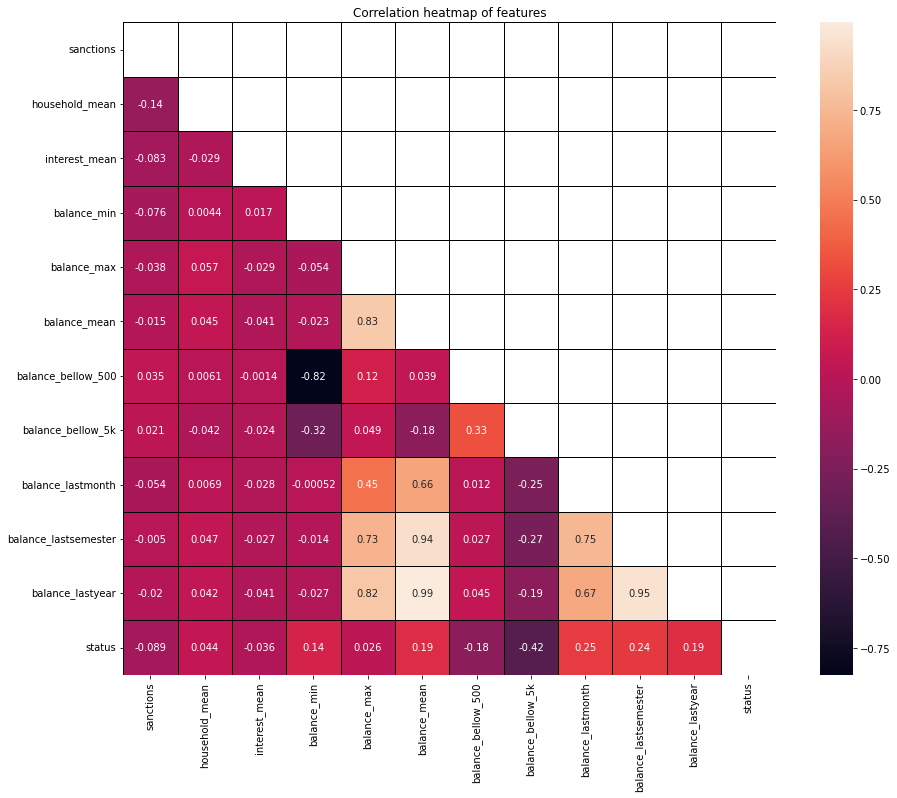

In [116]:
do_corr(trans_columns + ["status"])

- The balance\_mean is very correlated with the balance\_lastsemester, and balance\_lastyear.
- The balance\_bellow\_500 is negatively correlated with the balance\_min.
- The balance\_mean is very correlated with the balance\_max, which seems intuitive.

Some attributes are very correlated between themselves.

#### Balance bellow

<AxesSubplot:xlabel='balance_bellow_500', ylabel='balance_bellow_5k'>

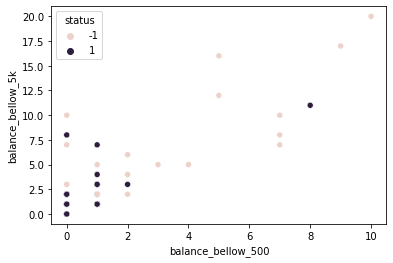

In [117]:
sb.scatterplot(x="balance_bellow_500", y="balance_bellow_5k", data=df, hue="status")

Although these attributes are correlated, they aren't correlated enough for us to do anything.

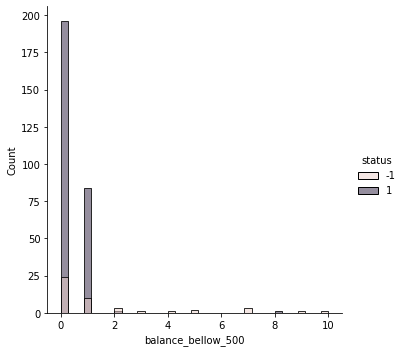

In [118]:
sb.displot(x="balance_bellow_500", data=df, hue="status")

It appears that most clients with higher numbers of times where their balance dropped bellow 500 gets their loans rejected.

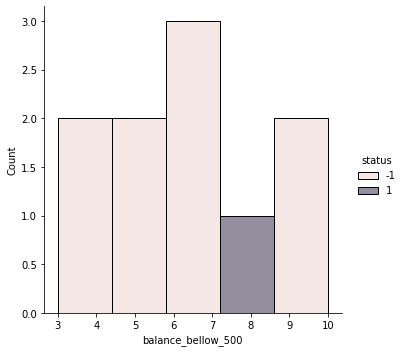

In [119]:
sb.displot(x="balance_bellow_500", data=df[df["balance_bellow_500"] > 2], hue="status")

There is a clear **outlier** here.

#### Balance bellow 500 and balance min

<AxesSubplot:xlabel='balance_bellow_500', ylabel='balance_min'>

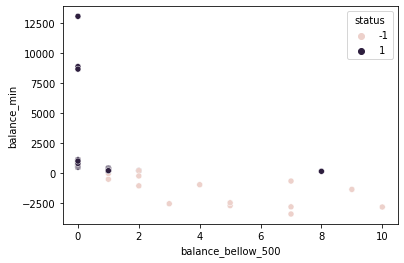

In [120]:
sb.scatterplot(x="balance_bellow_500", y="balance_min", data=df, hue="status")

It looks like that people with higher frequency of low balances also have lower minimum balances.

<AxesSubplot:xlabel='balance_bellow_500', ylabel='balance_min'>

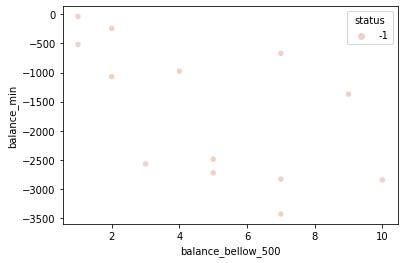

In [121]:
sb.scatterplot(x="balance_bellow_500", y="balance_min", data=df[df["balance_min"] < 0], hue="status")

All clients that had negative balances in their account had their loan requests refused.

#### Mean balances

There are 4 attributes relating to the account's mean balance: last month, last semester, last year, and in total. From these, the most important appears to be the balance on the last semester.

In [122]:
do_anova(["balance_mean", "balance_lastyear", "balance_lastsemester", "balance_lastmonth"])

Features      Score
2  balance_lastsemester  21.605027
3     balance_lastmonth  19.635187
1      balance_lastyear  13.901899
0          balance_mean  12.747115

It appears that more recent data is more important to the model, but data on the last month isn't the most reliable.

<AxesSubplot:xlabel='balance_mean', ylabel='balance_lastyear'>

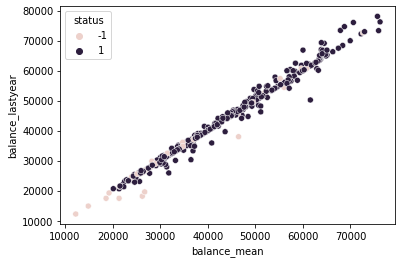

In [123]:
sb.scatterplot(x="balance_mean", y="balance_lastyear", data=df, hue="status")

<AxesSubplot:xlabel='balance_mean', ylabel='balance_lastsemester'>

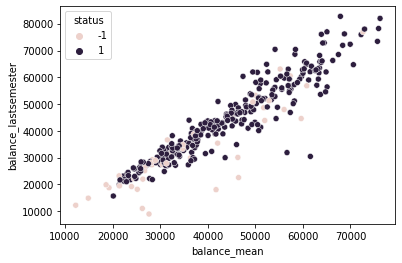

In [124]:
sb.scatterplot(x="balance_mean", y="balance_lastsemester", data=df, hue="status")

The last month is a lot more erratic.

<AxesSubplot:xlabel='balance_mean', ylabel='balance_lastmonth'>

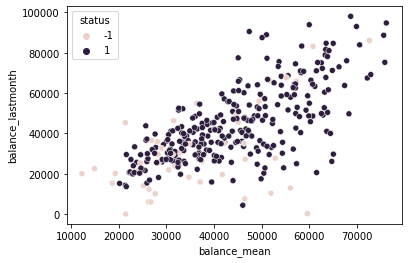

In [125]:
sb.scatterplot(x="balance_mean", y="balance_lastmonth", data=df, hue="status")

<AxesSubplot:xlabel='balance_lastsemester', ylabel='balance_lastmonth'>

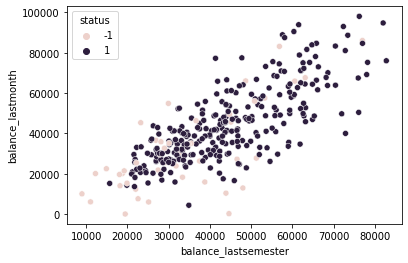

In [126]:
sb.scatterplot(x="balance_lastsemester", y="balance_lastmonth", data=df, hue="status")

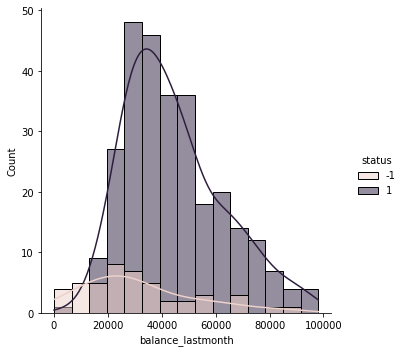

In [127]:
sb.displot(x="balance_lastmonth", data=df, hue="status", kde=True)

<AxesSubplot:title={'center':'balance_lastmonth'}, xlabel='status'>

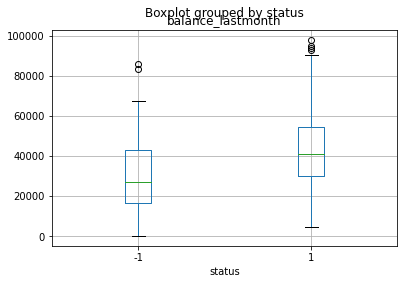

In [128]:
df.boxplot(by="status", column="balance_lastmonth")

There is an **outlier** who had his loan accepted to the left of the graph.

We can create 3 attributes that relate the deviation from the mean for the 3 time periods: last month, last semester, last year.

                      Features      Score
1  balance_growth_lastsemester  21.879819
0      balance_growth_lastyear   7.345737
2     balance_growth_lastmonth   7.302655


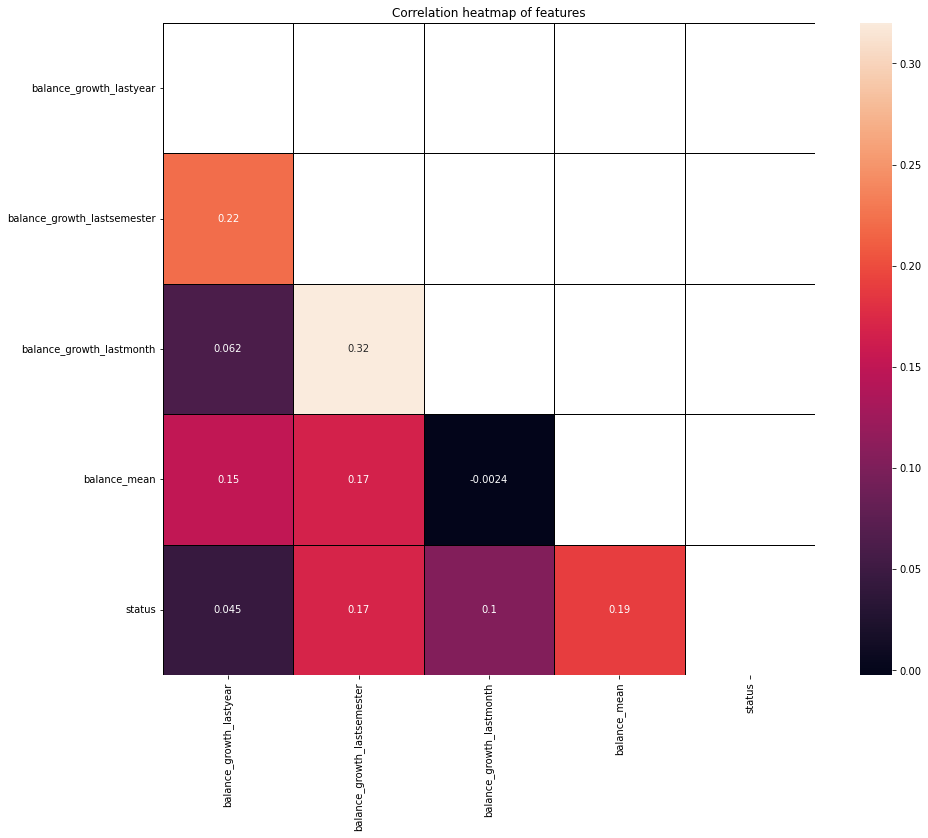

In [129]:
def balance_growths(df):
    df["balance_growth_lastyear"] = (df["balance_lastyear"] / df["balance_mean"]) - 1.0
    df["balance_growth_lastsemester"] = (df["balance_lastsemester"] / df["balance_mean"]) - 1.0
    df["balance_growth_lastmonth"] = (df["balance_lastmonth"] / df["balance_mean"]) - 1.0
    df.drop(["balance_lastyear", "balance_lastsemester", "balance_lastmonth"], axis=1, inplace=True)

balance_growths(df)
balance_growths(df_test)
print(do_anova(["balance_growth_lastyear", "balance_growth_lastsemester",
         "balance_growth_lastmonth"]))
do_corr(["balance_growth_lastyear", "balance_growth_lastsemester",
         "balance_growth_lastmonth", "balance_mean", "status"], annot=True)

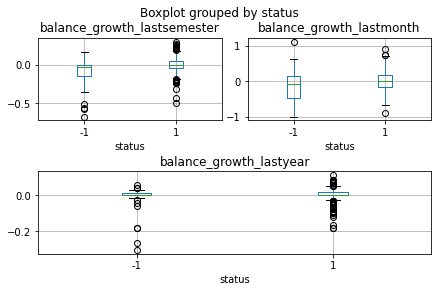

In [130]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
df.boxplot(by="status", column="balance_growth_lastsemester", ax=ax1)
df.boxplot(by="status", column="balance_growth_lastmonth", ax=ax2)
df.boxplot(by="status", column="balance_growth_lastyear", ax=ax3)
plt.tight_layout(pad=0.4)
plt.show()

### Account

#### Separate year and month

In [131]:
def account_ym(df):
    df['year_acc'] = df['account_creation'].apply(parseYear)
    df['month_acc'] = df['account_creation'].apply(parseMonth)

account_ym(df)
account_ym(df_test)
df[['month_acc', 'year_acc']].head()

month_acc  year_acc
0          3        93
1          2        93
2          2        93
3          1        93
4          2        93

#### Account age at time of loan

In [132]:
def acc_age(df):
    df["account_age"] = (df["loan_date"]//10000) - df["year_acc"]

acc_age(df)
acc_age(df_test)
df["account_age"]

0      0
1      0
2      0
3      0
4      0
      ..
323    1
324    1
325    0
326    1
327    1
Name: account_age, Length: 328, dtype: int64

#### Issuance frequency

The frequency is categorical data. Let's look at the cardinality of the attribute and whether it has an implicit order.

In [133]:
df['issuance_freq'].value_counts()

monthly issuance              259
weekly issuance                51
issuance after transaction     18
Name: issuance_freq, dtype: int64

There are 3  possible values for the **frquency attribute**: _monthly issuance_, _weekly issuance_, _issuance_ after transation. There is an implicit order between weekly and monthly, but with _issuance after transation_ it isn't so obvious. It was decided that, since it is expected that people do more than 1 transaction per week, _issuance after transation_ also relates to the other 2 in terms of time.

When considering the time intervals between transations: _issuance after transation_ < _weekly issuance_ < _monthly issuance_.

There is also a magnitude difference between all of them, e.g.: monthly is around 4 times more frequent than weekly. This raises the issue of how much more frequent is _issuance after transaction_ than _weekly issuance_. Let's assume the _weekly issuance_ is 7 time less frequent.

Let's replace this categorical data by ordered integers:

In [134]:
def issuance_cat(df):
    df.replace({'issuance_freq':
                {'issuance after transaction': 1,
                 'weekly issuance': 7,
                 'monthly issuance': 30}
               }, inplace=True)

issuance_cat(df)
issuance_cat(df_test)
df['issuance_freq']

0       7
1      30
2      30
3      30
4       7
       ..
323    30
324    30
325    30
326    30
327    30
Name: issuance_freq, Length: 328, dtype: int64

#### Anova test

In [135]:
do_anova(['month_acc', 'year_acc', "account_age",
          "account_creation", "issuance_freq"])

Features     Score
0         month_acc  3.457941
4     issuance_freq  1.807382
1          year_acc  0.946966
2       account_age  0.915041
3  account_creation  0.844121

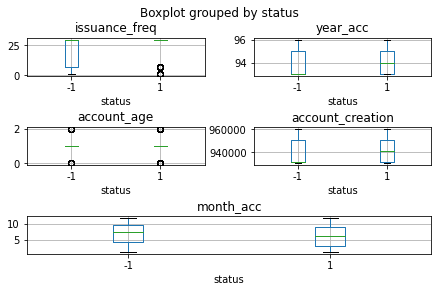

In [136]:
fig = plt.figure()
ax1 = fig.add_subplot(313)
ax2 = fig.add_subplot(321)
ax3 = fig.add_subplot(322)
ax4 = fig.add_subplot(323)
ax5 = fig.add_subplot(324)
df.boxplot(by="status", column="month_acc", ax=ax1)
df.boxplot(by="status", column="issuance_freq", ax=ax2)
df.boxplot(by="status", column="year_acc", ax=ax3)
df.boxplot(by="status", column="account_age", ax=ax4)
df.boxplot(by="status", column="account_creation", ax=ax5)
plt.tight_layout(pad=0.4)
plt.show()

The most important attributes appear to be the _month\_acc_ and the _issuance\_freq_.

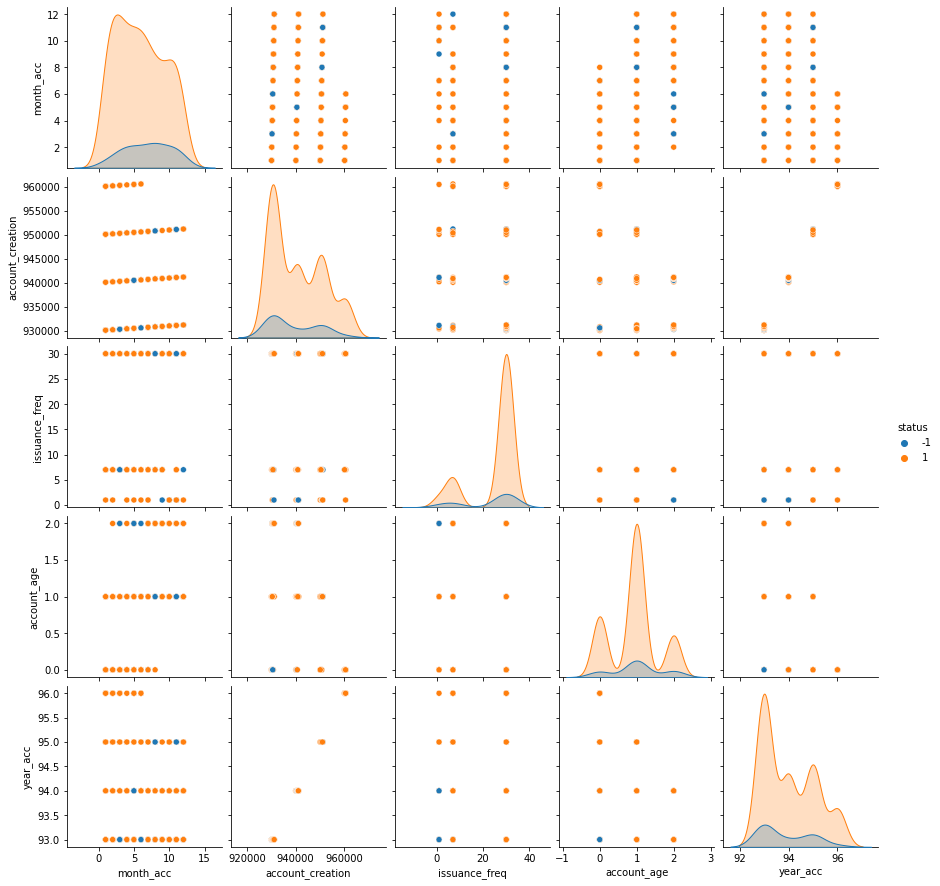

In [137]:
do_pairplot(['month_acc', 'year_acc', "account_age", "account_creation", "issuance_freq"])

The attributes aren't very correlated, with the exception of the year and date of the account creation (as expected), but these will be dropped.

In [138]:
df.drop(['year_acc', "account_creation"], axis=1, inplace=True)
df_test.drop(['year_acc', "account_creation"], axis=1, inplace=True)

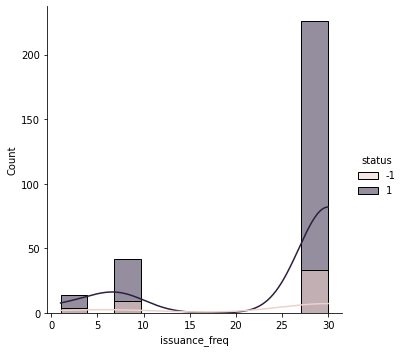

In [139]:
sb.displot(x="issuance_freq", data=df, hue="status", kde=True)

This attribute is skewed, but we can't do anything about it.

### Disposition

     Features      Score
0  is_coowned  16.565041


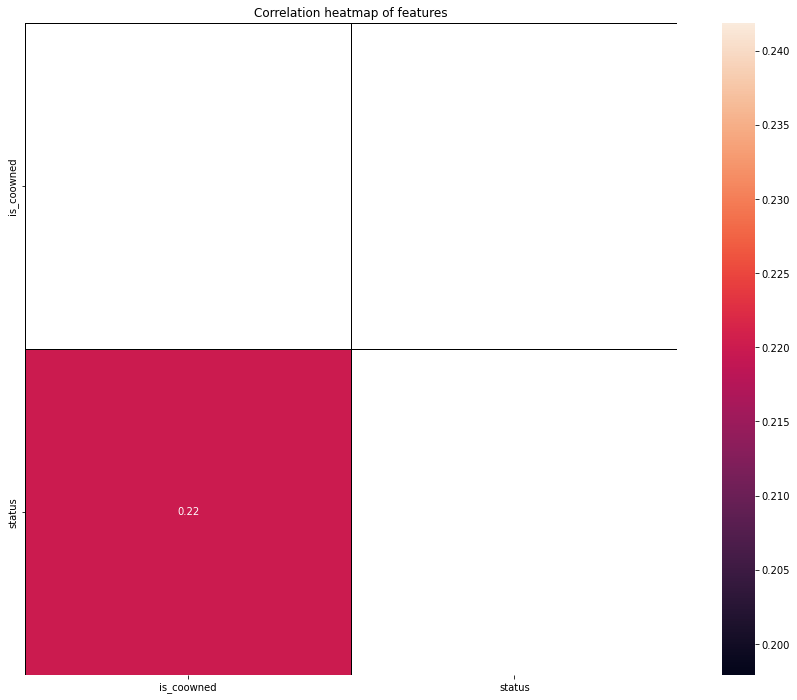

In [140]:
print(do_anova(["is_coowned"]))
do_corr(["is_coowned", "status"], annot=True)

This attribute is not very correlated with the loan status, but scores highly on the ANOVA test.

### Card

  Features     Score
0    cards  1.745876


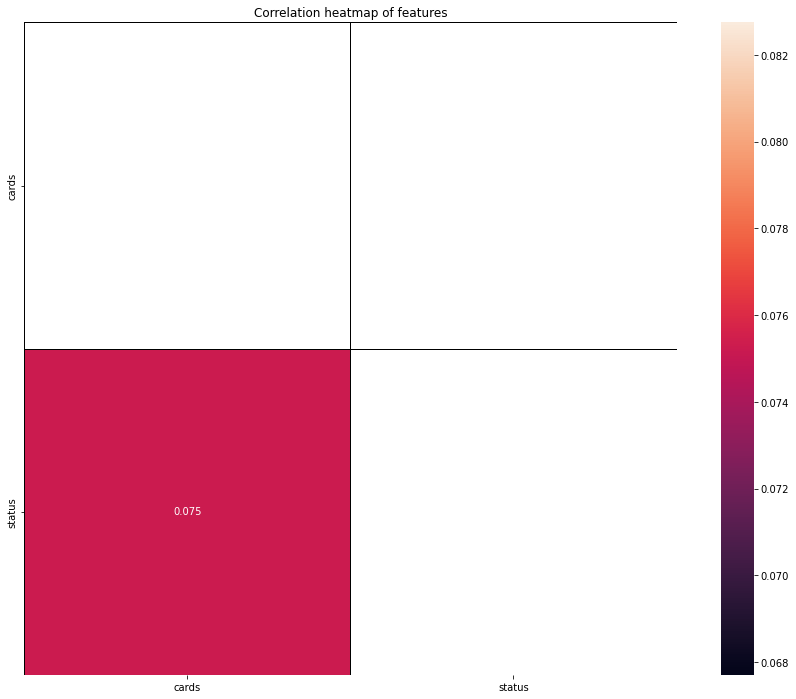

In [141]:
print(do_anova(["cards"]))
do_corr(["cards", "status"])

The number of cards in an account doesn't appear to be the best attribute.

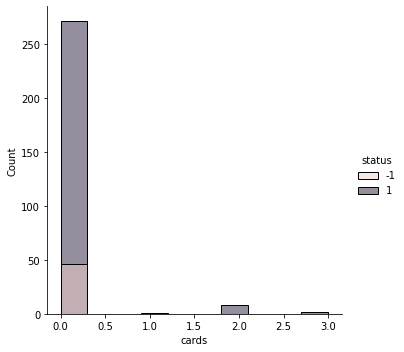

In [142]:
sb.displot(x="cards", data=df, hue="status")

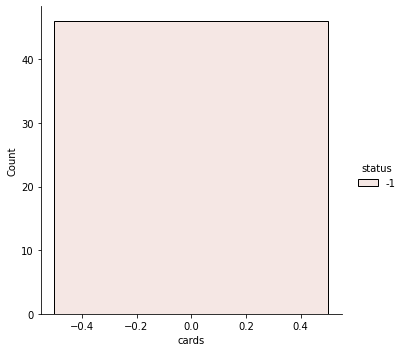

In [143]:
sb.displot(x="cards", data=df[df["status"] == -1], hue="status")

Every rejected loan in the dataset was associated with an account that didn't have any cards. This result isn't very significant, because most accounts on the dataset didn't have a card associated, so this result might have happen by chance.  
With this, this attribute should be dropped.

In [144]:
df.drop(["cards"], axis=1, inplace=True)
df_test.drop(["cards"], axis=1, inplace=True)

### Loan

In [145]:
loan_columns = ["loan_date", "amount", "duration", "payments"]

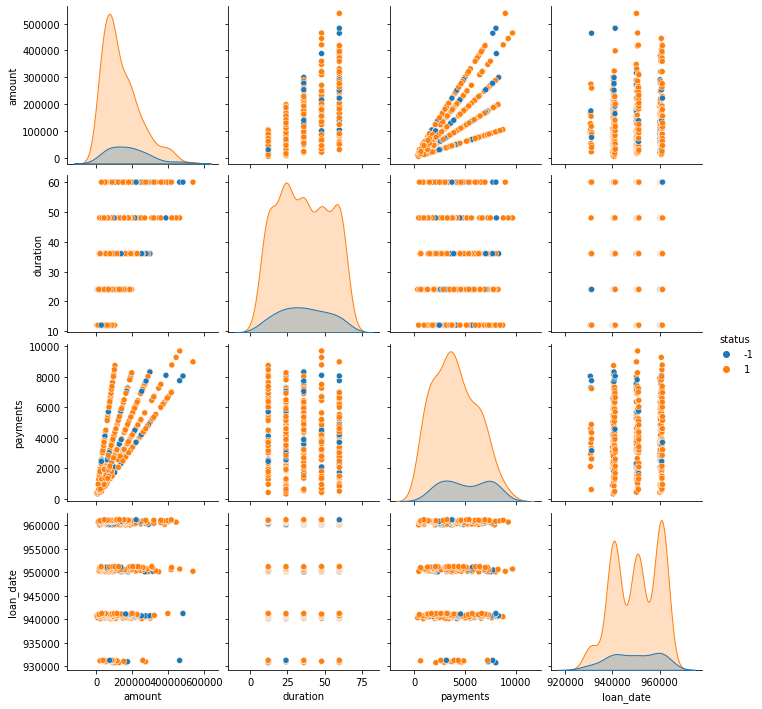

In [146]:
do_pairplot(loan_columns)

/home/ines/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


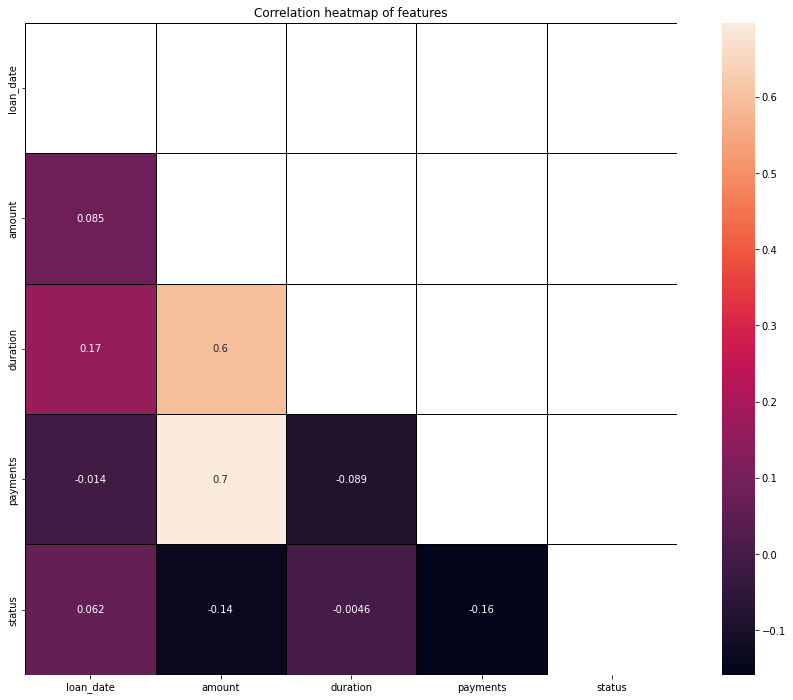

In [147]:
do_anova(loan_columns)
do_corr(loan_columns)

#### Loan date

Separa the loan date into a month and year, so it can be explored later: maybe more loans are granted during winter or summer time.

In [148]:
# separate the loan date into loan year and loan month
def loan_ym(df):
    df['year_loan'] = df['loan_date'].apply(parseYear)
    df['month_loan'] = df['loan_date'].apply(parseMonth)
    
loan_ym(df)
loan_ym(df_test)

In [149]:
do_anova(["loan_date", "year_loan", "month_loan"])

Features     Score
2  month_loan  5.804730
0   loan_date  0.276866
1   year_loan  0.193184

<AxesSubplot:xlabel='year_loan', ylabel='count'>

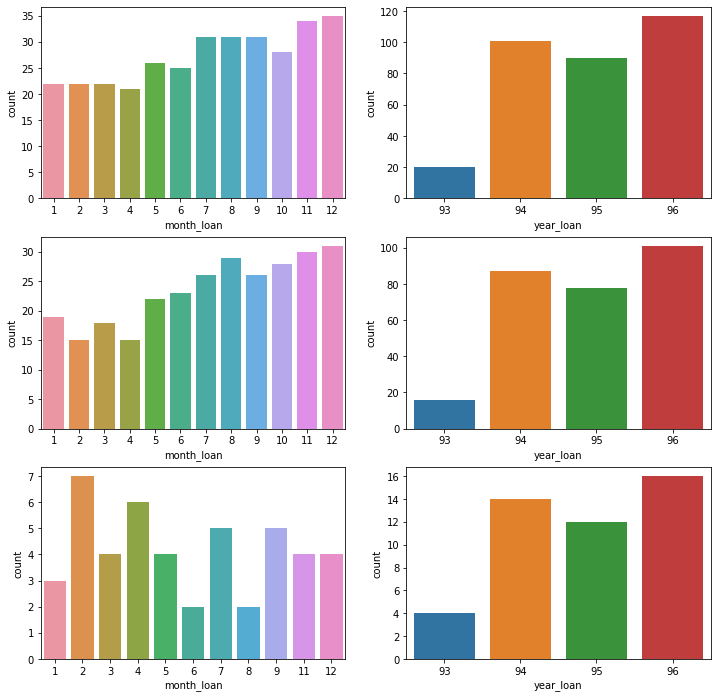

In [150]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12, 12)
sb.countplot(data=df, x='month_loan', ax=ax[0][0])
sb.countplot(data=df, x='year_loan', ax=ax[0][1])
sb.countplot(data=df[df["status"] == 1], x='month_loan', ax=ax[1][0])
sb.countplot(data=df[df["status"] == 1], x='year_loan', ax=ax[1][1])
sb.countplot(data=df[df["status"] == -1], x='month_loan', ax=ax[2][0])
sb.countplot(data=df[df["status"] == -1], x='year_loan', ax=ax[2][1])


The proportion of accepted/declined loans per year doesn't suffer many changes. We can see that the trend is that there are more loan requests the deeper into the year we are. More loans are accepted towards the end of the year, but the rejected loans show a somewhat erractic behavior.

We will drop both _loan\_date_ fields as the information has been extracted.

In [151]:
df.drop(["loan_date"], axis=1, inplace=True)
df_test.drop(["loan_date"], axis=1, inplace=True)

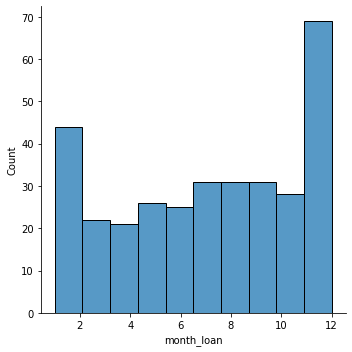

In [152]:
sb.displot(df["month_loan"])

The loan month isn't very skewed

#### Loan amount

<AxesSubplot:ylabel='amount'>

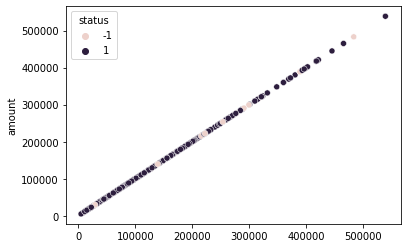

In [153]:
sb.scatterplot(x=df["payments"] * df["duration"], y="amount", data=df, hue="status")


The loan amount is equal to its duration times the payments. We can see that they are very correlated.

In [154]:
do_anova(["payments", "duration", "amount"])

Features     Score
0  payments  9.518871
2    amount  5.450596
1  duration  0.004079

The duration has a very low correlation with the status, but both _amount_ and _payments_ have a decent correlation with the _status_.

<AxesSubplot:xlabel='payments', ylabel='amount'>

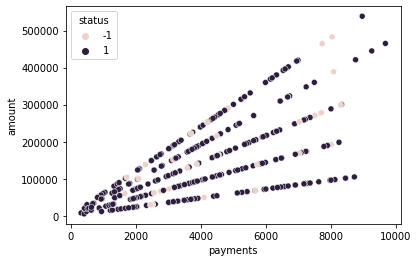

In [155]:
sb.scatterplot(x="payments", y="amount", data=df, hue="status")

<AxesSubplot:xlabel='duration', ylabel='payments'>

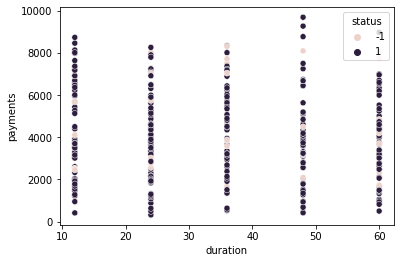

In [156]:
sb.scatterplot(x="duration", y="payments", data=df, hue="status")

The duration doesn't appear to add any statistical significance to the data, so the loan amount isn't as important as the loan individual payments. For that, the amount is dropped (high correlation).  
The duration is also dropped since it appears to bring no value to the model.

In [157]:
df.drop(["amount", "duration"], axis=1, inplace=True)
df_test.drop(["amount", "duration"], axis=1, inplace=True)

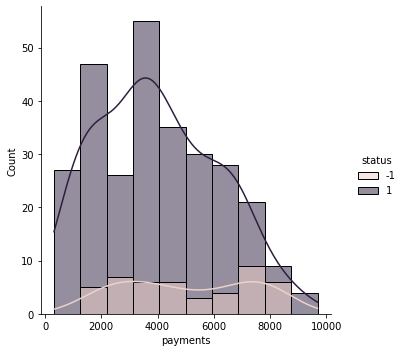

In [158]:
sb.displot(x=df["payments"], data=df, hue="status", kde=True)

Neither attribute is very skewed.

## Dealing with outliers

We can analyse outliers using DBSCAN with all features

In [159]:
from sklearn.cluster import DBSCAN

def DB_outliers(df, eps, min_samples): # Adapted from https://donernesto.github.io/blog/outlier-detection-with-dbscan/
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(df)

    labels = np.zeros(len(db.labels_))
    
    # make a list of tuples: (i, num points in i) for i in db.labels_
    label_counts = [(i, np.sum(db.labels_==i)) for i in set(db.labels_) - set([-1])]
    label_counts.sort(key=lambda x : -x[1]) # sort by counts per class, descending
    
    # assign the labels. Those points with label =-1 get highest label (equal to number of classes -1) 
    labels[db.labels_== -1] = len(set(db.labels_)) - 1
    for i, (label, label_count) in enumerate(label_counts):
        labels[db.labels_==label] = i

    # Scale the values between 0 and 1
    labels = (labels - min(labels)) / (max(labels) - min(labels))
    print("Num Clusters:" + str(len(set(labels))))
    print("Size Outliers:" + str(np.sum(labels == 1)))

As a rule of thumb the number of min_samples should be number of Dimensions * 2.
A k-distance-graph will be used to calculate the optimal ε for the algorithm.

Paper: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

Source: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [160]:
from sklearn.neighbors import NearestNeighbors

def k_distance_plot(df, min_samples):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

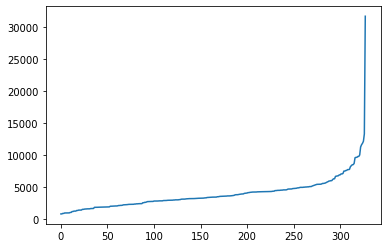

In [161]:
k_distance_plot(df, len(df.columns) * 2)

In [162]:
DB_outliers(df, 14000, len(df.columns) * 2)

Num Clusters:3
Size Outliers:90


In [163]:
100 * 90 / len(df)

27.4390243902439

DBSCAN tells us that 27% of our data are outliers. Let's analyse each relevant table separately.

### Account data

Using DBSCAN in a small number of features (3) is not recommended, so we will use plots instead to analyse outlier data.

In [164]:
account_columns = ['account_age', 'month_acc', 'issuance_freq']

<AxesSubplot:xlabel='month_acc', ylabel='Count'>

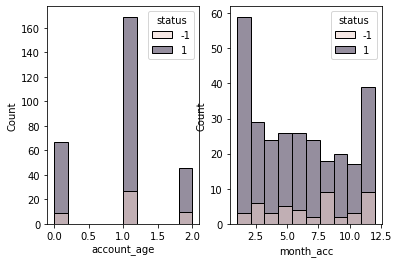

In [165]:
fig, axes = plt.subplots(nrows=1, ncols=2)
sb.histplot(hue="status", x="account_age", data=df, ax=axes[0])
sb.histplot(hue="status", x="month_acc", data=df, ax=axes[1])

We can conclude that there isn't outliers for these attributes.

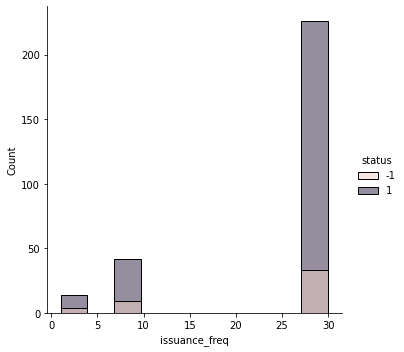

In [166]:
sb.displot(hue="status", x="issuance_freq", data=df)

-1
1


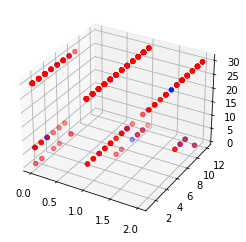

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
grouped = df.groupby("status")
colors = {-1 : "blue", 1: "red"}
for i, g in grouped:
    print(i)
    ax.scatter(g['account_age'], g['month_acc'], g['issuance_freq'], color=colors[i])
plt.show()

We can conclude that there isn't an isolated outlier value. 
Instead, small clusters with a mixture of -1 and 1 status values can be found.
We decided not treat these as outlier values.

### Transaction data

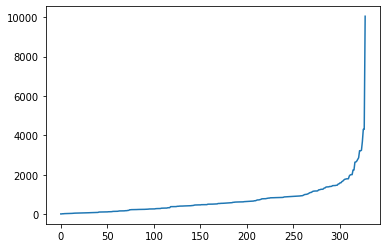

In [168]:
trans_columns = ["balance_growth_lastyear", "balance_growth_lastsemester", "balance_growth_lastmonth",
                 "balance_mean", "balance_bellow_500", "balance_bellow_5k", "household_mean",
                 "sanctions", "interest_mean"]
k_distance_plot(df[trans_columns], len(trans_columns) * 2)

In [169]:
DB_outliers(df[trans_columns], 4000, len(trans_columns) * 2)

Num Clusters:2
Size Outliers:36


This suggests that few outliers are caused by these attributes, so we won't analyse them further.

### District data

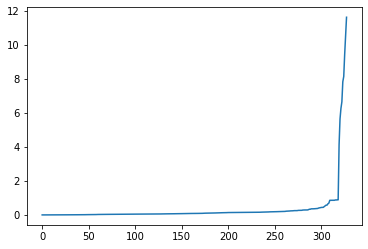

In [170]:
district_cols = ["district", "region", "people_count", "muni_500-1999_count",
                 "muni_2000-9999_count", "muni_10000_count",
                 "cities_count", "ratio_urban_people", "avg_salary",
                 "enterp_per1000", "unem_growth", "crime_growth"]

k_distance_plot(df[district_cols], len(district_cols) * 2)

In [171]:
DB_outliers(df[district_cols], 1, len(district_cols) * 2)

Num Clusters:2
Size Outliers:287


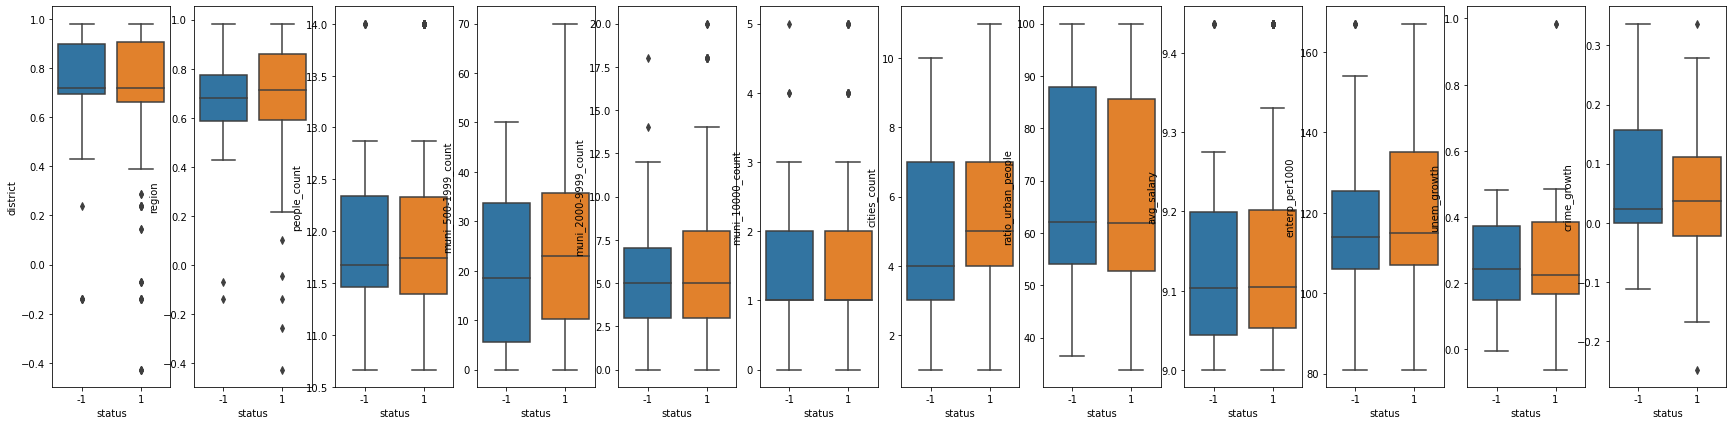

In [172]:
def box_plot(df, y, ax):
    sb.boxplot(x="status", y=y, data=df, ax=ax)
n = len(district_cols)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(30,7))
for i in range(n):
    box_plot(df, district_cols[i], axes[i])

The only attributes that are associated with a significant number of outliers are the district, region and municipalities related features. 
We find this observation irrelevant, as location based columns don't have relevant outliers. 

All other attributes have either very few outliers or none at all.

### Loan data

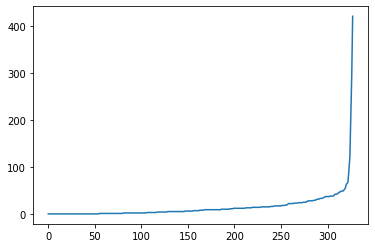

In [173]:
loan_columns = ["payments"]
k_distance_plot(df[loan_columns], len(loan_columns) + 1)

In [174]:
DB_outliers(df[loan_columns], 0.01, len(loan_columns) + 1)

Num Clusters:28
Size Outliers:273


<AxesSubplot:xlabel='status', ylabel='payments'>

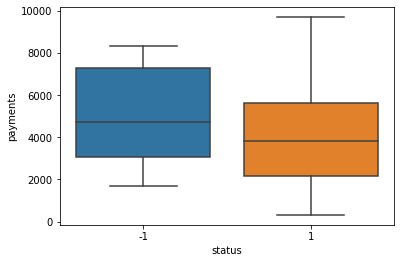

In [179]:
sb.boxplot(x="status", y=loan_columns[0], data=df)

No outliers 

## Feature selection

### Deal with categorical data

Most models cannot deal with categorical data, so  we need to remove them (if there are any left).

In [158]:
df.dtypes

issuance_freq                    int64
is_coowned                       int64
district                       float64
region                         float64
people_count                   float64
muni_500-1999_count              int64
muni_2000-9999_count             int64
muni_10000_count                 int64
cities_count                     int64
ratio_urban_people             float64
avg_salary                     float64
enterp_per1000                   int64
payments                         int64
sanctions                        int64
household_mean                 float64
interest_mean                  float64
balance_min                    float64
balance_max                    float64
balance_mean                   float64
balance_bellow_500             float64
balance_bellow_5k              float64
is_male                           bool
age_start                        int64
unem_growth                    float64
crime_growth                   float64
status                   

There are no categorical attributes left.

### Select attributes for classification

In [159]:
def getXy(df):
    # inputs
    X = df.drop(["status"], axis=1)
    # target
    y = df["status"]
    return (X, y)

X_train, y_train = getXy(df)

In [160]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

rf = RandomForestClassifier(random_state=0)
sel = SelectFromModel(rf)
clf = LGBMClassifier(random_state=0)

pipe = Pipeline([("selector", sel), ("clf", clf)])

params = {
    "selector__threshold": [
        "0.5*mean",
        "0.75*mean",
        "mean",
        "1.25*mean",
    ],
    "selector__estimator__n_estimators": np.arange(75, 151, 25),
}

gs = GridSearchCV(pipe,
                  param_grid=params,
                  scoring="f1",
                  n_jobs=configNJobs)
gs.fit(X_train, y_train)
(gs.best_score_, gs.best_params_)

(0.9378271678289657,
 {'selector__estimator__n_estimators': 100, 'selector__threshold': '0.5*mean'})

In [161]:
sel = SelectFromModel(
    RandomForestClassifier(n_estimators=gs.best_params_["selector__estimator__n_estimators"], random_state=0),
    threshold="1.0*mean")
sel.fit(X_train, y_train)
selected_attr = X_train.columns[(sel.get_support())]
selected_attr

Index(['region', 'payments', 'interest_mean', 'balance_min', 'balance_max',
       'balance_mean', 'balance_bellow_500', 'balance_bellow_5k', 'age_start',
       'balance_growth_lastmonth'],
      dtype='object')

In [162]:
attr_to_drop = set(df.columns) - set(selected_attr)
attr_to_drop.remove("status")

df.drop(attr_to_drop, axis=1, inplace=True)
df_test.drop(attr_to_drop, axis=1, inplace=True)

### ANOVA test

In [163]:
do_anova(selected_attr)

Features      Score
7         balance_bellow_5k  71.808531
6        balance_bellow_500  47.141053
3               balance_min  17.658363
5              balance_mean  12.747115
1                  payments   9.518871
9  balance_growth_lastmonth   7.302655
8                 age_start   0.629296
0                    region   0.557291
2             interest_mean   0.387150
4               balance_max   0.128700

### Correlation matrix

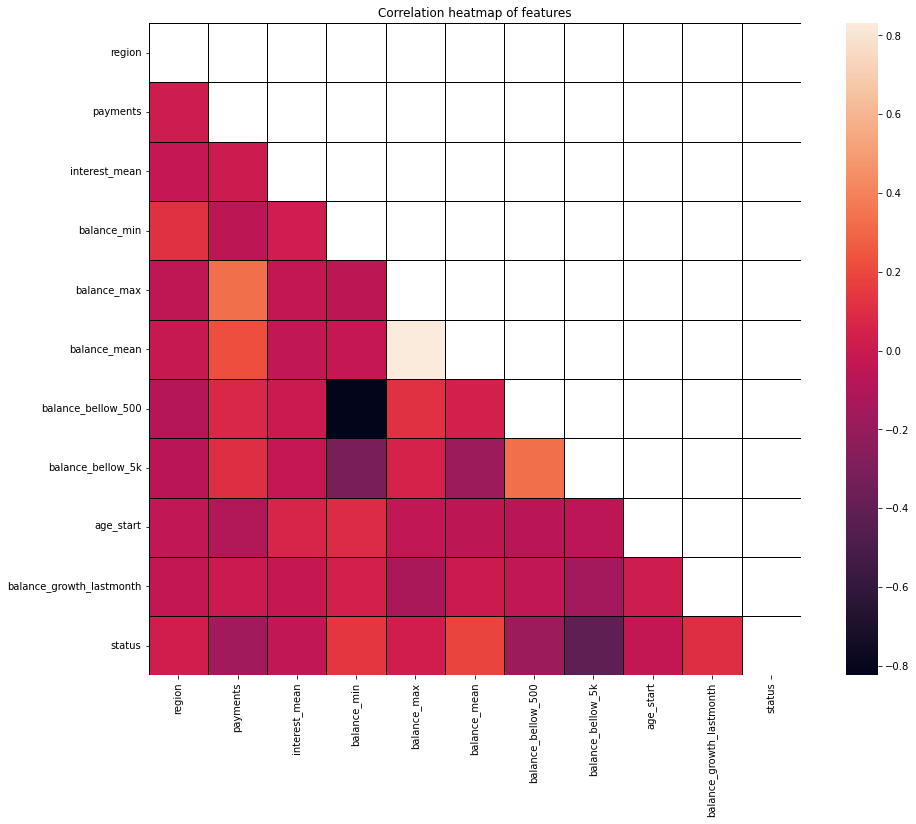

In [164]:
do_corr(list(selected_attr) + ["status"], annot=False)

### Pair plots

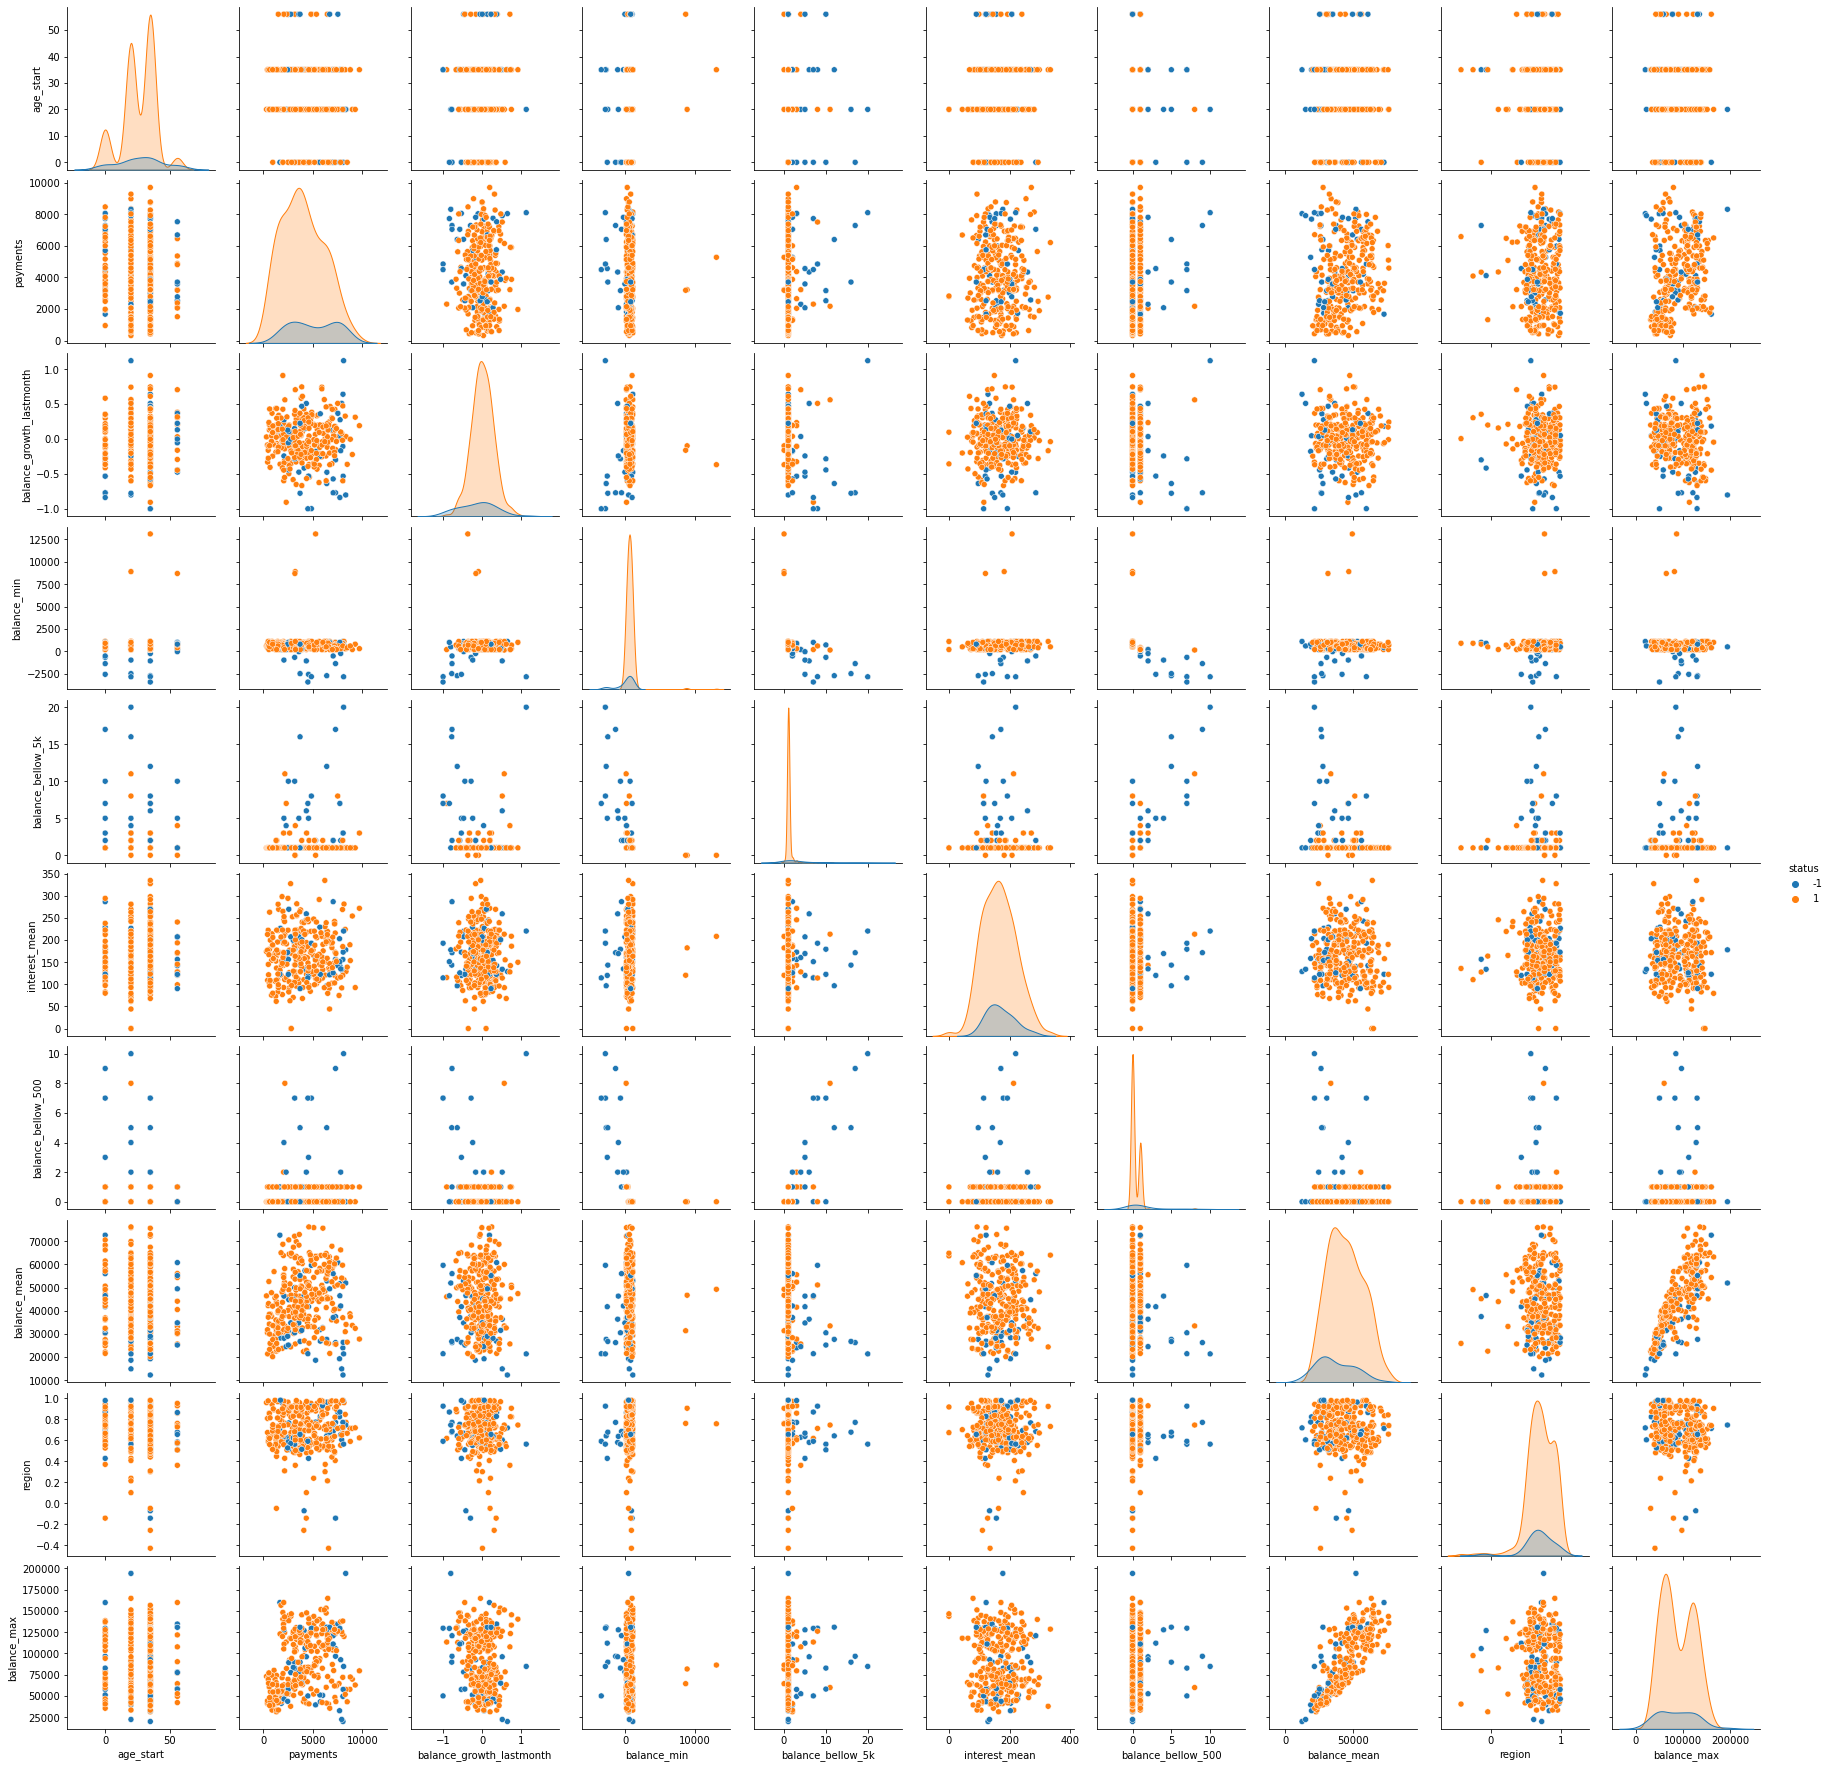

In [165]:
do_pairplot(list(selected_attr))

### Outliers

In [166]:
import scipy.stats as stats

z = stats.zscore(df.drop(["status"], axis=1))
df[(z.values < 3).all(axis=1)]

region  payments  interest_mean  balance_min  balance_max  \
0    0.719512      8033     128.930000       1100.0      20100.0   
1    0.719512      4610     118.091667        700.0     120512.8   
2    0.859756      2118     193.711111        800.0      49590.4   
3    0.719512      2939     252.633333       1000.0      65898.5   
4    0.719512      4579     122.200000        600.0     122893.1   
..        ...       ...            ...          ...          ...   
323  0.504480      3242     213.500000        200.0      75294.1   
324  0.657317      3703      90.257143        800.0     130659.1   
325  0.514390       938     189.125000        800.0      63659.3   
326  0.603855      3217     163.472727       1100.0     119527.2   
327  0.523912      5392     111.846154       1000.0      56055.6   

     balance_mean  balance_bellow_500  balance_bellow_5k  age_start  status  \
0    12250.000000                 0.0                1.0         35      -1   
1    52083.859459                 0.0                2.0         20       1   
2    30060.954167                 0.0                1.0         56       1   
3    41297.480000                 0.0                1.0         35       1   
4    57188.211111                 0.0                1.0          0       1   
..            ...                 ...                ...        ...     ...   
323  44197.509884                 1.0                1.0         20       1   
324  55230.444068                 0.0                1.0         56      -1   
325  41994.907692                 0.0                1.0         35       1   
326  56646.516129                 0.0                1.0         35       1   
327  30869.781308                 0.0                1.0         20       1   

     balance_growth_lastmonth  
0                    0.640816  
1                   -0.364222  
2                    0.205320  
3                    0.029969  
4                   -0.127919  
..                        ...  
323                  0.229616  
324                  0.224680  
325                  0.092464  
326                  0.107125  
327                 -0.022615  

[313 rows x 11 columns]

### Save clean data

In [167]:
from pathlib import Path

filepath = Path("cool_data")
filepath.mkdir(parents=True, exist_ok=True)
    
df.to_csv('cool_data/train-data-clean.csv', index=False)
df_test.to_csv('cool_data/test-data-clean.csv', index=False)

## Classification

### Read clean data

In [168]:
df = pd.read_csv('cool_data/train-data-clean.csv')
df_test = pd.read_csv('cool_data/test-data-clean.csv')

### Split data

In [169]:
def getXy(df):
    # inputs
    X = df.drop(["status"], axis=1)
    # target
    y = df["status"]
    return (X, y)

X_train, y_train = getXy(df)
X_test, y_test = getXy(df_test)

#### Scale data

In [170]:
from sklearn import preprocessing

def scale(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler.transform(X)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

Note that we scaled our data. We did this because we need it to obtain better results on distance-based models: K-NN and SVC. This doesn't affect tree-based algorithms so we do it here.

In [171]:
from sklearn.model_selection import RepeatedStratifiedKFold

k = 5
kr = 3
kf = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)

We will be using **Stratified K-Fold with 10 folds** for our cross-validations.

### Establishing a baseline

Let's establish a baseline for our classifiers.

In [172]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

clfs = {
    #"dt":  {"name": "Decision tree", "base": DecisionTreeClassifier(random_state=0), "scale": False, "grid": {}, "clfs": {}},
    #"knn": {"name": "K-NN", "base": KNeighborsClassifier(), "scale": True, "grid": {}, "clfs": {}},
    "svm": {"name": "SVC", "base": SVC(random_state=0), "scale": True, "grid": {}, "clfs": {}},
    "lr":  {"name": "Logistic Regression", "base": LogisticRegression(random_state=0), "scale": True, "grid": {}, "clfs": {}},
    #"nb":  {"name": "Naive Bayes", "base": GaussianNB(), "scale": False, "grid": {}, "clfs": {}},
    #"gb":  {"name": "Gradient boosting", "base": GradientBoostingClassifier(random_state=0), "scale": False, "grid": {}, "clfs": {}},
    "rf":  {"name": "Random Forest", "base": RandomForestClassifier(random_state=0), "scale": False, "grid": {}, "clfs": {}},
    "lb":  {"name": "LightGBM", "base": LGBMClassifier(random_state=0), "scale": False, "grid": {}, "clfs": {}},
}

In [173]:
from sklearn.model_selection import cross_validate

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"}

# save classifier information in DataFrame: name, score, fit_time, score_time
baseline_df = pd.DataFrame()
for clf_id in clfs:
    clf_entry = clfs[clf_id]
    Xt = X_train_scaled if clf_entry["scale"] else X_train 
    scores = cross_validate(clf_entry["base"], Xt, y_train, scoring=scoring, cv=kf, n_jobs=configNJobs)
    info = scores | {"classifier": [clf_entry["name"]] * (k * kr)}
    baseline_df = baseline_df.append(pd.DataFrame(info))

baseline_df.head()

fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  0.002244    0.007931       0.863636        0.861538     1.000000  0.925620   
1  0.002053    0.007453       0.909091        0.904762     1.000000  0.950000   
2  0.002067    0.006901       0.863636        0.863636     1.000000  0.926829   
3  0.002107    0.007006       0.861538        0.885246     0.964286  0.923077   
4  0.007571    0.003351       0.861538        0.873016     0.982143  0.924370   

   test_roc_auc classifier  
0      0.787500        SVC  
1      0.719298        SVC  
2      0.857700        SVC  
3      0.740079        SVC  
4      0.966270        SVC

#### Accuracy (score)

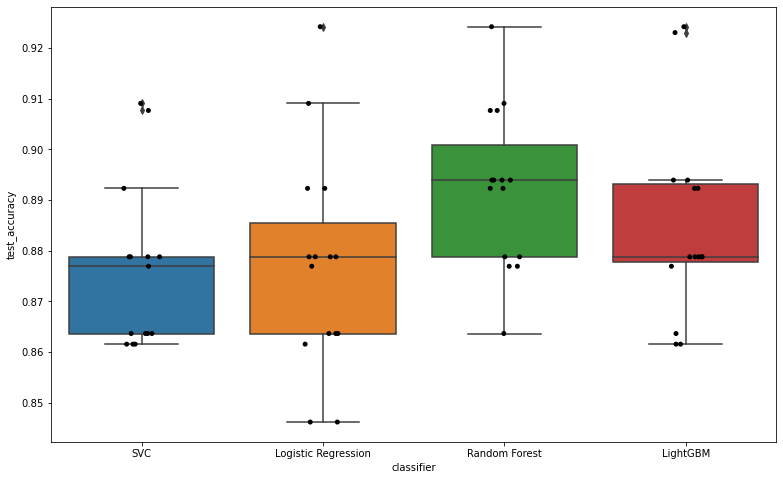

In [174]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_accuracy", data=baseline_df);
sb.stripplot(x='classifier', y='test_accuracy', data=baseline_df, jitter=True, color='black');

#### Precision

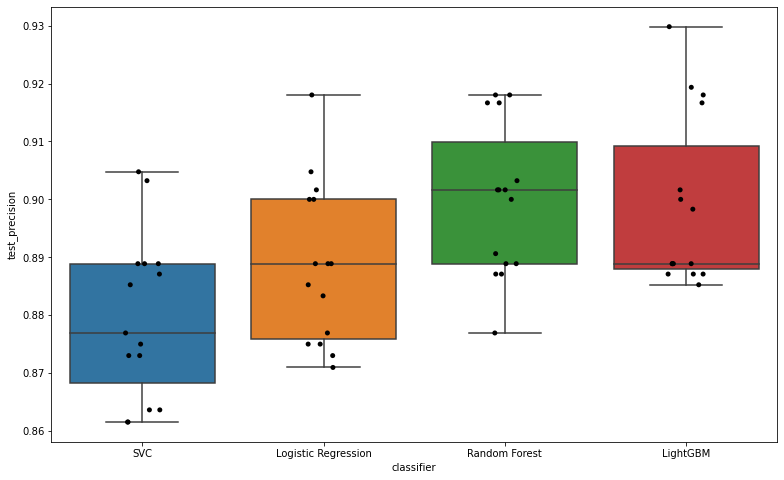

In [175]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_precision", data=baseline_df);
sb.stripplot(x='classifier', y='test_precision', data=baseline_df, jitter=True, color='black');

#### Recall

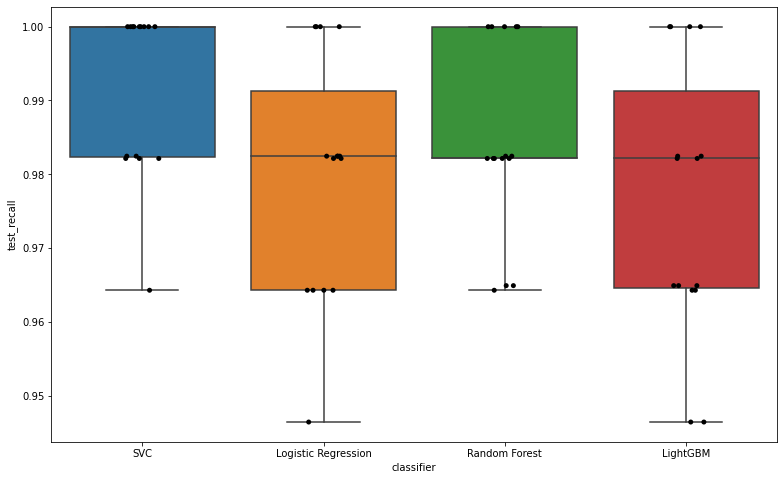

In [176]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_recall", data=baseline_df);
sb.stripplot(x='classifier', y='test_recall', data=baseline_df, jitter=True, color='black');

#### F1-score

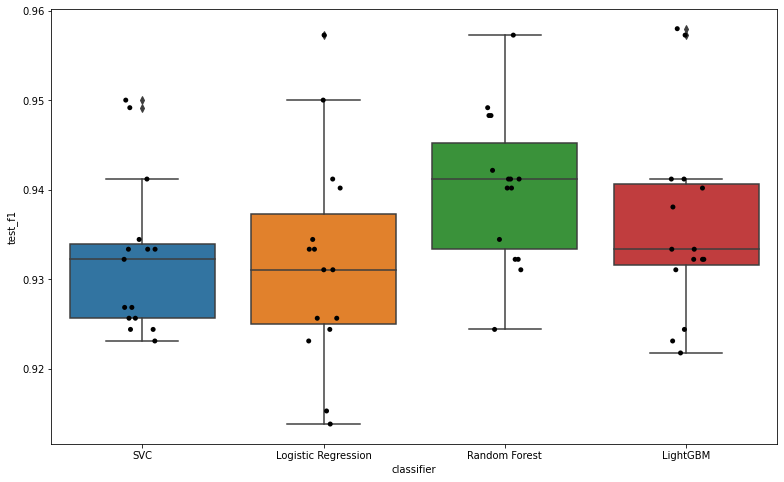

In [177]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_f1", data=baseline_df);
sb.stripplot(x='classifier', y='test_f1', data=baseline_df, jitter=True, color='black');

#### Roc-Curve Area Under the Curve

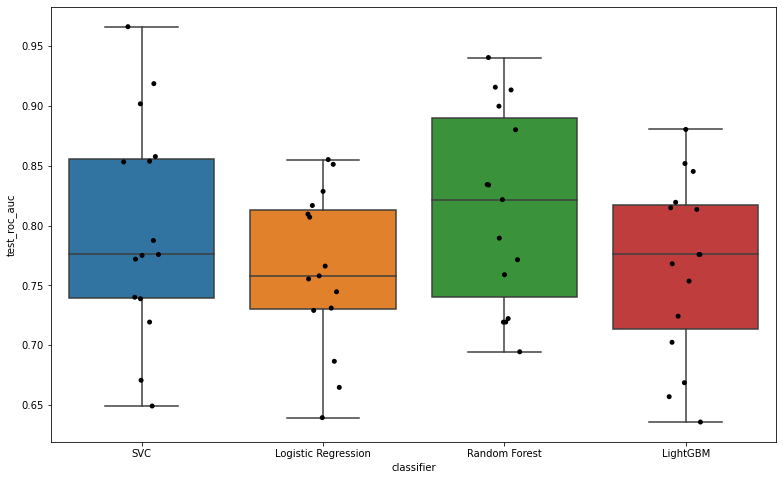

In [178]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_roc_auc", data=baseline_df);
sb.stripplot(x='classifier', y='test_roc_auc', data=baseline_df, jitter=True, color='black');

#### Fit and score times

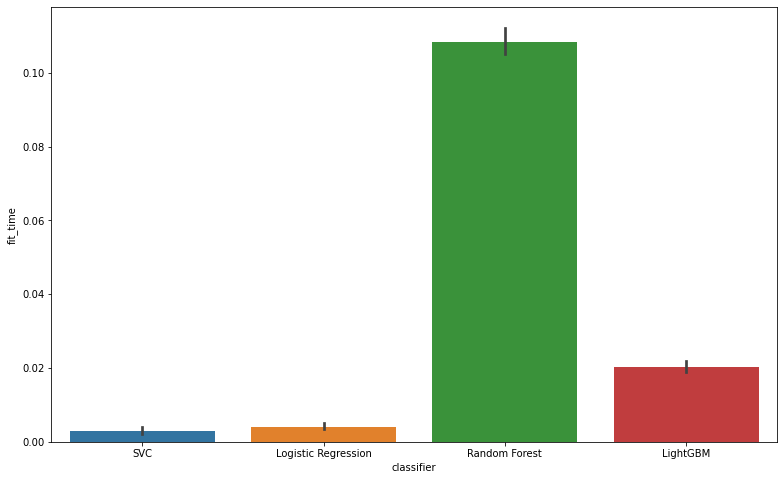

In [179]:
plt.figure(figsize=(13, 8))
sb.barplot(x="classifier", y="fit_time", data=baseline_df);

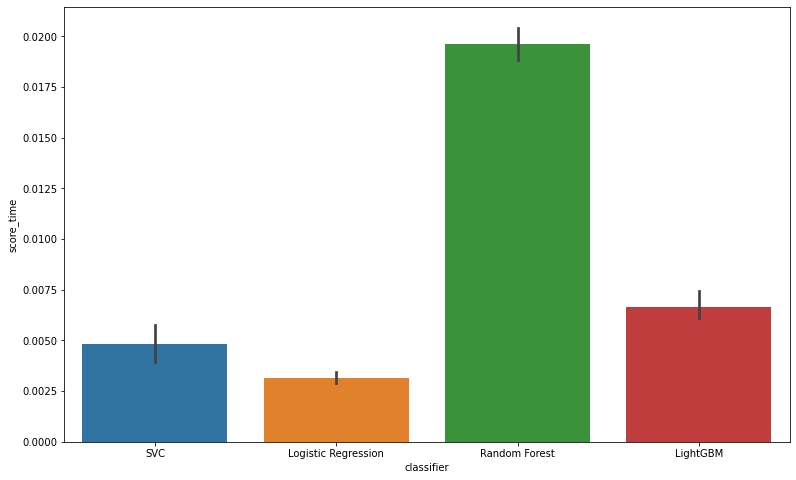

In [180]:
plt.figure(figsize=(13, 8))
sb.barplot(x="classifier", y="score_time", data=baseline_df);

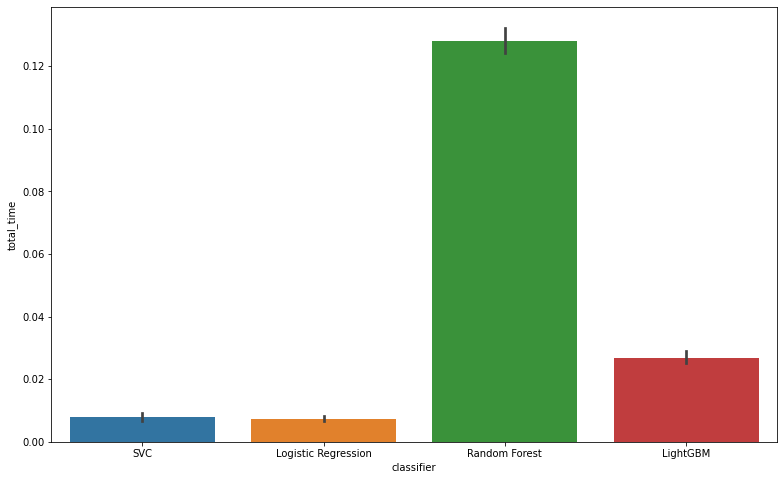

In [181]:
baseline_df["total_time"] = baseline_df["score_time"] + baseline_df["fit_time"]

plt.figure(figsize=(13, 8))
sb.barplot(x="classifier", y="total_time", data=baseline_df);

### Parameter tuning

We will now tune the parameters, so we can find which is the best classifier to use in our problem.

In [182]:
from matplotlib import gridspec
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

def grid_search(clf, parameter_grid, scale=False):
    grid_search = GridSearchCV(clf,
                               param_grid=parameter_grid,
                               cv=kf,
                               scoring="roc_auc",
                               n_jobs=configNJobs)
    Xt = X_train_scaled if scale else X_train
    grid_search.fit(Xt, y_train)
    # output info
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))
    clf = grid_search.best_estimator_
    
    # plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(20, 16))
    ax = plt.subplot(gs[0, 0])
    sb.histplot(x="mean_test_score", data=grid_search.cv_results_, kde=True, ax=ax)
    ax = plt.subplot(gs[0, 1])
    sb.boxplot(x="mean_test_score", data=grid_search.cv_results_, ax=ax)
    # roc and prec-recall curves
    ax = plt.subplot(gs[1, 0])
    RocCurveDisplay.from_estimator(clf, Xt, y_train, pos_label=-1, ax=ax)
    ax = plt.subplot(gs[1, 1])
    PrecisionRecallDisplay.from_estimator(clf, Xt, y_train, ax=ax)
    
    # return the best classifier
    return clf

def grid_search_clf(id):
    clf = grid_search(clfs[id]["base"], clfs[id]["grid"], clfs[id]["scale"])
    clfs[id]["clfs"]["no oversampling"] = clf

#### Support vector classifier

Best score: 0.7991887125220458
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 0}


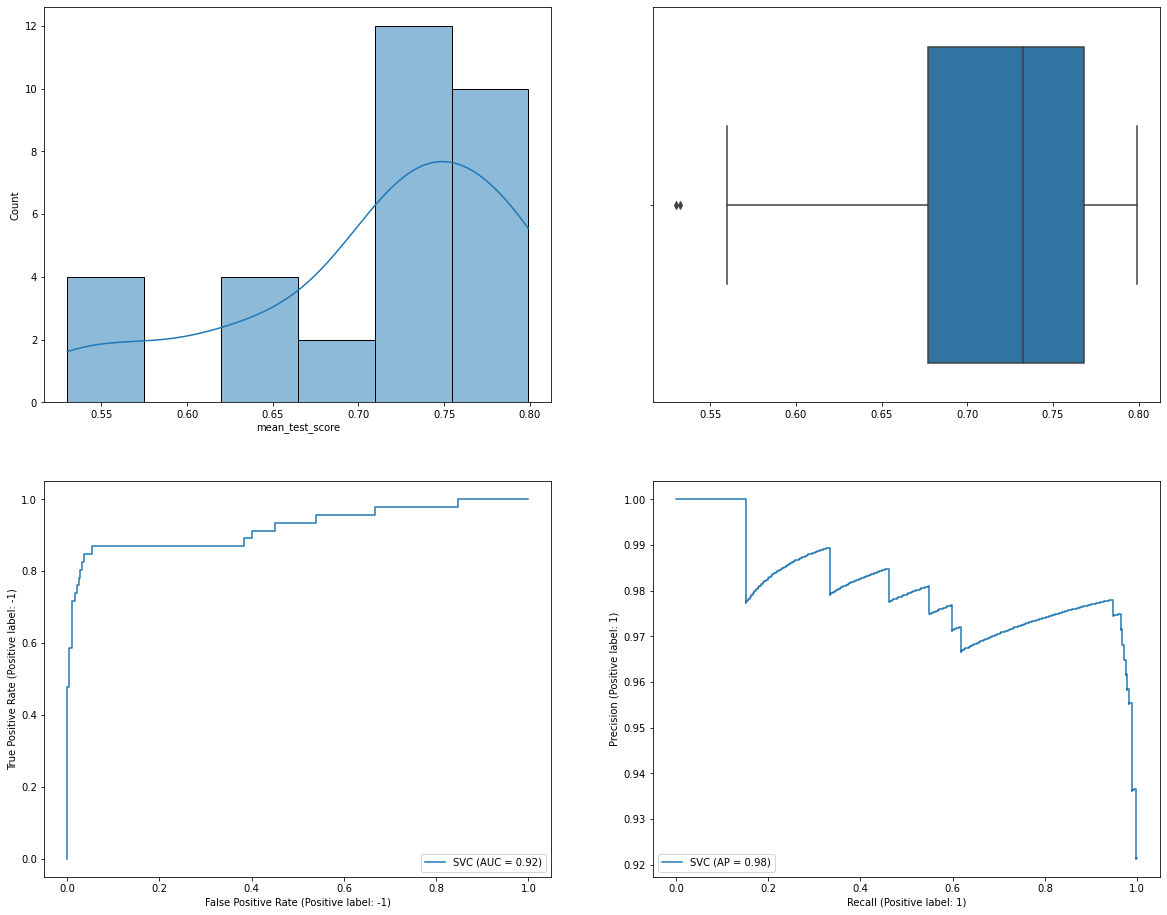

In [183]:
clfs["svm"]["grid"] = {
    "C": [0.01, 0.1, 1, 10],
    "gamma": ["auto", "scale"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "probability": [True],
    "random_state": [0]
}

grid_search_clf("svm")

#### Logistic regression classifier

Best score: 0.7626099972152603
Best parameters: {'C': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear'}


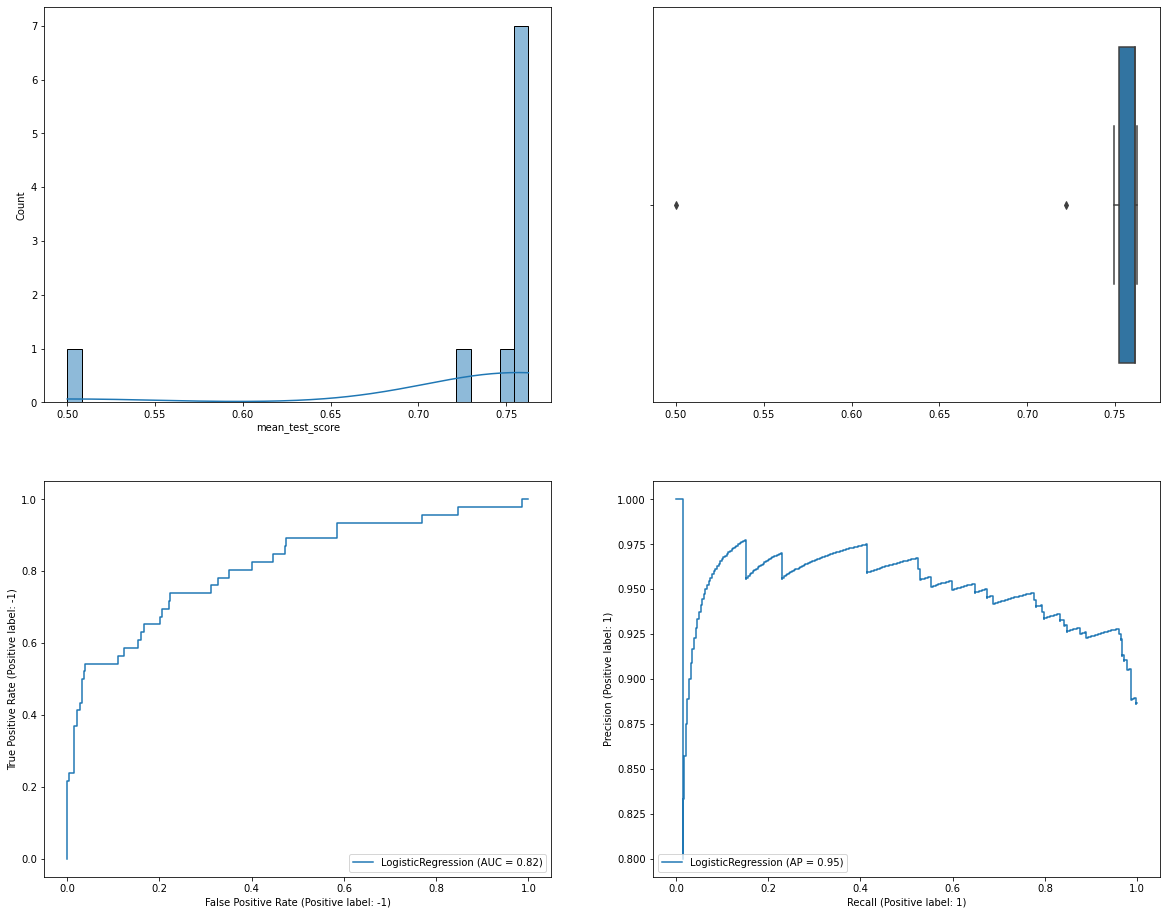

In [184]:
# For small datasets, ‘liblinear’ is a good choice,
# whereas ‘sag’ and ‘saga’ are faster for large ones;
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
# handle multinomial loss;
#‘liblinear’ is limited to one-versus-rest schemes.

clfs["lr"]["grid"] = {
    "C": [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    "random_state": [0],
}

grid_search_clf("lr")

#### Random forest classifier

Best score: 0.8061465005105356
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 125, 'random_state': 0}


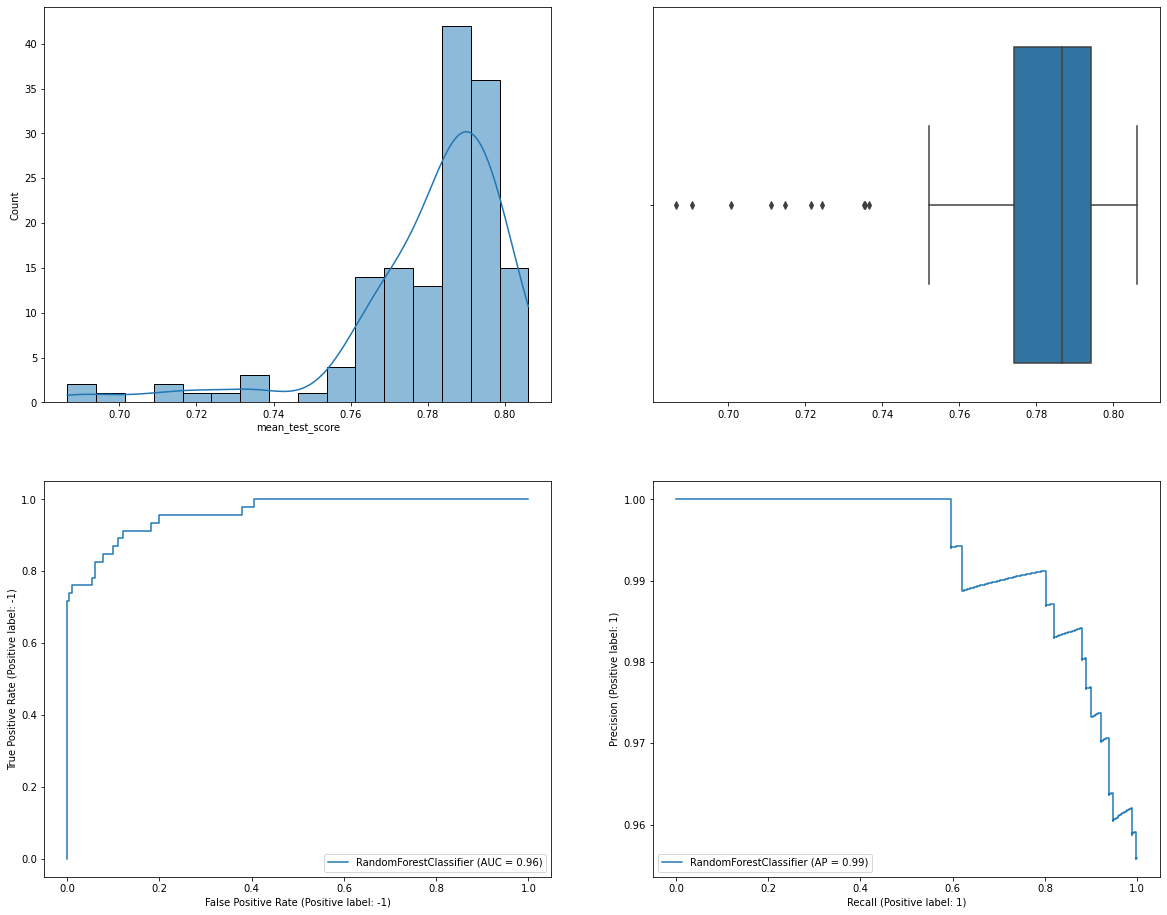

In [185]:
# np.arange(4, len(X_train.columns) + 1, 1),
clfs["rf"]["grid"] = {
    "n_estimators": np.arange(50, 160, 25),
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(1, 6, 1),
    "max_features": ["sqrt", "log2", None],
    "random_state": [0]
}

grid_search_clf("rf")

#### LightGBM classifier

Best score: 0.8010254803675857
Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06999999999999999, 'max_depth': 1, 'n_estimators': 75, 'num_leaves': 2, 'objective': 'binary', 'random_state': 0}


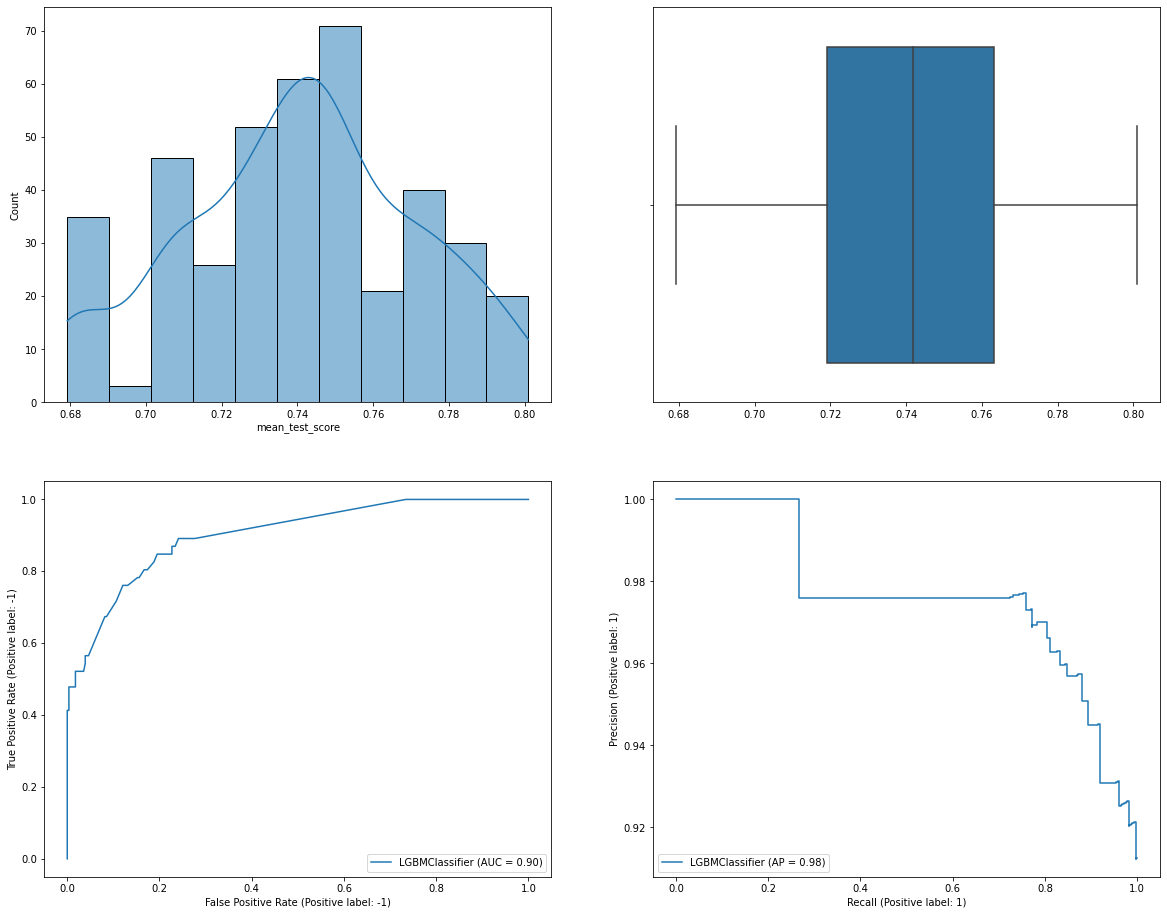

In [186]:
clfs["lb"]["grid"] = {
    "boosting_type": ["gbdt", "dart", "goss"],
    "num_leaves": np.arange(2, 5, 1),
    "max_depth": np.arange(1, 4, 1),
    "learning_rate": np.arange(0.01, 0.1, 0.02),
    "n_estimators": np.arange(50, 101, 25),
    "objective": ["binary"],
    "random_state": [0]
}

grid_search_clf("lb")

### Oversampling

In [187]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

def grid_search_oversample(clf, parameter_grid, smote, scale=False):
    imba_pipeline = Pipeline([("os", smote), ("model", clf)])
    prefixed_param_grid = {"os__sampling_strategy": [0.3, 0.4, 0.5, 0.6,
                                                     0.7, 0.8, 0.9, 1.0]}
    for key in parameter_grid:
        prefixed_param_grid["model__" + key] = parameter_grid[key]
    return grid_search(imba_pipeline, prefixed_param_grid, scale)

#### SMOTE

In [188]:
from imblearn.over_sampling import SMOTE

def os_smote(id):
    smote = SMOTE(random_state=0, n_jobs=configNJobs)
    clf = grid_search_oversample(clfs[id]["base"], clfs[id]["grid"],
                                 smote, clfs[id]["scale"])
    clfs[id]["clfs"]["smote"] = clf

##### Support vector classifier

Best score: 0.7942683096630464
Best parameters: {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 0, 'os__sampling_strategy': 0.4}


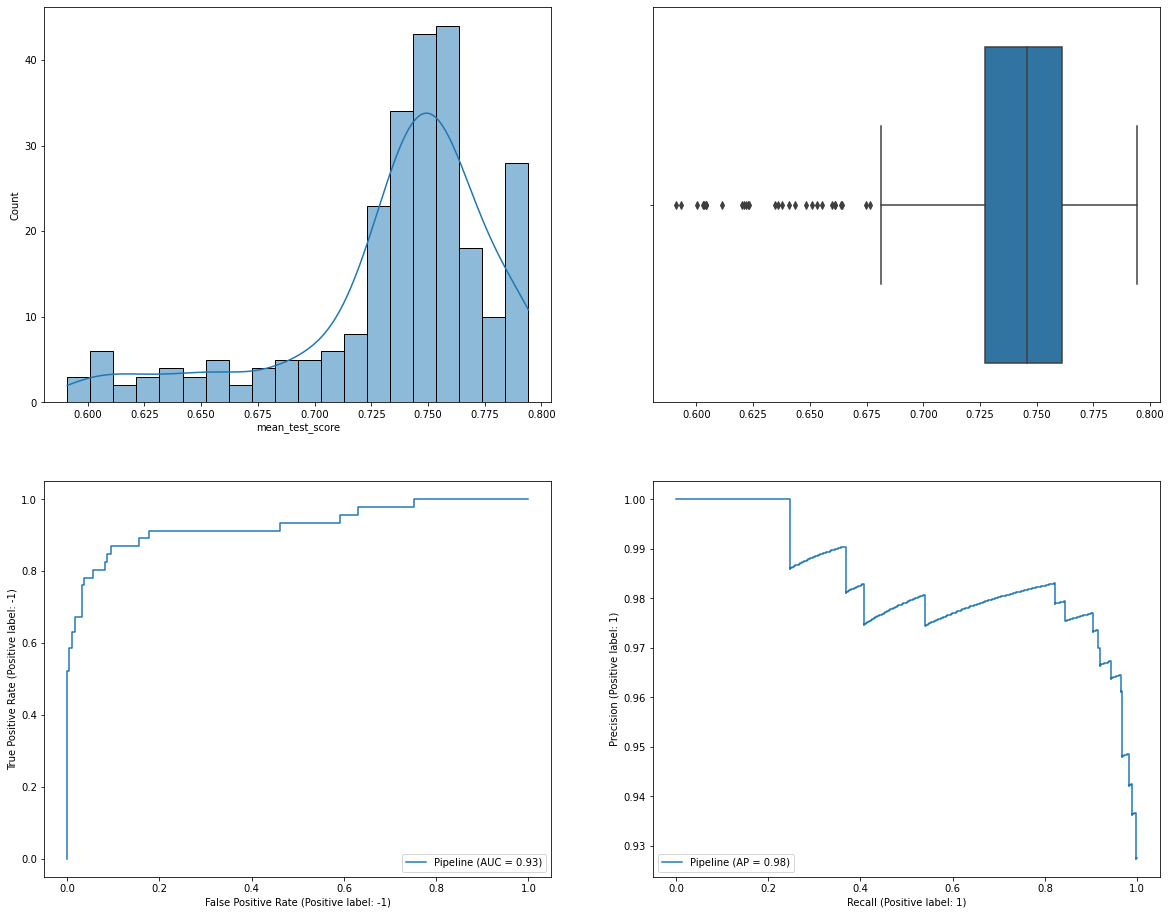

In [189]:
os_smote("svm")

##### Logistic Regression classifier

Best score: 0.7609463473498562
Best parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__random_state': 0, 'model__solver': 'liblinear', 'os__sampling_strategy': 0.4}


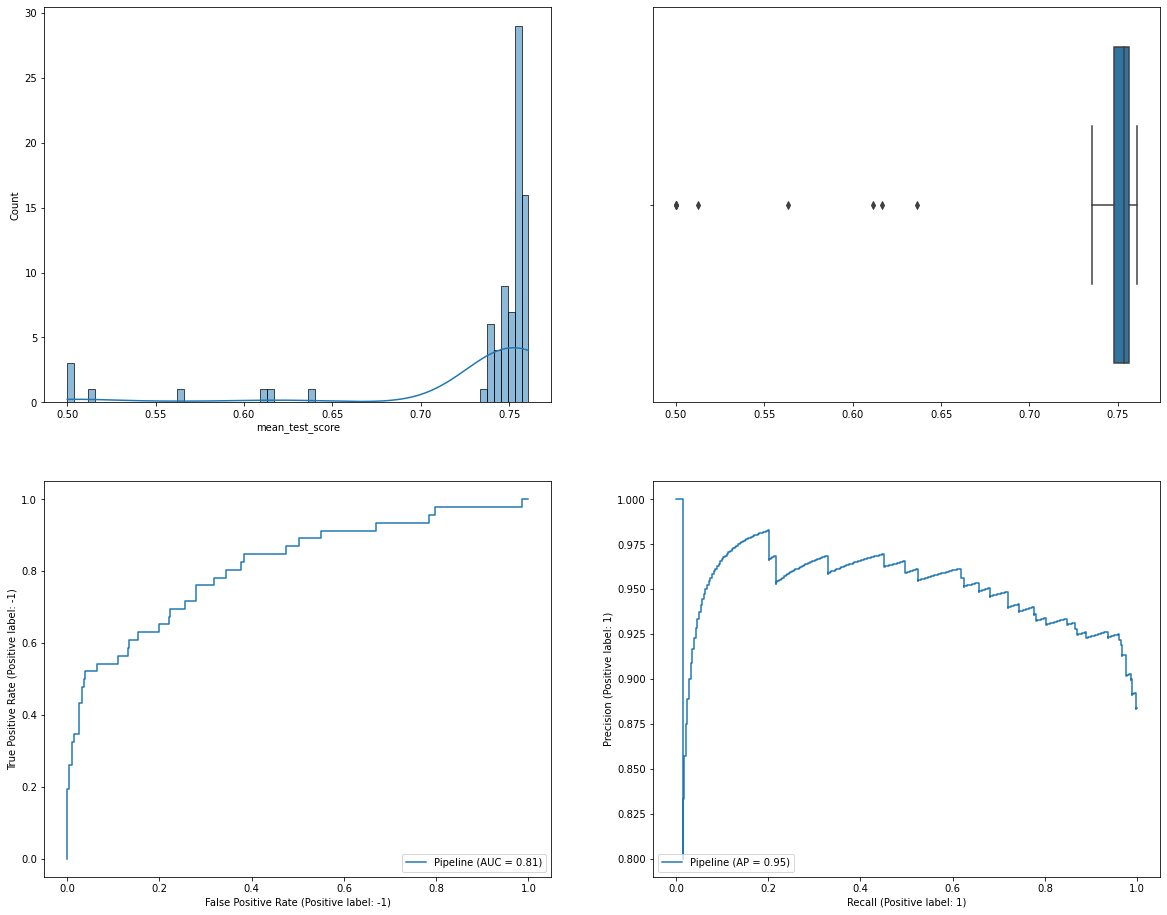

In [190]:
os_smote("lr")

##### Random forest classifier

Best score: 0.8194279680683191
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__n_estimators': 125, 'model__random_state': 0, 'os__sampling_strategy': 0.6}


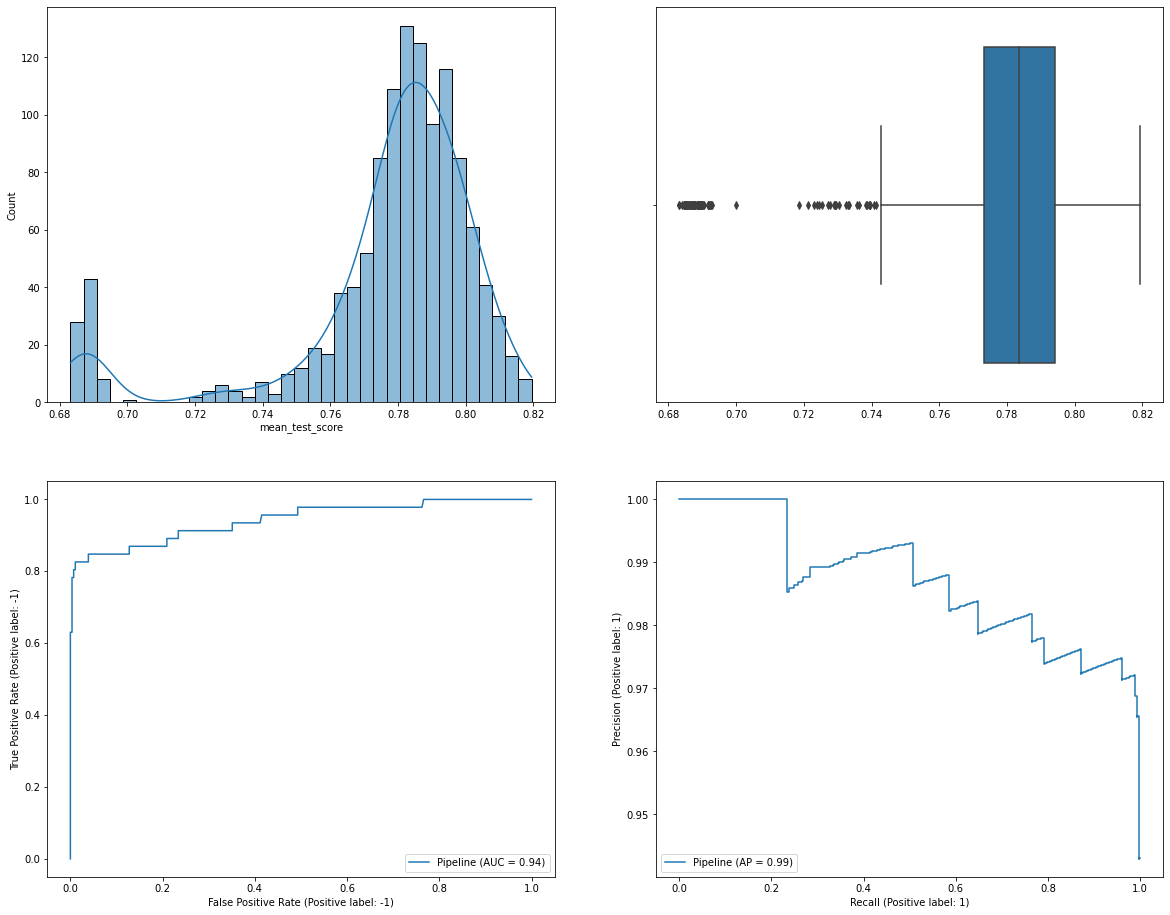

In [191]:
os_smote("rf")

##### LightGBM classifier

Best score: 0.8084489000278474
Best parameters: {'model__boosting_type': 'gbdt', 'model__learning_rate': 0.049999999999999996, 'model__max_depth': 1, 'model__n_estimators': 100, 'model__num_leaves': 2, 'model__objective': 'binary', 'model__random_state': 0, 'os__sampling_strategy': 0.4}


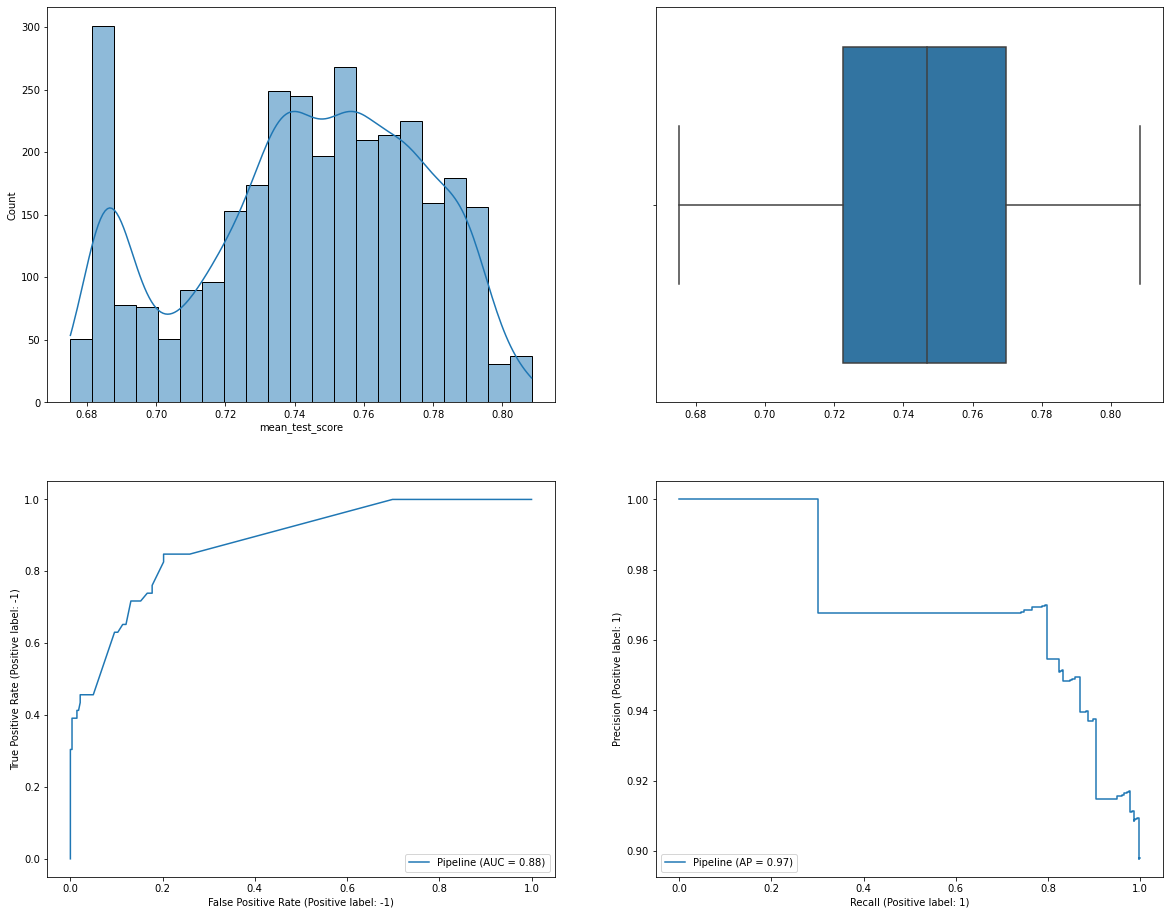

In [192]:
os_smote("lb")

#### SVMSMOTE

In [193]:
from imblearn.over_sampling import SVMSMOTE

def os_svmsmote(id):
    smote = SVMSMOTE(random_state=0, n_jobs=configNJobs)
    clf = grid_search_oversample(clfs[id]["base"], clfs[id]["grid"],
                                 smote, clfs[id]["scale"])
    clfs[id]["clfs"]["svmsmote"] = clf

##### Support vector classifier

Best score: 0.8038327299730808
Best parameters: {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 0, 'os__sampling_strategy': 0.4}


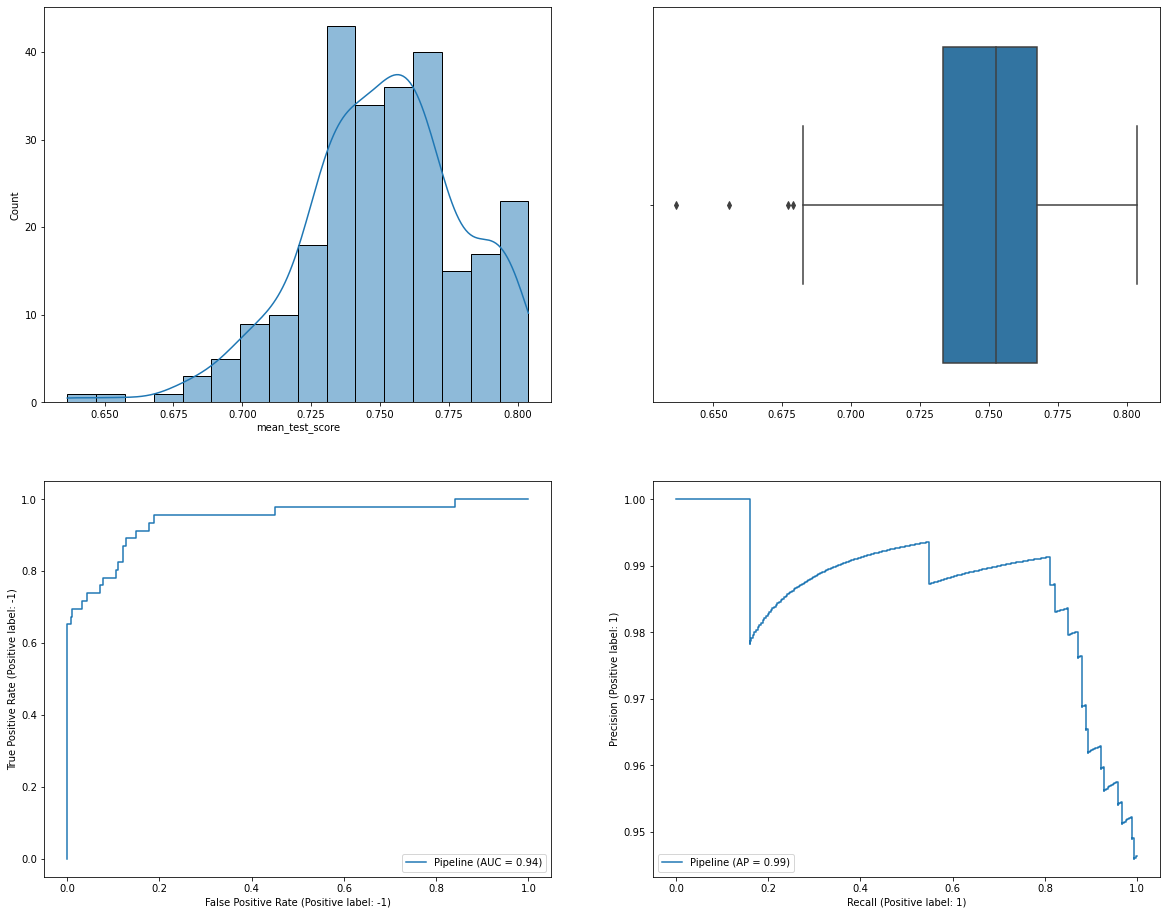

In [194]:
os_svmsmote("svm")

##### Logistic Regression classifier

Best score: 0.7664299637983848
Best parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__random_state': 0, 'model__solver': 'liblinear', 'os__sampling_strategy': 0.4}


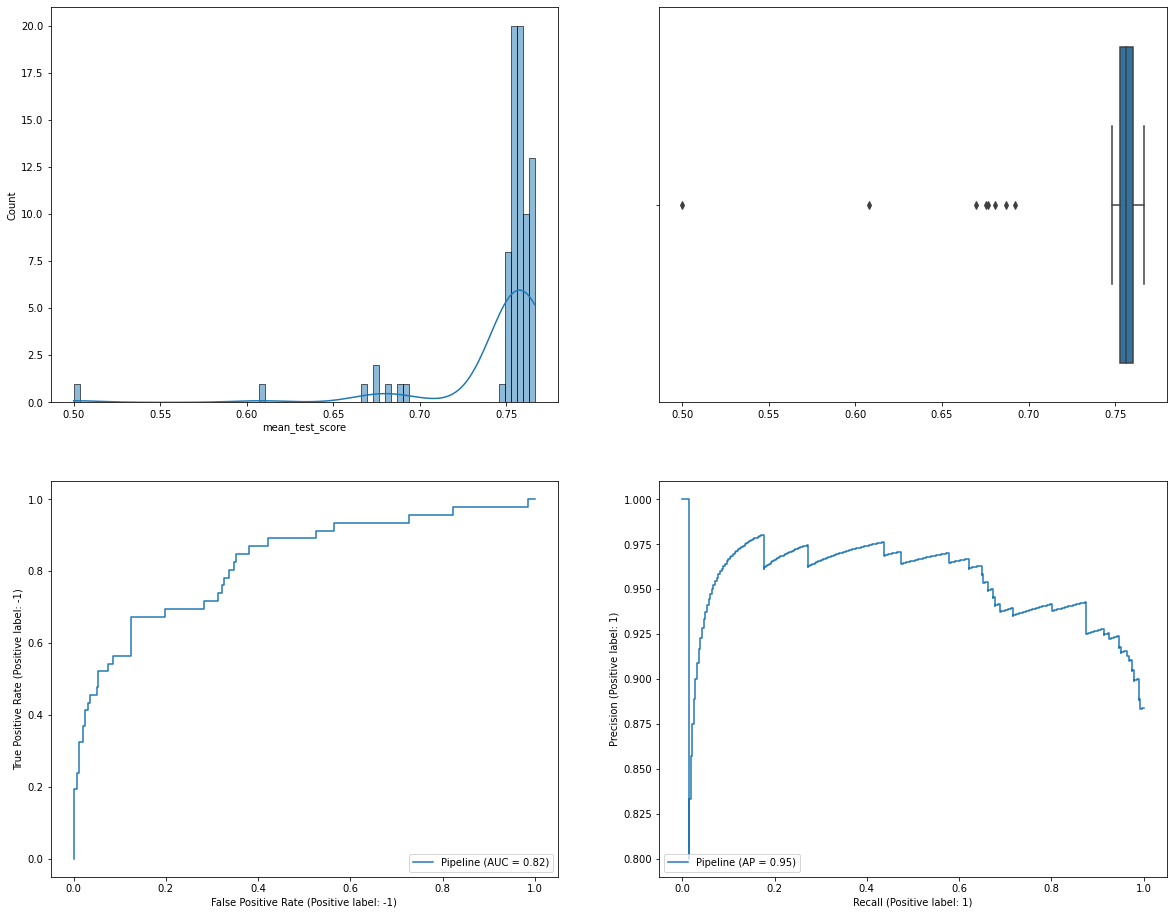

In [195]:
os_svmsmote("lr")

##### Random forest classifier

Best score: 0.8263579086605403
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__n_estimators': 150, 'model__random_state': 0, 'os__sampling_strategy': 1.0}


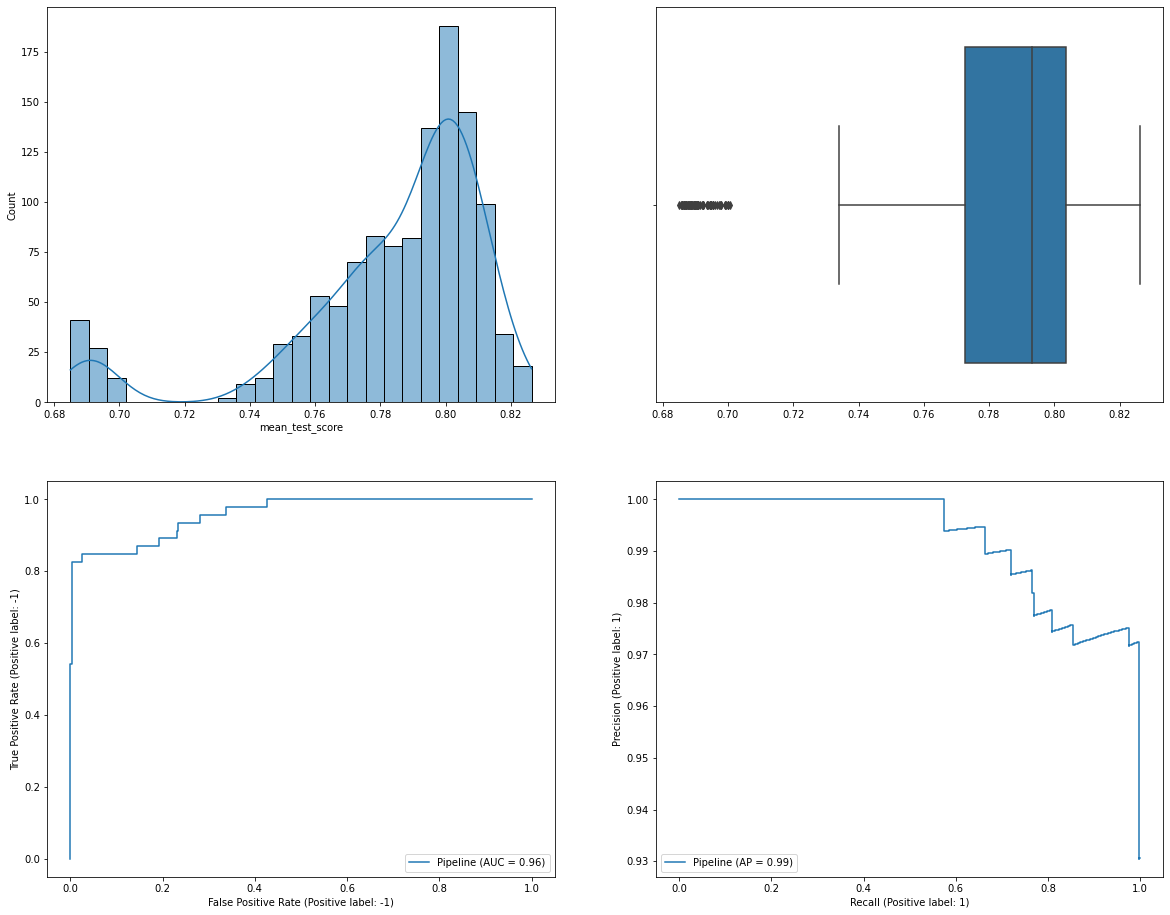

In [196]:
os_svmsmote("rf")

##### LightGBM classifier

Best score: 0.8117492806089296
Best parameters: {'model__boosting_type': 'dart', 'model__learning_rate': 0.06999999999999999, 'model__max_depth': 3, 'model__n_estimators': 75, 'model__num_leaves': 4, 'model__objective': 'binary', 'model__random_state': 0, 'os__sampling_strategy': 1.0}


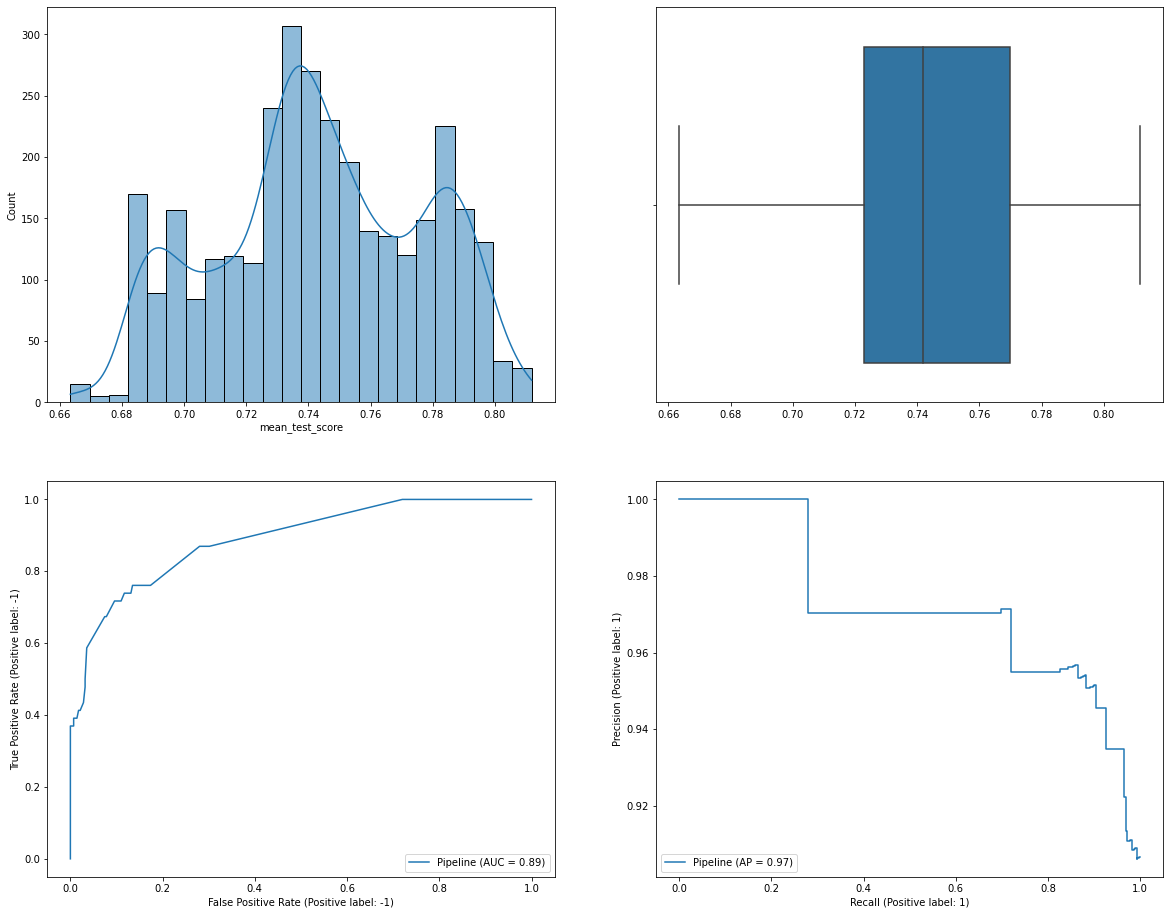

In [197]:
os_svmsmote("lb")

#### ADASYN

In [198]:
from imblearn.over_sampling import ADASYN

def os_adasyn(id):
    smote = ADASYN(random_state=0, n_jobs=configNJobs)
    clf = grid_search_oversample(clfs[id]["base"], clfs[id]["grid"],
                                 smote, clfs[id]["scale"])
    clfs[id]["clfs"]["adasyn"] = clf

##### Support vector classifier

Best score: 0.8008581639283393
Best parameters: {'model__C': 0.01, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 0, 'os__sampling_strategy': 0.3}


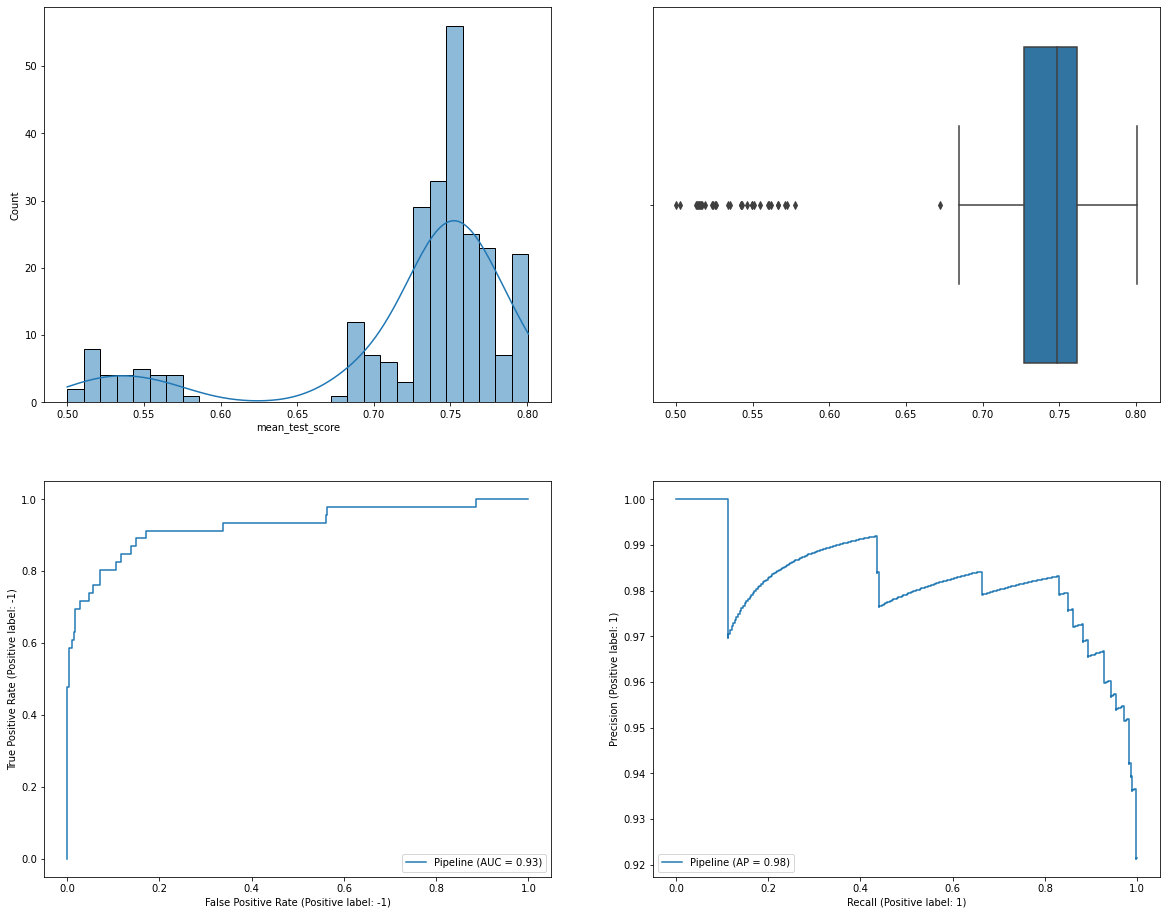

In [199]:
os_adasyn("svm")

##### Logistic Regression classifier

Best score: 0.76359649122807
Best parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__random_state': 0, 'model__solver': 'liblinear', 'os__sampling_strategy': 0.3}


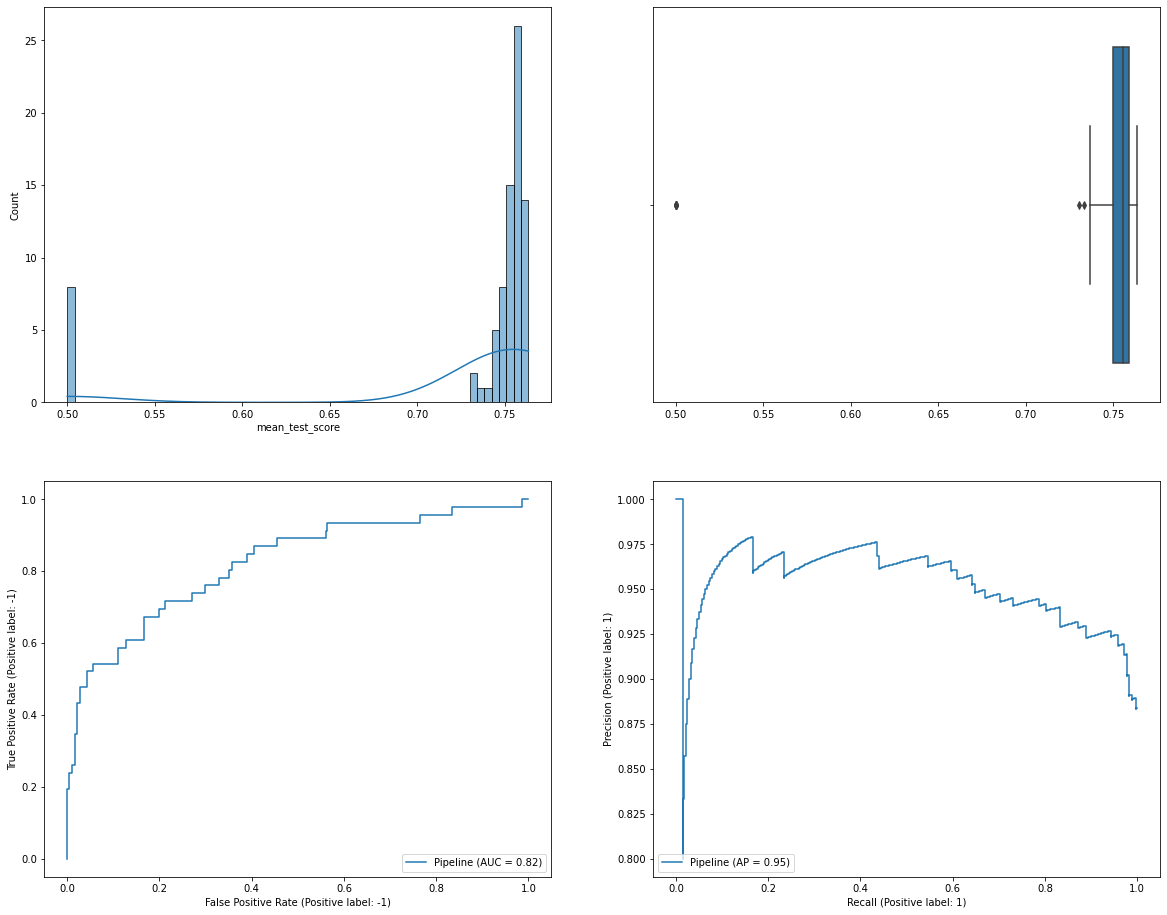

In [200]:
os_adasyn("lr")

##### Random forest classifier

Best score: 0.8169486215538846
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__n_estimators': 150, 'model__random_state': 0, 'os__sampling_strategy': 0.6}


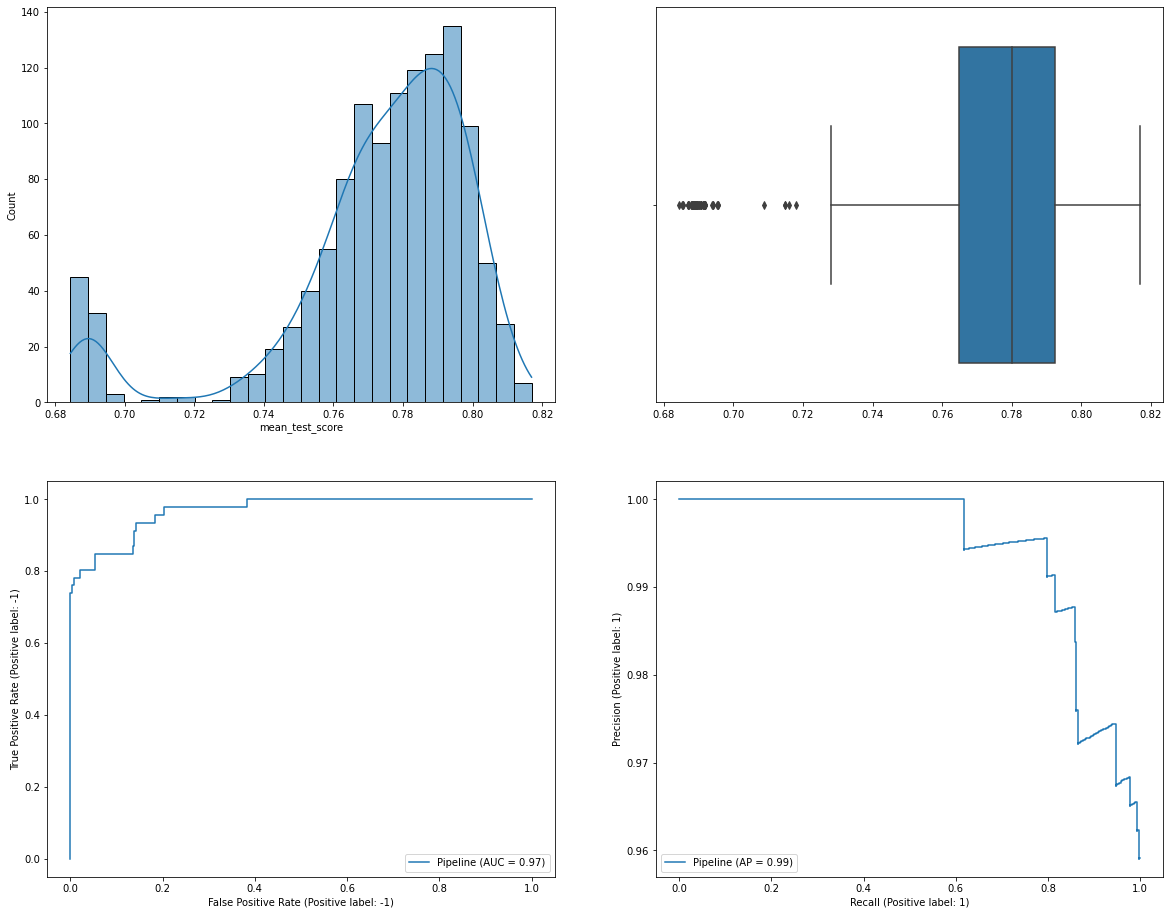

In [201]:
os_adasyn("rf")

##### LightGBM classifier

Best score: 0.8122726956279588
Best parameters: {'model__boosting_type': 'dart', 'model__learning_rate': 0.06999999999999999, 'model__max_depth': 3, 'model__n_estimators': 75, 'model__num_leaves': 4, 'model__objective': 'binary', 'model__random_state': 0, 'os__sampling_strategy': 0.7}


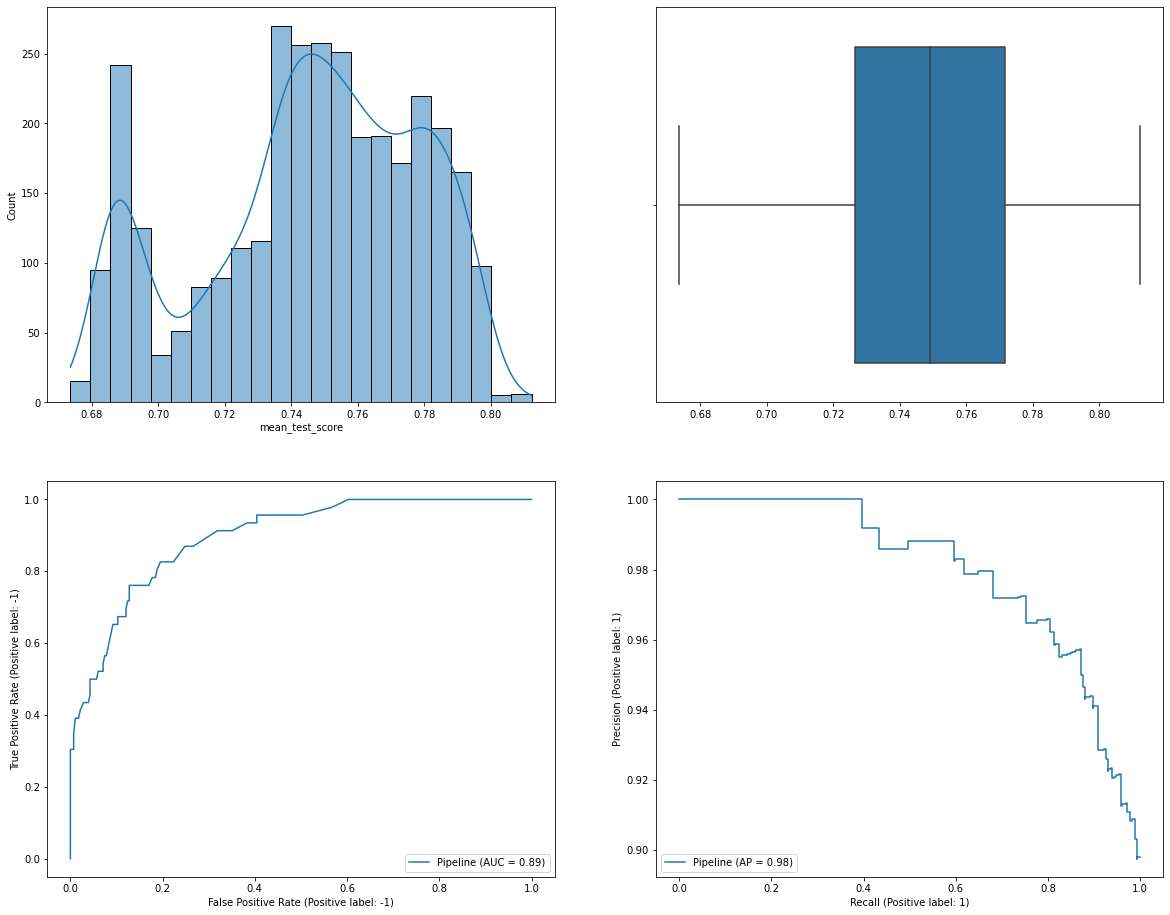

In [202]:
os_adasyn("lb")

### Voting classifier

In [218]:
from sklearn.ensemble import VotingClassifier

clf1 = clfs["svm"]["clfs"]["no oversampling"]
clf2 = clfs["rf"]["clfs"]["no oversampling"]
clf3 = clfs["lb"]["clfs"]["no oversampling"]

voteclf = VotingClassifier(
    estimators=[
        ("SVM", clf1),
        ("RF", clf2),
        ("LGBM", clf3)
    ],
    voting="soft"
)

voteclf.fit(X_train_scaled, y_train)

clfs["vote"] = {
    "name": "Voting classifer",
    "base": VotingClassifier(RandomForestClassifier(random_state=0)),
    "scale": True,
    "grid": {},
    "clfs": {"no oversampling": voteclf}
}

**Note:** scaled data is used since distance-based methods need it and tree-based methods don't care whether data is scaled or not.

### Compare results

In [219]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_metrics(id):
    scores = {"classifier": [], "oversample": [], "auc": [],
              "accuracy": [], "precision": [], "recall": [], "f1": []}
    Xt = X_train_scaled if clfs[id]["scale"] else X_train

    for os, clf in clfs[id]["clfs"].items():
        scores["classifier"].append(clfs[id]["name"])
        scores["oversample"].append(os)
        y_pred = clf.predict(Xt)
        scores["accuracy"].append(accuracy_score(y_train, y_pred))
        scores["precision"].append(precision_score(y_train, y_pred))
        scores["recall"].append(recall_score(y_train, y_pred))
        scores["f1"].append(f1_score(y_train, y_pred))
        # roc curve stuff
        scores["auc"].append(roc_auc_score(y_train, clf.predict_proba(Xt)[:, 1]))
    
    return pd.DataFrame(scores)

In [220]:
clfs_pd = pd.DataFrame()

for id in clfs:
    clfs_pd = clfs_pd.append(get_clf_metrics(id))

clfs_pd

classifier       oversample       auc  accuracy  precision  \
0                  SVC  no oversampling  0.922140  0.859756   0.859756   
1                  SVC            smote  0.927845  0.932927   0.942177   
2                  SVC         svmsmote  0.942800  0.945122   0.952055   
3                  SVC           adasyn  0.926149  0.859756   0.859756   
0  Logistic Regression  no oversampling  0.816297  0.887195   0.893891   
1  Logistic Regression            smote  0.814524  0.887195   0.923875   
2  Logistic Regression         svmsmote  0.824854  0.890244   0.912752   
3  Logistic Regression           adasyn  0.821847  0.896341   0.913333   
0        Random Forest  no oversampling  0.961764  0.926829   0.921569   
1        Random Forest            smote  0.941875  0.954268   0.971731   
2        Random Forest         svmsmote  0.958372  0.957317   0.971831   
3        Random Forest           adasyn  0.968239  0.951220   0.965035   
0             LightGBM  no oversampling  0.901596  0.914634   0.909677   
1             LightGBM            smote  0.878353  0.905488   0.911475   
2             LightGBM         svmsmote  0.888837  0.856707   0.953668   
3             LightGBM           adasyn  0.894658  0.871951   0.928571   
0     Voting classifer  no oversampling  0.946577  0.926829   0.921569   

     recall        f1  
0  1.000000  0.924590  
1  0.982270  0.961806  
2  0.985816  0.968641  
3  1.000000  0.924590  
0  0.985816  0.937605  
1  0.946809  0.935201  
2  0.964539  0.937931  
3  0.971631  0.941581  
0  1.000000  0.959184  
1  0.975177  0.973451  
2  0.978723  0.975265  
3  0.978723  0.971831  
0  1.000000  0.952703  
1  0.985816  0.947189  
2  0.875887  0.913124  
3  0.921986  0.925267  
0  1.000000  0.959184

### Output test results

In [221]:
from pathlib import Path

def output_pred(id, outdir="output", pred_class=-1):
    filepath = Path(outdir)
    filepath.mkdir(parents=True, exist_ok=True)
    
    Xt = X_test_scaled if clfs[id]["scale"] else X_test
    for os, clf in clfs[id]["clfs"].items():
        filename = (clfs[id]["name"] + "_" + os + ".csv").lower().replace(" ", "_")
    
        y_pred_prob = clf.predict_proba(Xt)
        ind = np.where(clf.classes_ == pred_class)[0][0]
        y_pred = y_pred_prob[:, ind]
    
        ret = y_test.copy().reset_index()
        ret["predicted"] = y_pred
        ret["id"] = loan_test_df["loan_id"]
        ret.drop(["index", "status"], axis=1, inplace=True)
        ret = ret[ret.columns[::-1]]
        ret.to_csv(outdir + "/" + filename, index=False)

In [222]:
for id in clfs:
    output_pred(id)

## Credits

**Authors**:

- Ana Inês Oliveira de Barros - up201806593@edu.fe.up.pt
- João de Jesus Costa         - up201806560@edu.fe.up.pt
- João Lucas Silva Martins    - up201806436@edu.fe.up.pt

**Development environment**: Jupyter 4.6.3-2

**Python implementation**: CPython 3.9.9

**Python modules**:

- category-encoders  2.3.0
- imblearn           0.8.0-1
- lightgbm           3.3.0-1
- matplotlib         3.5.0-1
- matplotlib-inline  0.1.3-1
- numpy              1.21.3-1
- pandas             1.3.4-1
- scikit-learn       1.0.1-1
- scipy              1.7.3-1
- seaborn            0.11.2-1

IART MIEIC, FEUP - May, 2021